In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from scipy import stats


from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/METADATA_CURRENT.txt', sep='\t')

# gencode 25
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')


P_Set = pd.read_csv('tmp_res/SET1.txt', sep='\t')

R_Set = pd.read_csv('tmp_res/SET2.txt', sep='\t')

R_Set['pos_of_codon'] = [int(x.split('; ')[1].split('-')[0])-1 for x in R_Set.Riboseq_Summary.tolist()]

R_Set['codon'] = [x.split('; ')[0] for x in R_Set.Riboseq_Summary.tolist()]

R_Set[0:2]

tr_id    gene  N_term_start1  N_term_end1  len_codons  \
0   ENST00000379389.4   ISG15              1          151        50.0   
1  ENST00000349431.10  UBE2J2             28          220        64.0   

  global_coo_50_and_less strand    global_coo_primary  PhyloCSF120score  \
0   chr1:1013424-1013573      +  chr1:1013424-1013573        -2443.9971   
1   chr1:1273666-1273815      -  chr1:1273666-1273857        -1285.8186   

   number_of_records   ovlp                      Riboseq_Summary  \
0                111  0;0;0   ATC; 98-152; Rank: 288; cov: 53.85   
1                 78  0;0;0  ACG; 173-221; Rank: 328; cov: 90.91   

   Coverage_value_ext  Proteomics_count_ext                            tag  \
0           53.846154                   0.0  basic,appris_principal_1,CCDS   
1           90.909091                   0.0  basic,appris_principal_1,CCDS   

  transcript_type  CDS_ratio  pos_of_codon codon  
0  protein_coding   0.327240            97   ATC  
1  protein_coding   0.762814           172   ACG

# TIS scores 

### NonAUG

In [3]:
TIS_efficiency_df = pd.read_csv('data/TIS_nonAUG_efficiency.txt', sep='\t')

TIS_efficiency_df['scaled_efficiency'] = TIS_efficiency_df['TIS Efficiency'] / TIS_efficiency_df['TIS Efficiency'].max()

TIS_efficiency_dict = dict(zip(TIS_efficiency_df['TIS Sequence'], TIS_efficiency_df['TIS Efficiency']))

TIS_efficiency_dict_scaled = dict(zip(TIS_efficiency_df['TIS Sequence'], TIS_efficiency_df['scaled_efficiency']))

TIS_efficiency_df.sort_values(by='TIS Efficiency', ascending=False).head(4)

TIS Sequence  TIS Efficiency  scaled_efficiency
5977     CGCCCUGG            50.4           1.000000
6041     CGCGCUGG            50.4           1.000000
5913     CGCACUGG            50.4           1.000000
6001     CAUCCUGG            47.6           0.944444

## AUG

In [4]:
TIS_AUG_eff = pd.read_csv('data/TIS_AUG_efficiency.txt', sep='\t', skiprows=1)

TIS_AUG_eff['scaled_efficiency'] = TIS_AUG_eff['efficiency'] / TIS_AUG_eff['efficiency'].max()

print (TIS_AUG_eff.efficiency.max(), TIS_AUG_eff.efficiency.min())


TIS_AUG_eff_dict = dict(zip(TIS_AUG_eff['sequence'], TIS_AUG_eff['efficiency']))


TIS_AUG_eff_dict_scaled = dict(zip(TIS_AUG_eff['sequence'], TIS_AUG_eff['scaled_efficiency']))
                           
TIS_AUG_eff[0:5]

150 12


sequence  efficiency  lower.bound  upper.bound  scaled_efficiency
0  UUCAUCAUGCA         150          139          161           1.000000
1  GCGAGUAUGGC         149          139          161           0.993333
2  ACGAGAAUGGC         148          136          160           0.986667
3  AUCAUCAUGCA         147          136          158           0.980000
4  ACGAGUAUGGC         145          134          157           0.966667

# Load PhyloCSF scores per codon 

In [5]:
import os

li = []

path = 'data/PhyloSET_PCSF_per_codon/*/*.txt' # PhyloSET
path2 = 'data/RiboSET_PCSF_per_codon/*/*.txt' # RiboSET

for file in glob.glob(path):
    try:
        tmp = pd.read_csv(file, sep='\t', header=None)
        tmp['tr_id_codon'] = [x.split('/')[-1].split('.fasta')[0] for x in tmp[0].tolist()]
        tmp['tr_id'] = [x.split('/')[-1].split('.fasta')[0].split('_')[0] for x in tmp[0].tolist()]
        tmp['codon'] = [x.split('/')[-1].split('.fasta')[0].split('_')[1] for x in tmp[0].tolist()]
        tmp2 = tmp[['tr_id_codon', 'tr_id', 'codon', 2]]
        tmp2.columns = ['tr_id_codon', 'tr_id', 'codon', 'score']
        li.append(tmp2)
    except Exception as e:
        print (file, e)
        
        
for file in glob.glob(path2):
    try:
        tmp = pd.read_csv(file, sep='\t', header=None)
        tmp['tr_id_codon'] = [x.split('/')[-1].split('.fasta')[0] for x in tmp[0].tolist()]
        tmp['tr_id'] = [x.split('/')[-1].split('.fasta')[0].split('_')[0] for x in tmp[0].tolist()]
        tmp['codon'] = [x.split('/')[-1].split('.fasta')[0].split('_')[-1] for x in tmp[0].tolist()]
        tmp2 = tmp[['tr_id_codon', 'tr_id', 'codon', 2]]
        tmp2.columns = ['tr_id_codon', 'tr_id', 'codon', 'score']
        li.append(tmp2)
    except Exception as e:
        print (file, e)
        
RES = pd.concat(li)
RES = RES.merge(meta[['tr_id', 'gene', 'N_term_start1', 'N_term_end1', 'len_codons']]).merge(metadata_pc_g25[['tr_id', 'transcript_seq']])
RES['codon'] = RES['codon'].astype(int)
RES['score'] = RES['score'].astype(float)
print (RES.shape)
res = dict(tuple(RES.groupby('tr_id')))

data/PhyloSET_PCSF_per_codon/chr9/PhyloCSF_out.txt list index out of range
data/PhyloSET_PCSF_per_codon/chr21/PhyloCSF_out.txt list index out of range
data/PhyloSET_PCSF_per_codon/chrY/PhyloCSF_out.txt list index out of range
(52901, 9)


### Read counts for RiboSET (are already calculated in TRIPSlike_plots_data_RiboSET)

# Plot functions 

In [10]:
def prepare_labels(tr_id, RES, primary_set, CDS):
    '''
    prepare labels as list of codons 
    '''  
    N_term_start1 = primary_set[primary_set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
    
    if CDS == True:
        N_term_stop1 = primary_set[primary_set['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3 #add CDS 50 codons
    else:
        N_term_stop1 = primary_set[primary_set['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1

    l = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq[N_term_start1:N_term_stop1]
    li = []
    for x in zip([l[i:i+3] for i in range(0, len(l), 3)], list(range(N_term_start1, N_term_stop1, 3))):
        li.append(x[0]+'_'+str(x[1]))

    return (li)
                

def prepare_data_for_PCSF_line_plot(tr_id, primary_set, RES, res, CDS):
    '''
    primary set - master df containing tons of metadat info such as tr_id,gene,
    N_term_start1,N_term_end1,len_codons,etc
    
    tr_id = transcript id
    
    RES = df containing tr_id_codon,tr_id,codon,score,gene,N_term_start1,N_term_end1,len_codons..
    '''
    
    codon_start = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1)
    
    if CDS == True:
        codon_stop = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[-1].N_term_end1) + 50*3 # we add 50 codons of CDS
        len_codons = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[0].len_codons) + 50 
    else:
        codon_stop = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[-1].N_term_end1) 
        len_codons = int(RES[RES['tr_id'].str.contains(tr_id)].iloc[0].len_codons)
        
    ext_seq = RES[RES['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq[codon_start:codon_stop]
    ext_seq_codons = [ext_seq[i:i+3] for i in range(0, len(ext_seq), 3)]
    
    # positions of different start codons
    CTG = list(np.where(np.array(ext_seq_codons) == 'CTG')[0]) # green
    ATG = list(np.where(np.array(ext_seq_codons) == 'ATG')[0]) # cyan
    GTG = list(np.where(np.array(ext_seq_codons) == 'GTG')[0]) # cyan
    TTG = list(np.where(np.array(ext_seq_codons) == 'TTG')[0]) # cyan
    ATA = list(np.where(np.array(ext_seq_codons) == 'ATA')[0]) # black
    ATT = list(np.where(np.array(ext_seq_codons) == 'ATT')[0]) # black
    ACG = list(np.where(np.array(ext_seq_codons) == 'ACG')[0]) # black 
    ATC = list(np.where(np.array(ext_seq_codons) == 'ATC')[0]) # black
    AAG = list(np.where(np.array(ext_seq_codons) == 'AAG')[0]) # black 
    AGG = list(np.where(np.array(ext_seq_codons) == 'AGG')[0]) # black
    XTG_pos = CTG + GTG + TTG
    rest = ATA + ATT + ACG + ATC + AAG + AGG
    
    # labels: codon + position 
    labels = prepare_labels(tr_id=tr_id, RES=RES, primary_set=primary_set, CDS=CDS)
    
    d = {'labels':labels, 
        'codon_start': codon_start, 
        'codon_stop': codon_stop, 
         'len_codons': len_codons, 
         'ext_seq': ext_seq, 
         'ext_seq_codons': ext_seq_codons,
         'res': res, 
          'RES':RES,
         'XTG_pos':XTG_pos,
        'ATG': ATG, 
        'rest':rest, 
        'tr_id':tr_id}
         
         
    return d


codon_dict = Bio.Data.CodonTable.standard_dna_table.forward_table # {'TTT': 'F','TTC': 'F', 'TTA': 'L'
blosum62_dict = MatrixInfo.blosum62  # ('Z', 'Y'): -2,

def output_matrix_for_plotting(fasta_input):
    # open fasta, save triplets 
    aln = []
    with open(fasta_input, 'r') as input_handle:
        for record in SeqIO.parse(input_handle, "fasta"):
            seq = str(record.seq)
            aln.append([seq[i:i+3] for i in range(0, len(seq), 3)]) 
            
    # transform triplets into aa
    aa_matrix = []

    for pos in range(0, len(aln[0])): # len(aln[0]) = number of triplets 
        
        aa_col = []
        triplet_column = [x[pos] for x in aln]
        
        ref_codon = triplet_column[0]
    
        for codon in triplet_column: 
            # codon -> aa 
            if (codon.find('-') != -1):
                aa = '-'
                codon_ = '-'
            elif (codon.find('.') != -1):
                aa = '.'
                codon_ = '.'
            elif (codon.find('N') != -1):
                aa = 'N'
                codon_ = 'N'
            elif (codon == 'TAG') | (codon == 'TGA') | (codon == 'TAA'):
                aa = 'STOP'
                codon_ = 'STOP'
            elif (codon in codon_dict):
                aa = codon_dict[codon]
                codon_ = codon
            else:
                aa = '.'
                codon_ = '.'
        
            aa_col.append('%s_%s' % (aa, codon_))
        aa_matrix.append(aa_col)
        
    aa_matrix = np.array(aa_matrix).T
            
    # color and number matrices
    final_out = []
    final_out_v = []

    for pos in range(0, len(aa_matrix[0])): # len(aln[0]) = number of triplets 
        final_col = []
        final_col_v = []

        aa_column = [x[pos] for x in aa_matrix]
        ref_aa = aa_column[0].split('_')[0]
        ref_codon = aa_column[0].split('_')[1]
    
        if ref_codon == 'ATG':
            final_col.append('blue')
            final_col_v.append(20)
        else:
            final_col.append('white')
            final_col_v.append(1)

        for aa in aa_column[1:]:
            aa_letter = aa.split('_')[0]
            codon = aa.split('_')[1]
        
        
            if aa_letter == 'ATG':
                print (aa_letter, codon, pos)
        
            # compare aa and compare codons
        
            if codon == ref_codon:    # white=1, darkgreen=5, grey=10, purple=15, blue=20, lightgreen=25, red=30
                if codon == 'ATG':
                    color = 'blue'
                    number = 20
                else:
                    color = 'white'
                    number = 1
            
            elif codon != ref_codon:
                if aa_letter == ref_aa: # conservative
                    color = 'darkgreen'
                    number = 5
                else: 
                    if (aa_letter == '-') | (aa_letter == '.') | (aa_letter == 'N'):
                        color = 'grey'
                        number = 10
                    elif (aa_letter == 'STOP'):
                        color = 'purple'
                        number = 15
                    elif (codon == 'ATG'):
                        color = 'blue'
                        number = 20
                    else:
                        #print (ref_aa)
                        try:
                            score = blosum62_dict[(ref_aa, aa_letter)]
                        except:
                            score = blosum62_dict[(aa_letter, ref_aa)]
                        if score > 0: # synonimous 
                            color = 'lightgreen'
                            number = 25
                        else:
                            color = 'red' # radical
                            number = 30
   
            final_col.append(color)
            final_col_v.append(number)

        final_out.append(final_col)
        final_out_v.append(final_col_v)
    
    final_out = np.array(final_out).T
    final_out_v = np.array(final_out_v).T
    
    return (final_out_v[::-1])



def plot_PCSF_score_and_aln_trips(d,  matrix, figsize=(22, 5), X=45, Y=55, add_point=False):
    
    tr_id = d['tr_id']
    fig, ax = plt.subplots(3, 1, figsize=figsize, sharex = True,
                           gridspec_kw={'height_ratios': [10, 5, 1], 
                                       'wspace':0.05, 'hspace':0.05}) 
    
    aln_ax = ax[0]
    line_plot_ax = ax[1]
    codon_ax = ax[2]
    #trips_ax = ax[3]
    
    cmap = colors.ListedColormap(['white', 'limegreen', 'grey', 'purple', 'deepskyblue', 'springgreen', 'red'])
    bounds=[0,  1, 5, 10, 15, 20, 25, 30, 35]
    norm = colors.BoundaryNorm(bounds, cmap.N) 
    aln_ax.imshow(matrix, interpolation='nearest', origin='lower',cmap=cmap, norm=norm, aspect='auto')
    aln_ax.set_xticks(range(0, d['len_codons']))
    aln_ax.set_xlim(0, d['len_codons'])
    aln_ax.set_yticklabels(())
    
    line_plot_ax.plot(list(range(0, len(d['res'][tr_id]['codon'].tolist()))), 
               d['res'][tr_id]['score'].tolist(), 
               c = 'grey', 
               linewidth=7)
    line_plot_ax.set_xlim(0, d['len_codons'])
    line_plot_ax.axhline(y=0, color='r', linestyle='-', linewidth=7)
    #line_plot_ax.set_ylabel('PhyloCSF_score', fontsize=X)
    #line_plot_ax.set_xlabel('Codon number', fontsize=X)

    line_plot_ax.tick_params(axis='y', labelsize=45)
    #line_plot_ax.set_title(d['RES'][d['RES']['tr_id'] == tr_id].iloc[0].gene+'_'+tr_id, fontdict={'fontsize': X})
    line_plot_ax.set_xticks(range(0, d['len_codons']))
    line_plot_ax.set_yticklabels(())
    line_plot_ax.set_xlim(0, d['len_codons'])
    
    if add_point is not False:
            # add point position: right from the start of primary extension 
            # we have to add it manually 
            # it's a position of codon starting from the start of primary extension 
            x1 = add_point
            y1 = res[tr_id]['score'].tolist()[x1]
            line_plot_ax.scatter(x1, y1, s=1800, c='blue', marker='o', label='Ribo-seq')

    for codon_pos in d['XTG_pos']:
        codon_ax.axvline(x=codon_pos, c='dodgerblue', linewidth=7)
        
    for codon_pos in d['ATG']:
        codon_ax.axvline(x=codon_pos, c='violet', linewidth=7)
        
    for codon_pos in d['rest']:
        codon_ax.axvline(x=codon_pos, c='darkred', linewidth=7)
        
    codon_ax.xaxis.label.set_visible(False)
    codon_ax.yaxis.label.set_visible(False)
    codon_ax.set_yticklabels([])
    codon_ax.set_facecolor('whitesmoke')
    
    
    codon_ax.set_xticks(list(range(0, d['len_codons'])))
    codon_ax.set_xticklabels(labels=d['labels'], fontdict={'fontsize': Y})
    
    for tick in codon_ax.get_xticklabels():
        tick.set_rotation(90)
        
    # # # # # # # TRIPS # # # # # # #
    
    
    

    # # # # # # # TRIPS # # # # # # # #
        
    # align axis 
    pos = aln_ax.get_position()
    pos2 = line_plot_ax.get_position()
    line_plot_ax.set_position([pos.x0, pos2.y0, pos.width, pos2.height])

    pos3 = line_plot_ax.get_position()
    pos4 = codon_ax.get_position()
    codon_ax.set_position([pos3.x0, pos4.y0, pos3.width, pos4.height])
    
    #pos5 = codon_ax.get_position()
    #pos6 = trips_ax.get_position()
    #trip
    #s_ax.set_position([pos5.x0, pos6.y0, pos5.width, pos6.height])
    
    plt.show()
    
    
    
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test.png', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew']
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    

In [11]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, name='test.png', linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

# Test Plots 

146
0


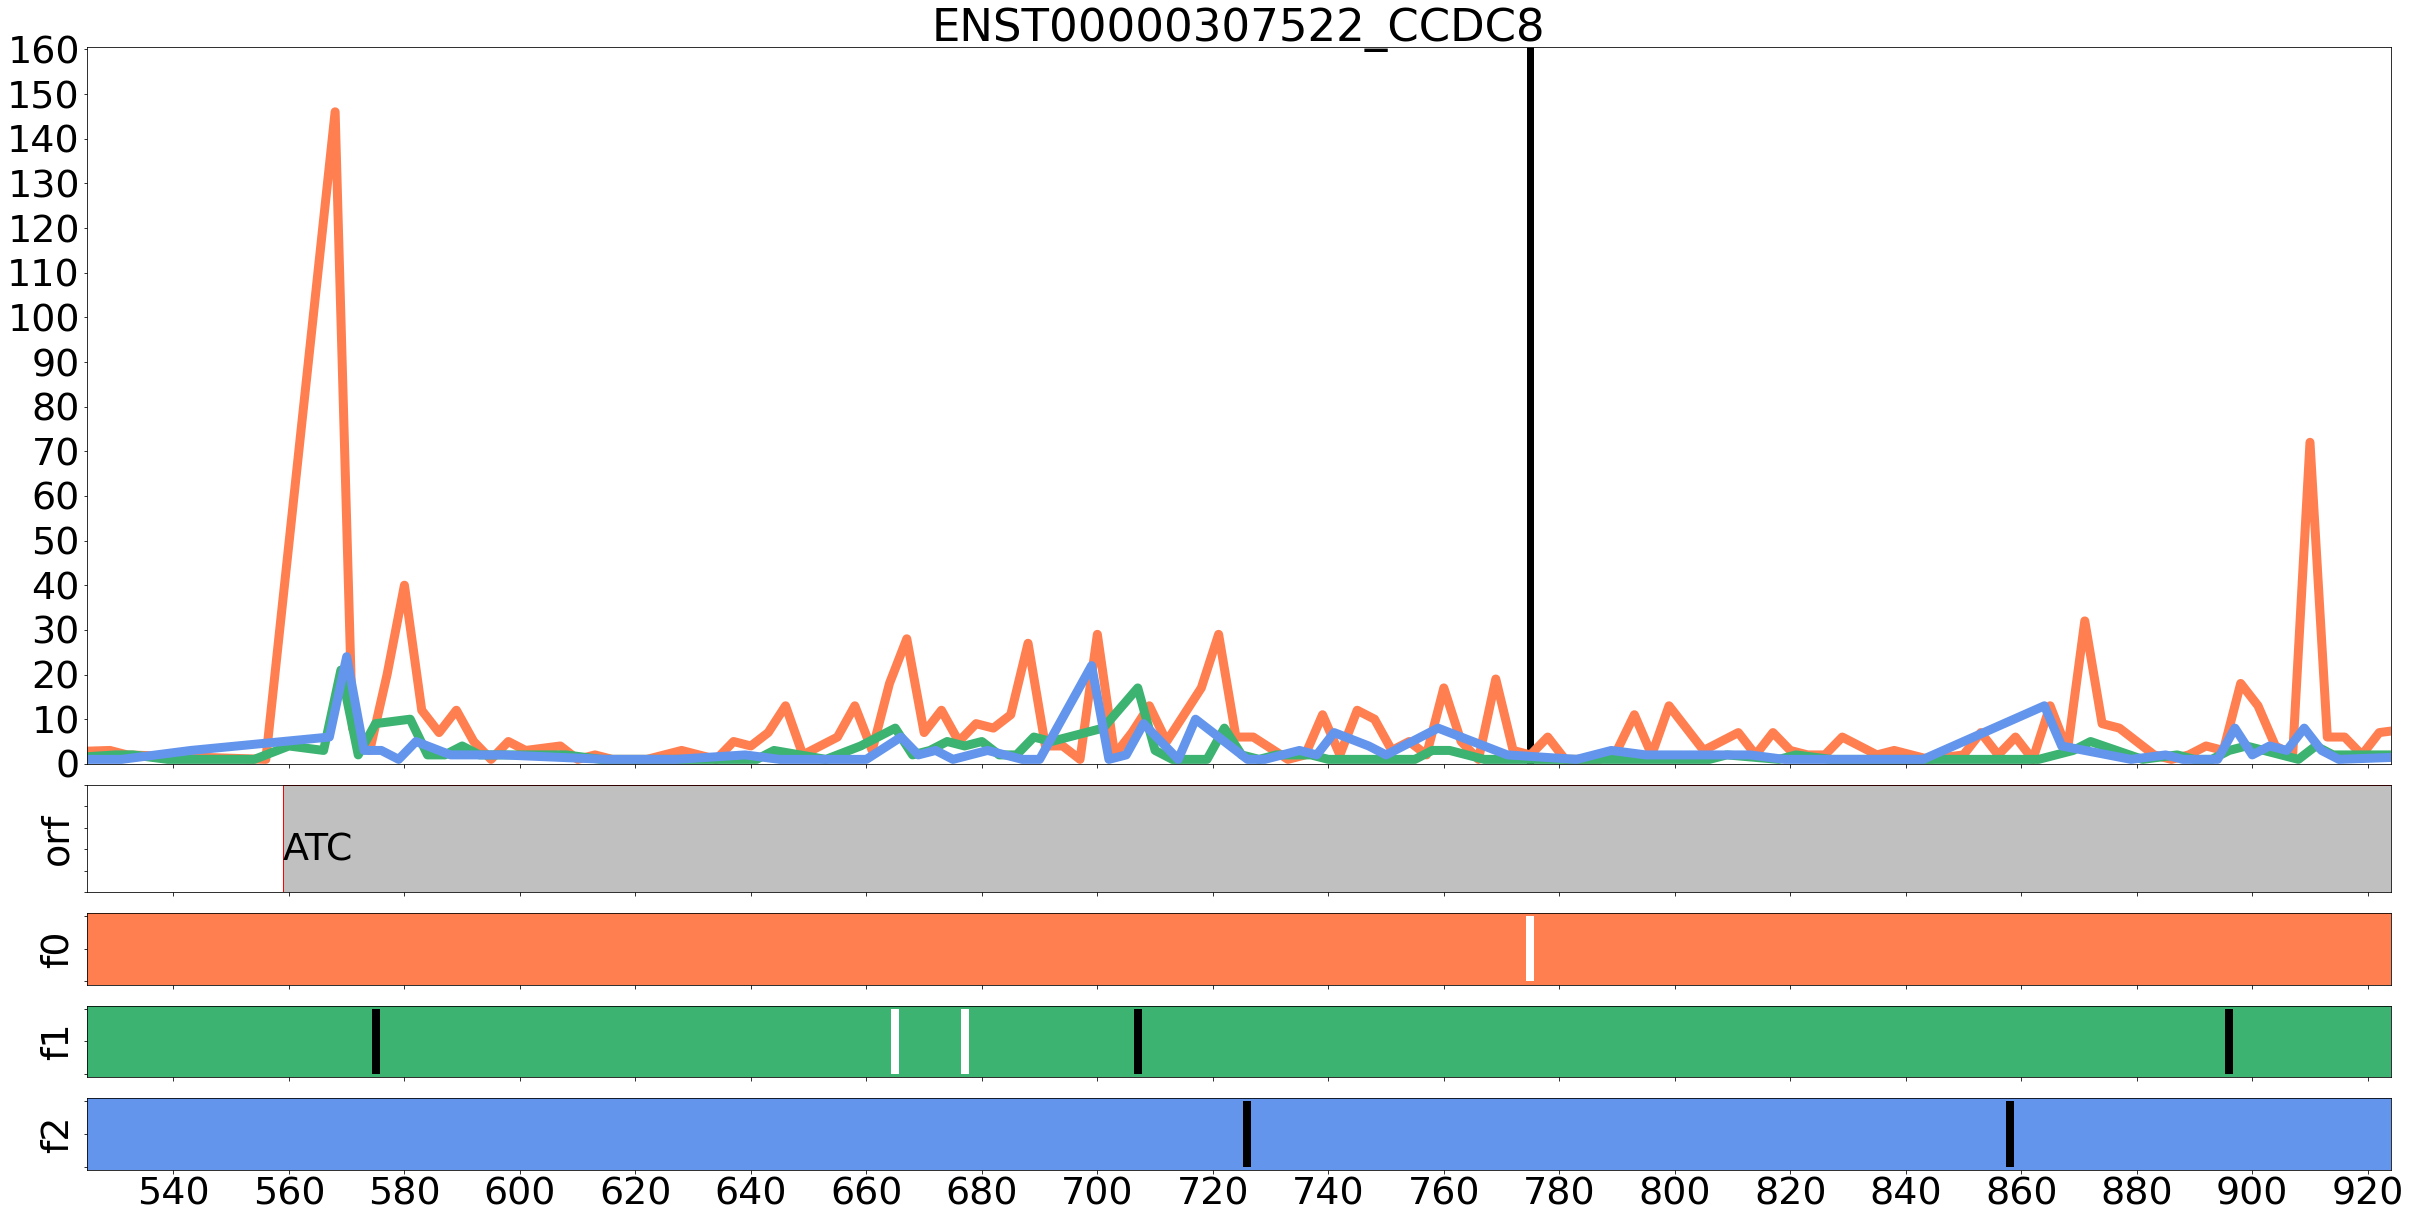

In [12]:
gene = 'CCDC8'

tr_id = 'ENST00000307522'


pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = pos_pred_start + '_' + pred_start

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 20, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

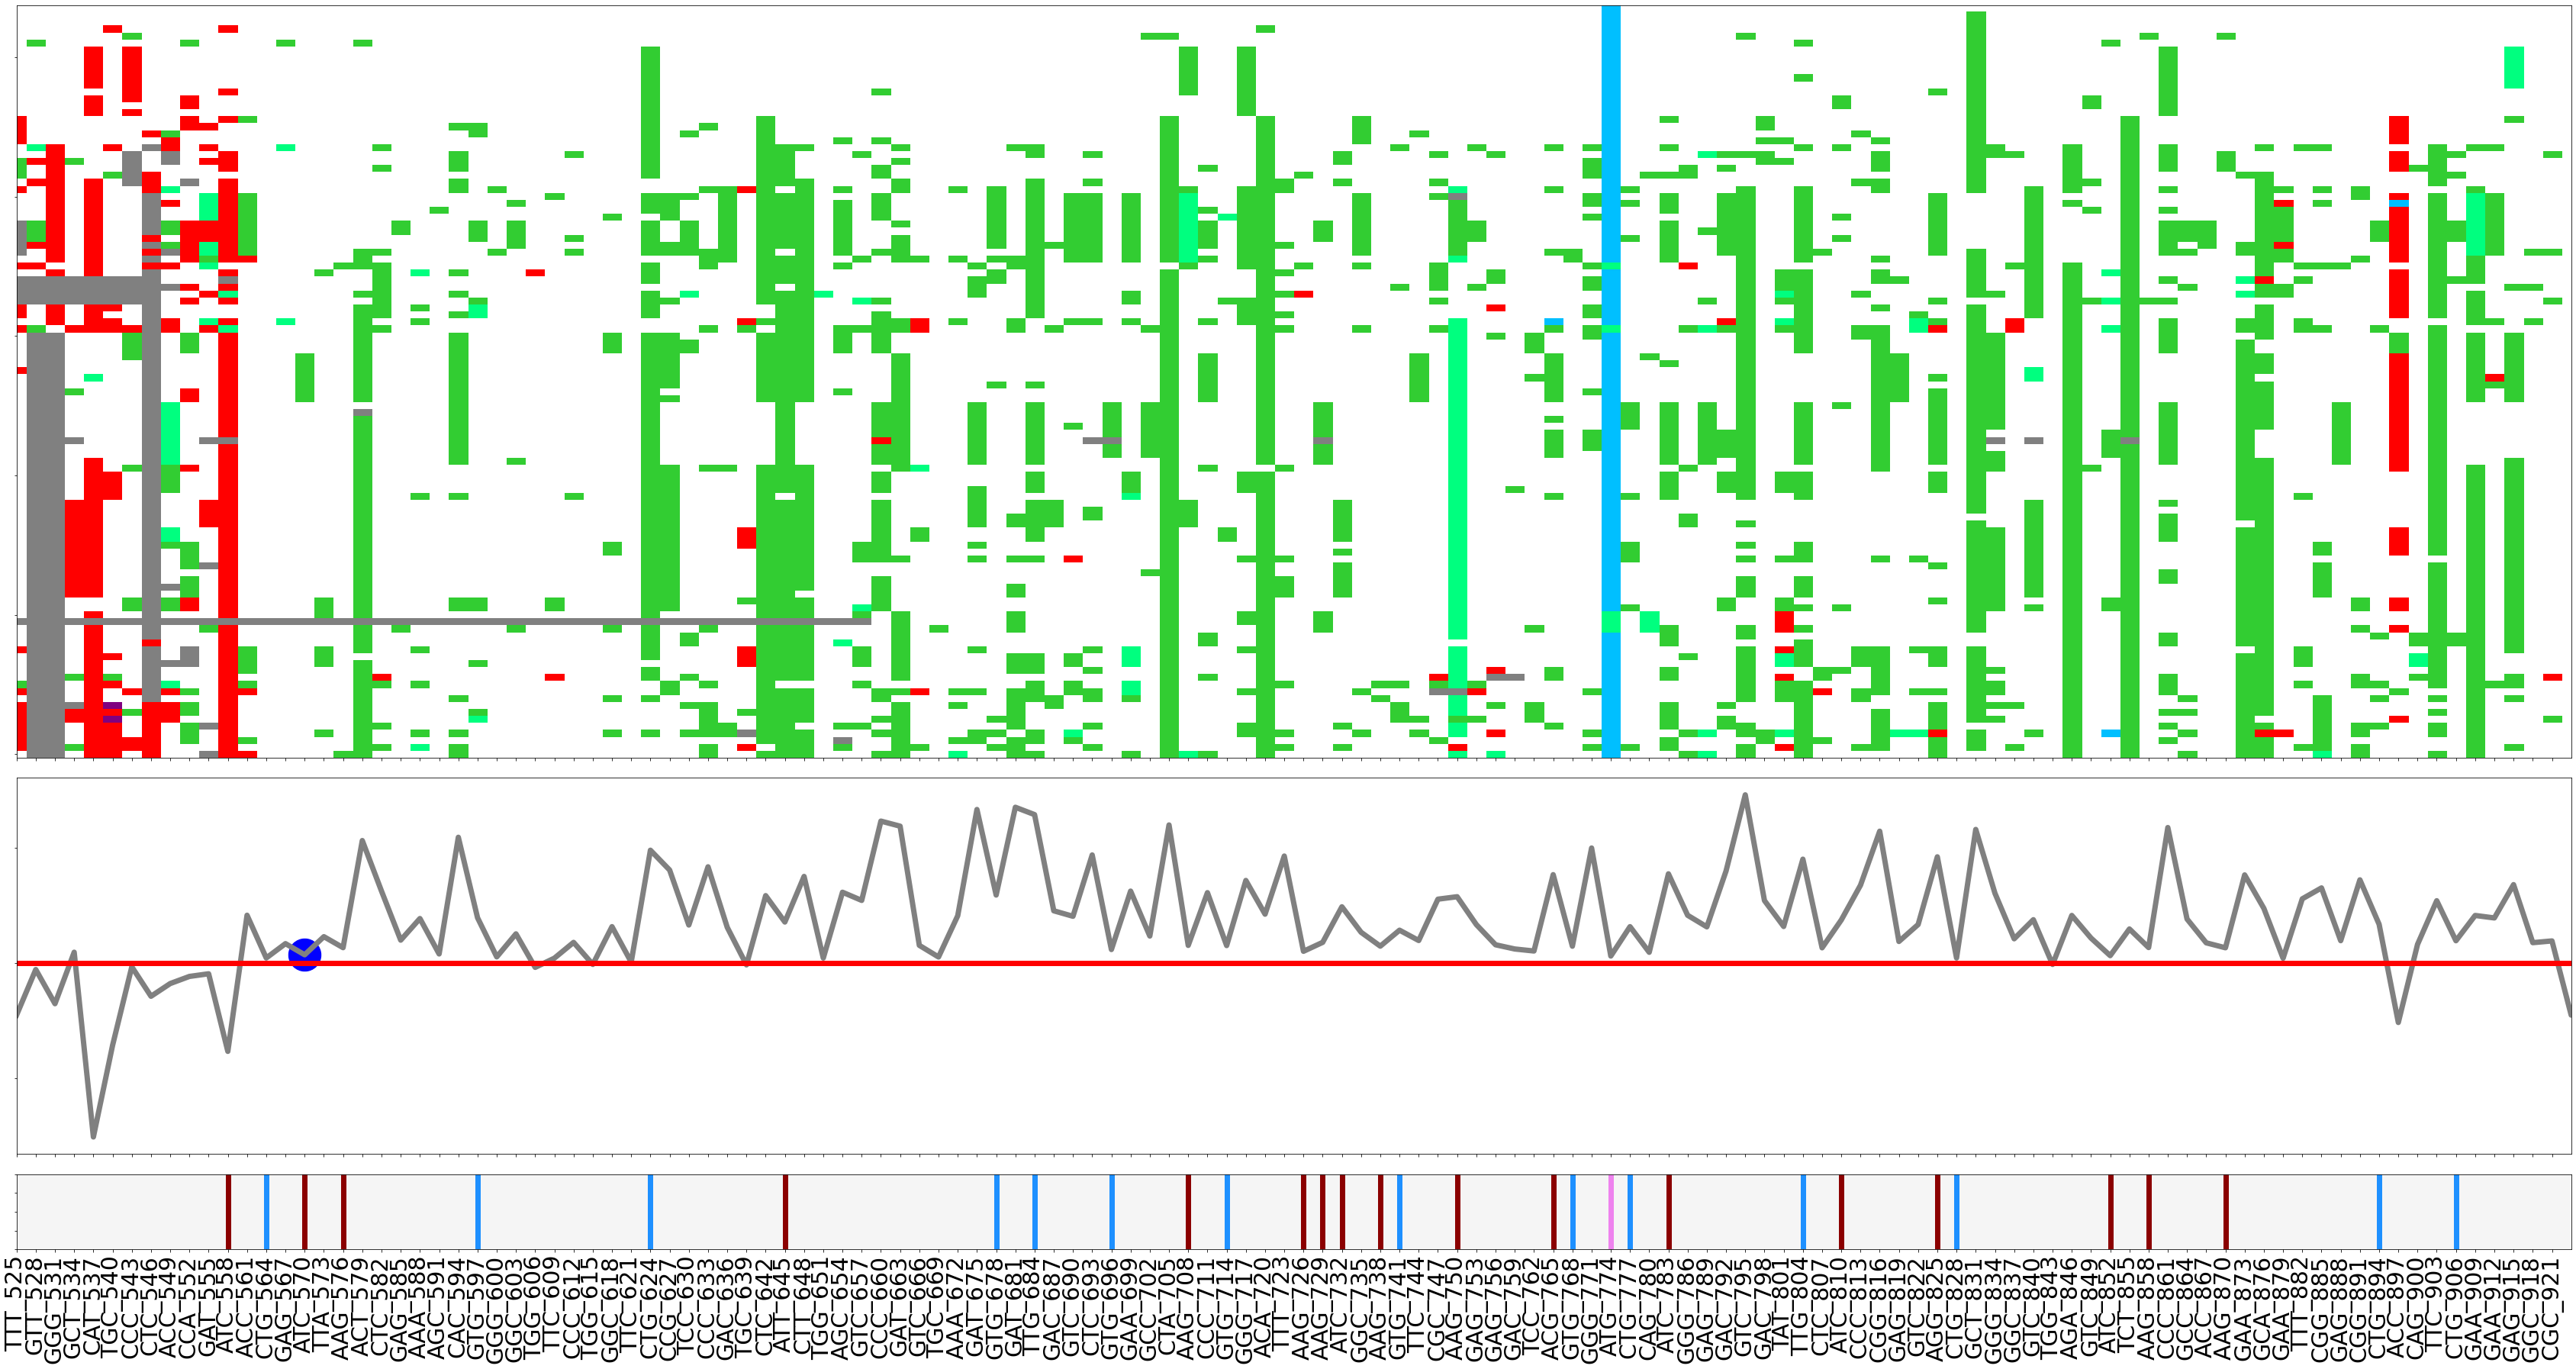

In [14]:
matrix = output_matrix_for_plotting(fasta_input='data/FASTA_aln_NTE_CDS_50codons/CCDC8_primary_and_50codons_CDS.fasta')

d =  prepare_data_for_PCSF_line_plot(tr_id='ENST00000307522.3', 
                                     primary_set=R_Set, 
                                     RES=RES, 
                                     res=res, 
                                     CDS=True)

plot_PCSF_score_and_aln_trips(d = d, 
                        matrix=matrix,
                figsize=(60, 30), 
                X=45, 
                Y=30, 
                add_point=15) # position of predicted by Trips-viz start in codons 

# Sole initiators discovery 

* a bit dirty, relatively unreliable and yet working way: comparison of initiation peaks height 
* more reliable => where NTE-coverage is equal or greater than CDS coverage

In [15]:
with open('data/out_df_frames_un_dict.pickle', 'rb') as handle:
    out_df_frames_un = pickle.load(handle)

In [16]:
li = []


for el in R_Set[['tr_id', 'gene', 'N_term_end1', 'pos_of_codon', 'codon', 'Coverage_value_ext', 'CDS_ratio']].merge(metadata_pc_g25[['tr_id', 'cds_start_pos', 'cds_stop_pos']], on='tr_id', how='inner').to_numpy():
    tr_id = el[0]
    gene = el[1]
    
    cds_start = el[-2] 
    cds_stop = el[-1]
    
    codon_start = el[3] # +1?  # nonAUG start 
    codon_type = el[4] # nonAUG start sequence 
    Coverage_value_ext = el[5]
    CDS_ratio = el[6]

   
    # CDS_ratio = Coverage_ext / Coverage_CDS, >= 1? 
    if cds_start % 3 == 0:
        frame = 'Frame 1'
    elif cds_start % 3 == 1:
        frame = 'Frame 2'
    else:
        frame = 'Frame 3'
        
    cds_frame = 'Frame %s' % (frame)
    
    # extract counts for that frame 
    counts = out_df_frames_un[tr_id.split('.')[0]][['Position', frame]]
    
    # extract NTE -3: +6nt 
    counts_around = counts[codon_start+3:codon_start+10+3] #1st 3 positions in out_df_frames_un -3,-2,-1 for some weird reason!
    
    # -3+6 around CDS
    counts_around_CDS = counts[cds_start+1+3:cds_start+6+1+3] # 1st 3 positions in out_df_frames_un -3,-2,-1 for some weird reason!
    
    # max value 
    height_peak_value = np.max(counts_around[frame].tolist())
    
    # max value CDS peak 
    height_peak_value_cds = np.max(counts_around_CDS[frame].tolist())
    
    ###### CDS coverage without init peak #######
    
    counts_CDS_wo_init = np.sum(counts[cds_start:cds_stop][frame].tolist()) - height_peak_value_cds
    coverage_CDS_wo_init = counts_CDS_wo_init / (cds_stop - cds_start - 1) #~mean
    counts_CDS_wo_init_array = counts[cds_start:cds_stop][frame].tolist()
    counts_CDS_wo_init_array.remove(height_peak_value_cds)
    

    std_CDS_wo_init = np.std(counts_CDS_wo_init_array)
    Z_CDS_wo_init = (height_peak_value_cds - coverage_CDS_wo_init) / std_CDS_wo_init

    
    # HEIGHT OF NTE PEAK vs CDS coverage, Z-score 
    Z_NTE = (height_peak_value - coverage_CDS_wo_init) / std_CDS_wo_init
    
    
    ############### CDS ratio calculation ######################
    coverage_CDS = np.sum(counts[cds_start:cds_stop][frame].tolist()) / (cds_stop - cds_start)
    
    coverage_NTE = np.sum(counts[codon_start:cds_start][frame].tolist()) / (cds_start - codon_start)
    
    
    CDS_nte_ratio_coverage = coverage_NTE / coverage_CDS
    ############################################################
    
    #if tr_id == 'ENST00000391418.3':
    
    li.append([tr_id, gene, codon_type, codon_start, cds_start, cds_stop, cds_frame, 
               height_peak_value, height_peak_value_cds, 
              counts_CDS_wo_init, coverage_CDS_wo_init, std_CDS_wo_init, Z_CDS_wo_init,  Z_NTE, 
              CDS_ratio, CDS_nte_ratio_coverage])

In [17]:
sole_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'codon_type', 'codon_start', 'cds_start', 'cds_stop', 
                                 'cds_frame', 'height_peak_value_nonAUG','height_peak_value_cds', 
              'counts_CDS_wo_init', 'coverage_CDS_wo_init', 'std_CDS_wo_init', 'Z_CDS_wo_init', 'Z_NTE',
                                     'CDS_ratio', 'CDS_nte_ratio_coverage'])

sole_df[0:2]    

tr_id    gene codon_type  codon_start  cds_start  cds_stop  \
0   ENST00000379389.4   ISG15        ATC           97        151       649   
1  ENST00000349431.10  UBE2J2        ACG          172        220      1000   

       cds_frame  height_peak_value_nonAUG  height_peak_value_cds  \
0  Frame Frame 2                       548                   2875   
1  Frame Frame 2                      1001                    881   

   counts_CDS_wo_init  coverage_CDS_wo_init  std_CDS_wo_init  Z_CDS_wo_init  \
0               44294             89.122736       205.714212      13.542464   
1               25762             33.070603        73.522076      11.532990   

       Z_NTE  CDS_ratio  CDS_nte_ratio_coverage  
0   2.230654   0.327240                0.292685  
1  13.165153   0.762814                1.470508

In [18]:
genes_sole_1 = sole_df[(sole_df['Z_CDS_wo_init'] < 1) &  # 26
         (sole_df['Z_NTE'] > 1) & (sole_df['coverage_CDS_wo_init'] > 1)].gene.tolist()

genes_sole_2 = sole_df[(sole_df['Z_CDS_wo_init'] < 1) & 
         (sole_df['Z_NTE'] > 1) &
                     (sole_df['CDS_nte_ratio_coverage'] >= 0.9) & (sole_df['coverage_CDS_wo_init'] > 1)].gene.tolist() # 14

', '.join(list(set(genes_sole_1) - set(genes_sole_2)))

'RHOB, MGEA5, ADAM15, ZIC2, PIEZO1, IGF2R, CAPRIN1, AMFR, RAB14, HNRNPR, KPNA1, LAMC1, CRELD2, FXR2, RAE1'

In [19]:
sole_df_sel = sole_df[(sole_df['Z_CDS_wo_init'] < 1) & 
         (sole_df['Z_NTE'] > 1) &
                     (sole_df['CDS_nte_ratio_coverage'] >= 0.9) & (sole_df['coverage_CDS_wo_init'] > 1)].sort_values(by='Z_CDS_wo_init')[['tr_id', 'gene', 'codon_start', 'codon_type', 'cds_start', 'Z_CDS_wo_init', 'Z_NTE', 
                                                                                                  'height_peak_value_nonAUG','height_peak_value_cds', 'CDS_ratio',
                                                                                                 'CDS_nte_ratio_coverage']]


print (sole_df_sel.shape[0], sole_df_sel.gene.nunique())
sole_df_sel[0:2]

13 13


tr_id     gene  codon_start codon_type  cds_start  \
58  ENST00000234115.10  PLEKHB2          415        ATC        463   
66   ENST00000341772.4     DNER          102        CTG        135   

    Z_CDS_wo_init      Z_NTE  height_peak_value_nonAUG  height_peak_value_cds  \
58      -0.348650  11.768322                      1482                     10   
66      -0.256842   5.982218                       315                      2   

    CDS_ratio  CDS_nte_ratio_coverage  
58   1.227975                1.052199  
66   0.199931                0.920532

In [20]:
sole_df[sole_df['gene'] == 'SLC19A2']

tr_id     gene codon_type  codon_start  cds_start  cds_stop  \
37  ENST00000236137.9  SLC19A2        CTG          123        237      1731   

        cds_frame  height_peak_value_nonAUG  height_peak_value_cds  \
37  Frame Frame 1                      1194                    298   

    counts_CDS_wo_init  coverage_CDS_wo_init  std_CDS_wo_init  Z_CDS_wo_init  \
37               11774              7.886135        21.328054      13.602453   

        Z_NTE  CDS_ratio  CDS_nte_ratio_coverage  
37  55.612849   0.739155                2.277571

# Plot exclusive nonAUG examples 

## 'troubled ones': which do not have NTE_cov/CDS_cov >= 0.9

NTE/CDS cov: 2.28 Z-score: 55.61
---
SLC19A2 ENST00000236137.9
---
124_CTG
1194
0


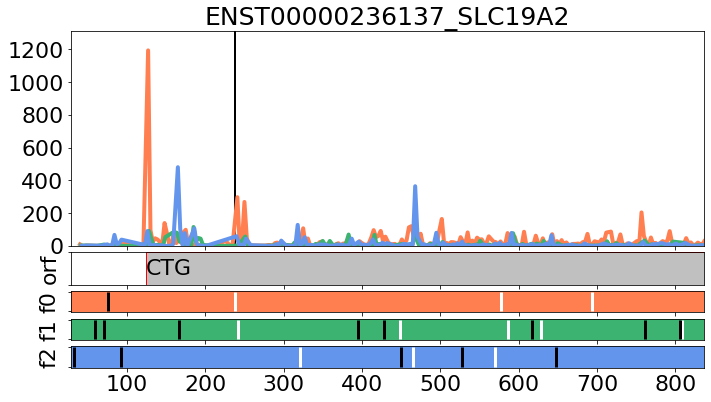

In [21]:
tmp = sole_df[sole_df['gene'] == 'SLC19A2'].iloc[0]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE/CDS cov:', np.round(tmp.CDS_nte_ratio_coverage, 2), 
       'Z-score:', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene, tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-50, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+200*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 100, 
                             cds = False,
                           linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SLC19A2.png', font1=22, font2=25)

NTE/CDS cov: 0.21 Z-score: 2.74
---
RHOB ENST00000272233.5
---
324_GTG
3222
0


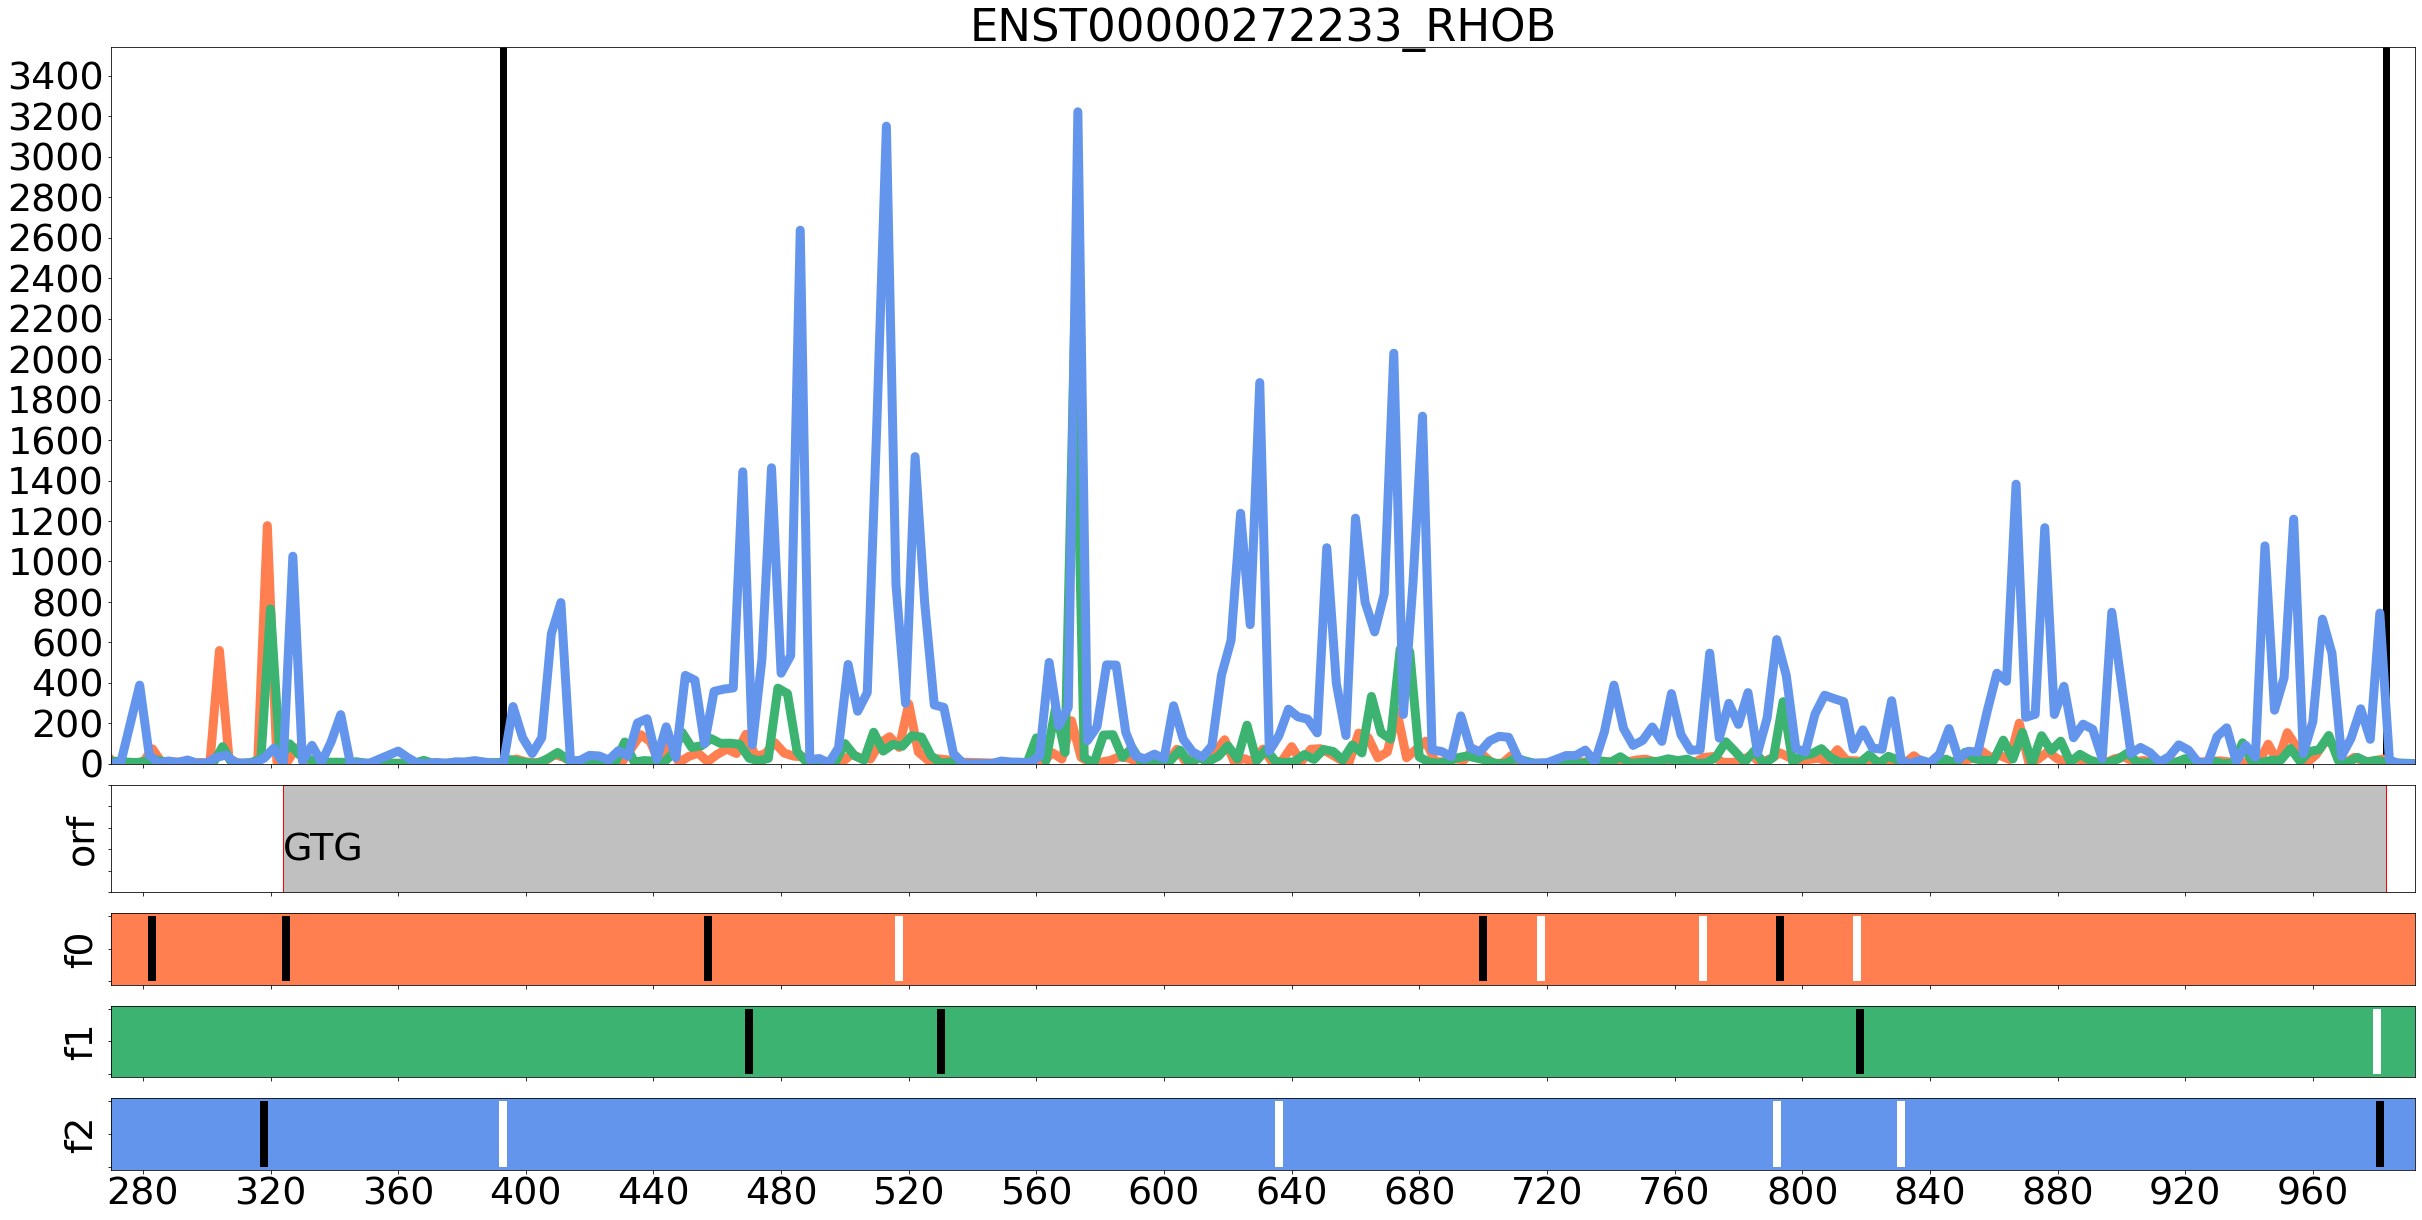

In [22]:
tmp = sole_df[sole_df['gene'].isin(list(set(genes_sole_1) - set(genes_sole_2)))].iloc[3]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE/CDS cov:', np.round(tmp.CDS_nte_ratio_coverage, 2), 
       'Z-score:', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene, tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-50, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+200*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 40, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

In [23]:
out_df_frames_un['ENST00000341394'][60:71]

Position  Frame 1  Frame 2  Frame 3 Sequence rna_seq
60        60        0        0        0        C    None
61        61       16        0        0        T    None
62        62        0        4        0        C    None
63        63        0        0        3        T    None
64        64        0        0        0        C    None
65        65        0        5        0        G    None
66        66        0        0        2        G    None
67        67        0        0        0        T    None
68        68        0        0        0        G    None
69        69        0        0       22        C    None
70        70      599        0        0        A    None

---------

In [ ]:
tmp = sole_df[sole_df['gene'].isin(list(set(genes_sole_1) - set(genes_sole_2)))].iloc[8]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+','+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-50, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+200*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 40, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

In [ ]:
tmp = sole_df[sole_df['gene'].isin(list(set(genes_sole_1) - set(genes_sole_2)))].iloc[0]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-10, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 40, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

In [ ]:
tmp = sole_df[sole_df['gene'].isin(list(set(genes_sole_1) - set(genes_sole_2)))].iloc[-3]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

=================================================================================================================

=================================================================================================================

# Reliable ones (all 14!!!)

# PLEKHB2,ENST00000234115.10

In [9]:
tmp = sole_df_sel.iloc[0]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 100, 
                             cds = False,
                             linew=4, 
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test.png', font1=20, font2=25)

NameError: name 'sole_df_sel' is not defined

# DNER, ENST00000341772.4

NTE_CDS_ratio=0.92; Z-score= 5.98
---
DNER, ENST00000341772.4
---
103_CTG
552
0


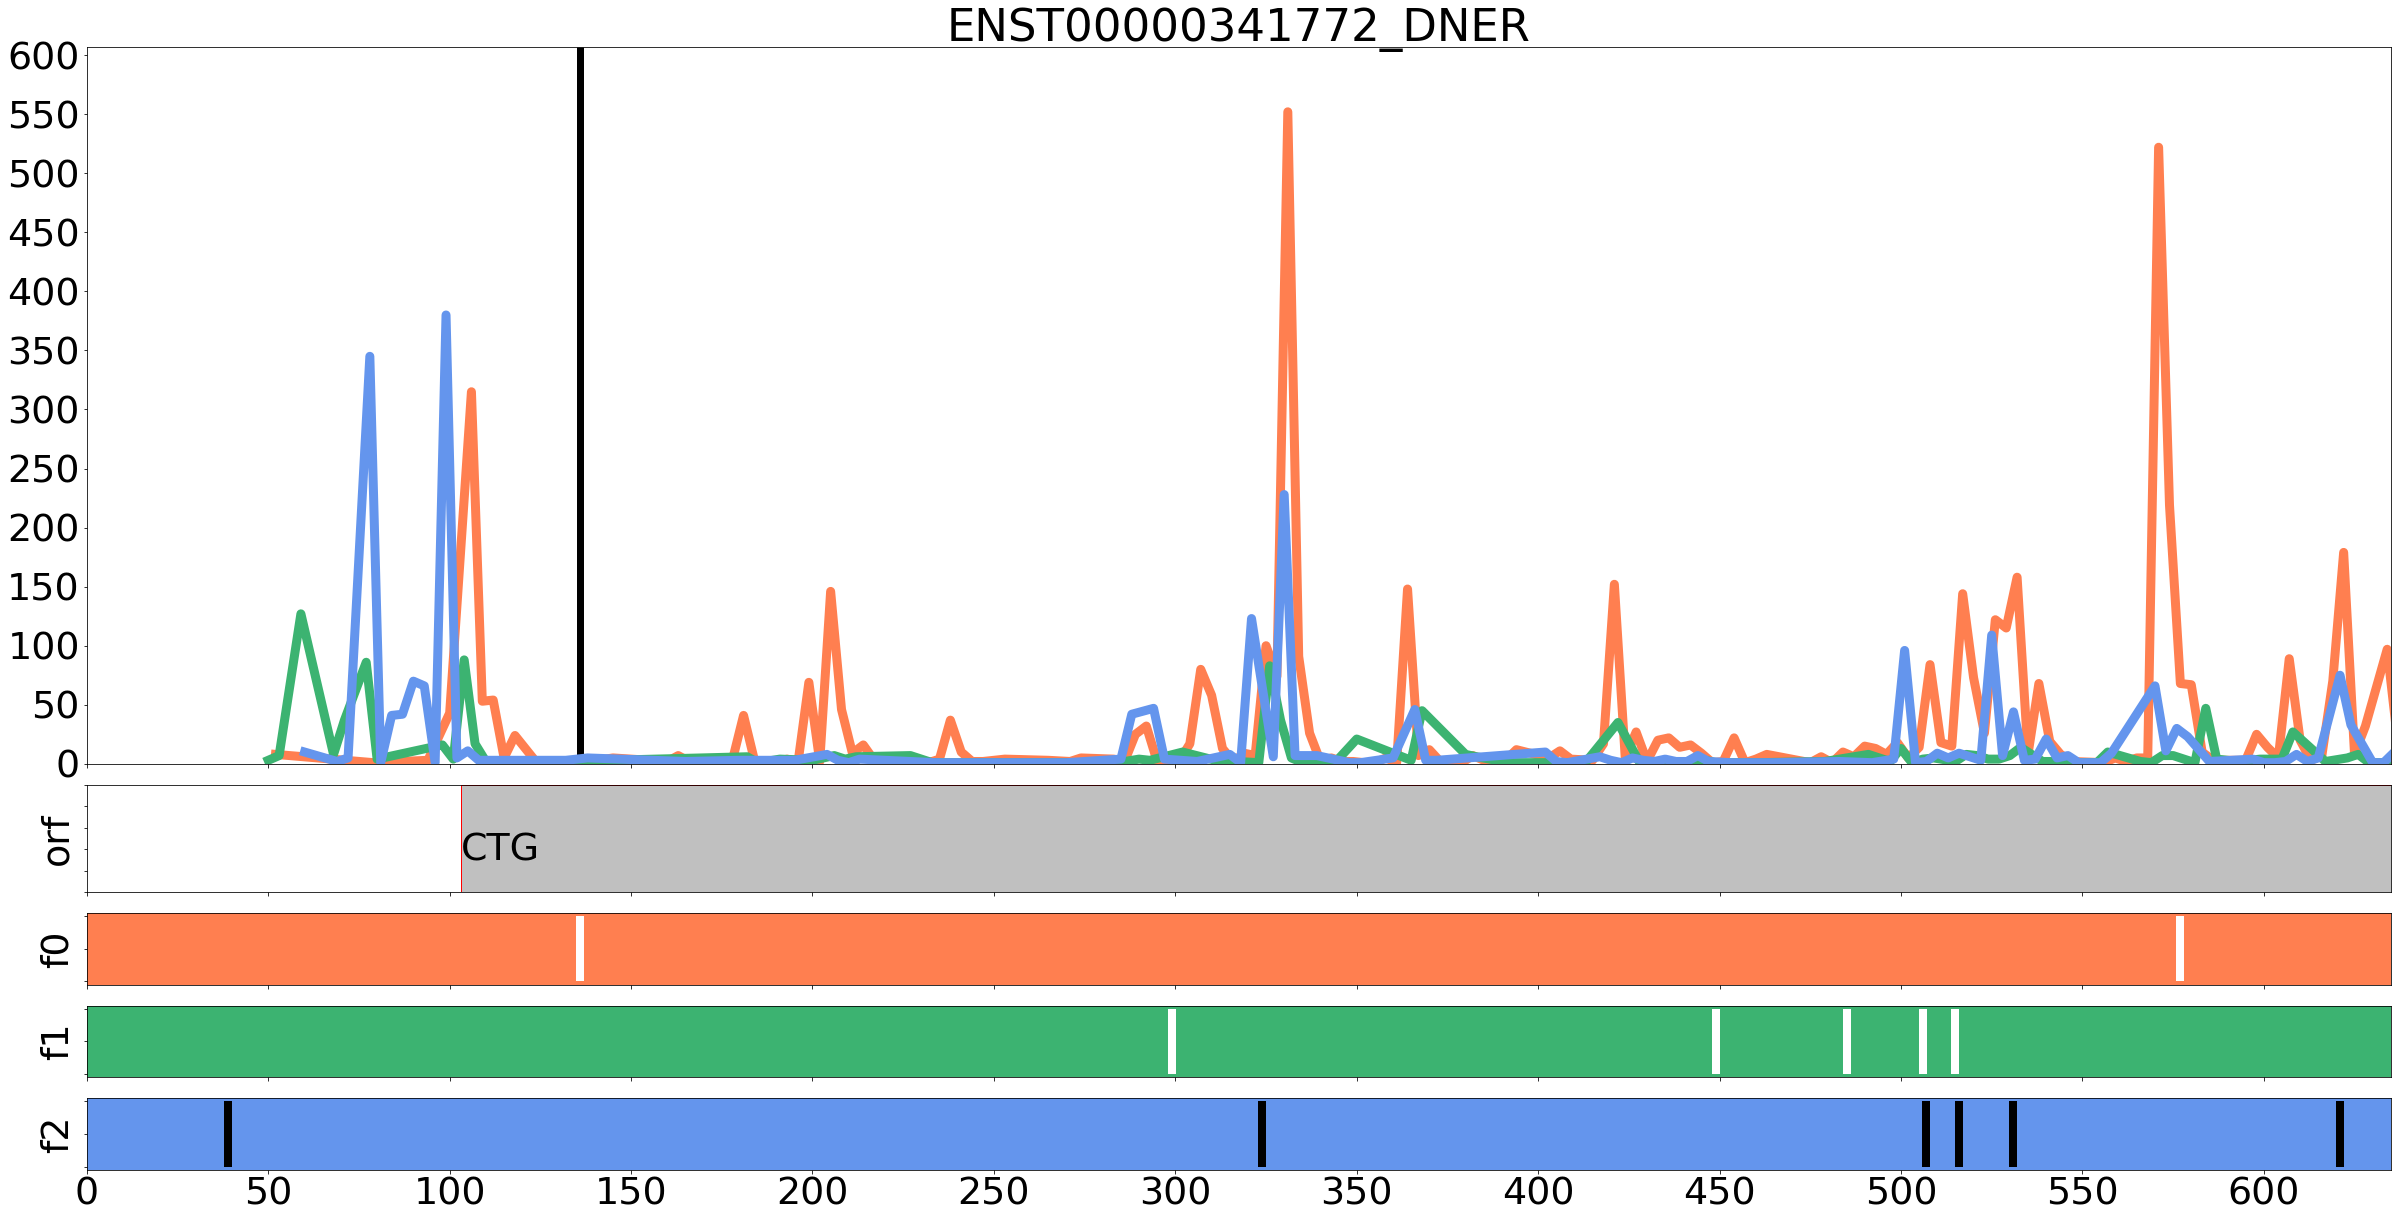

In [18]:
tmp = sole_df_sel.iloc[1]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]
    
#xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         #metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos+30]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq =50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

In [23]:
sole_df_sel.iloc[2]

tr_id                       ENST00000297578.8
gene                                 SLC25A32
codon_start                                29
codon_type                                TTG
cds_start                                 167
Z_CDS_wo_init                       -0.242497
Z_NTE                                3.338496
height_peak_value_nonAUG                  309
height_peak_value_cds                      14
CDS_ratio                            0.776933
CDS_nte_ratio_coverage               1.259314
Name: 172, dtype: object

# SLC25A32, ENST00000297578.8

NTE_CDS_ratio=1.26; Z-score= 3.34
---
SLC25A32, ENST00000297578.8
---
30_TTG
2579
0


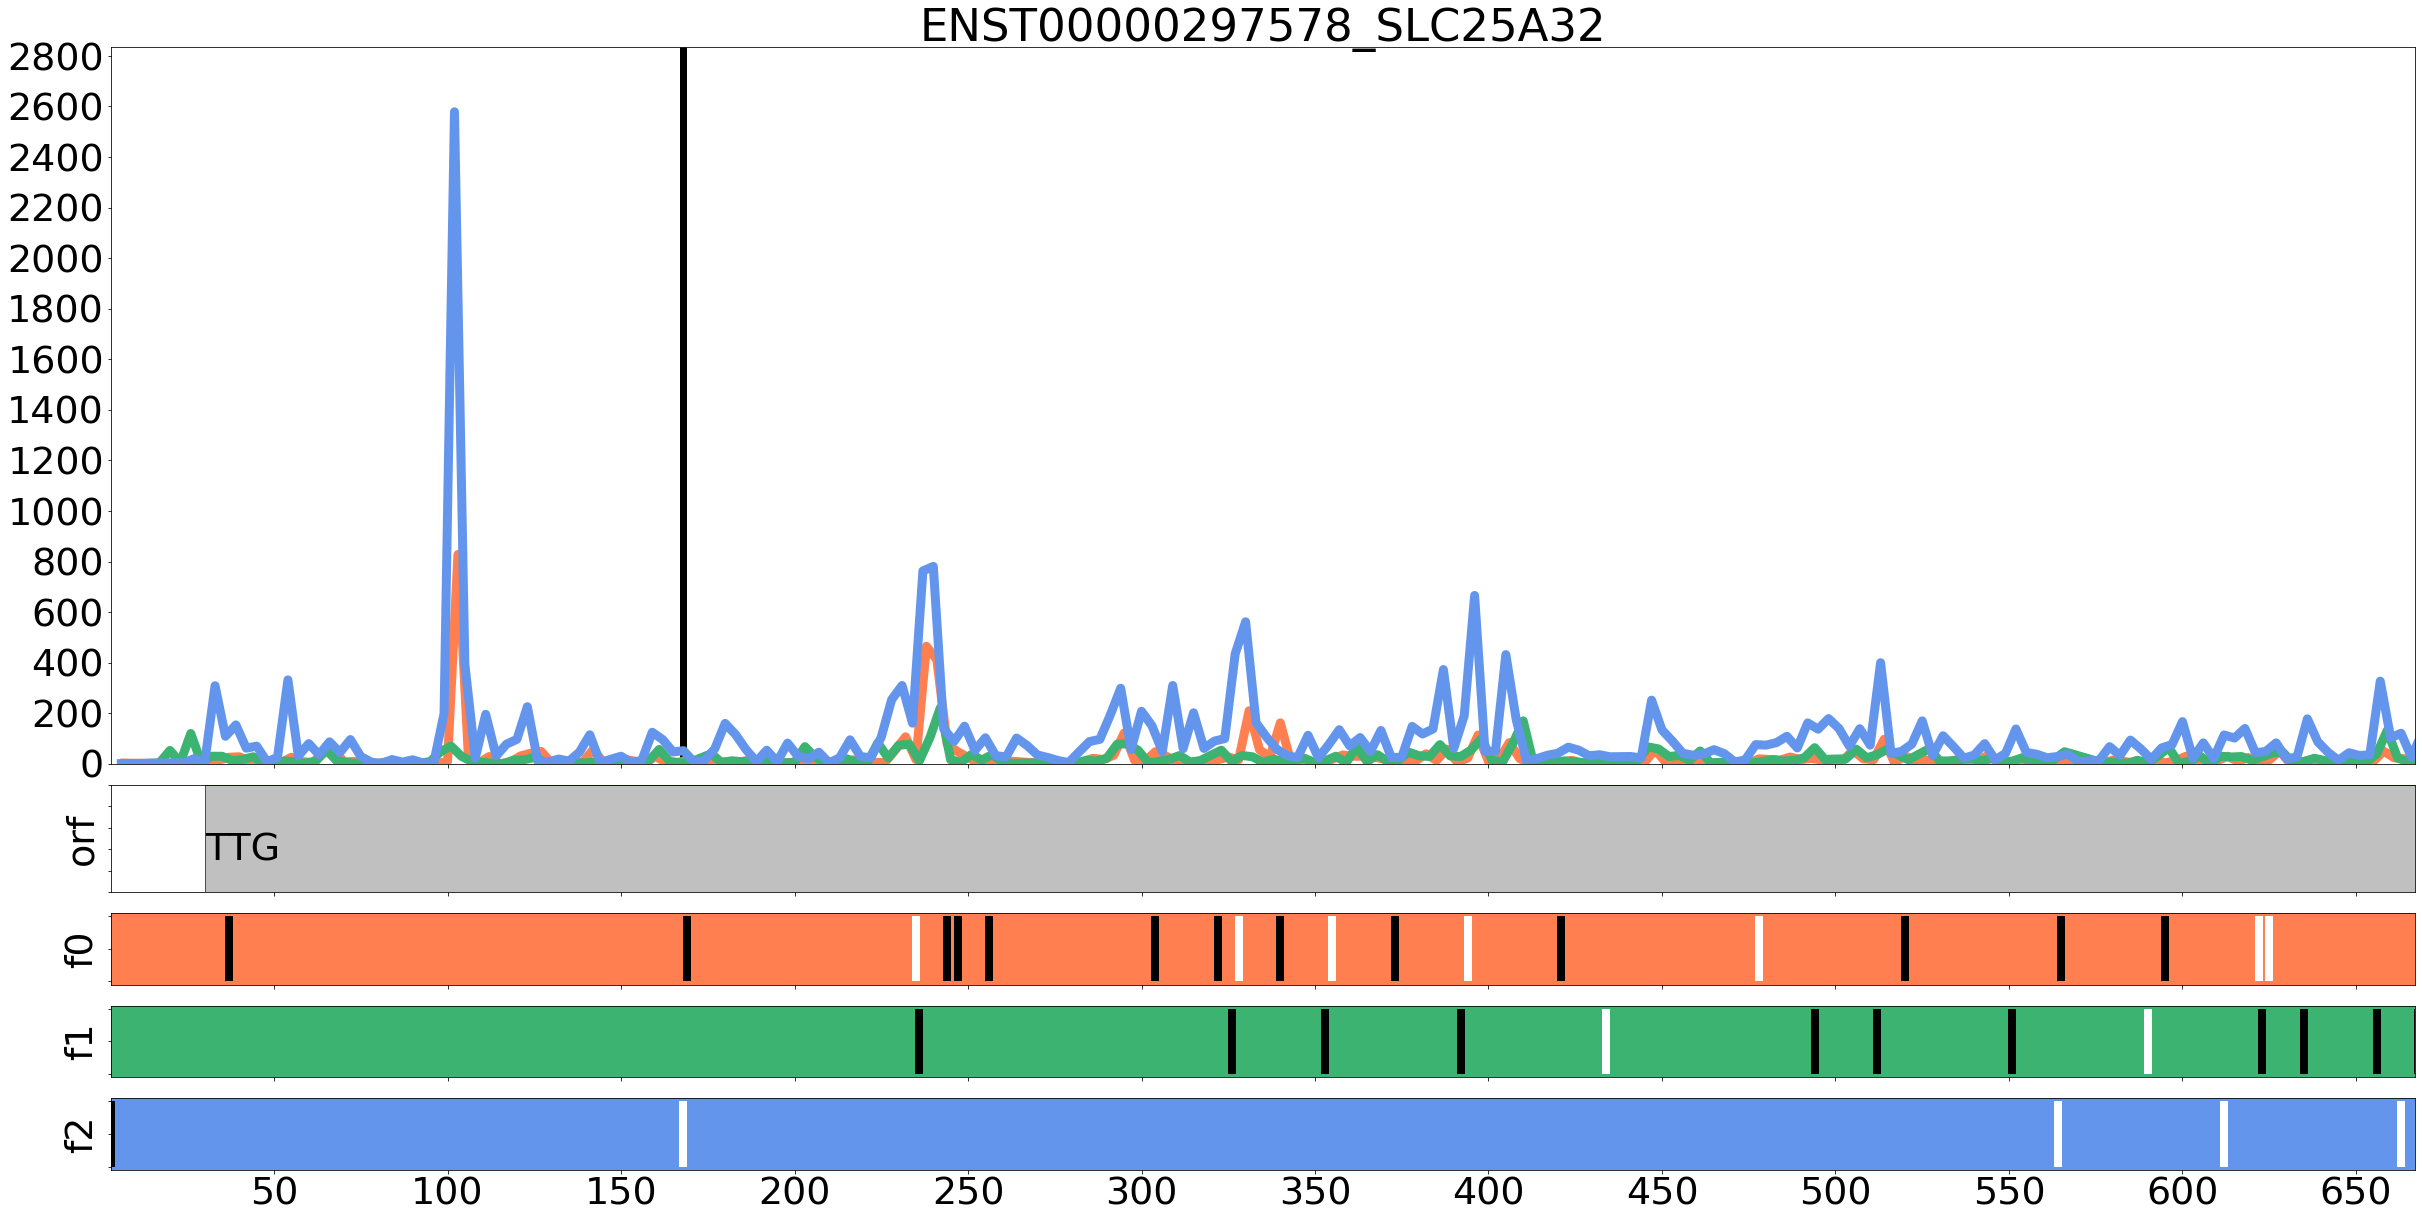

In [19]:
tmp = sole_df_sel.iloc[2]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-2, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

In [25]:
meta[meta['tr_id'] == 'ENST00000297578.8'].iloc[0][['gene', 'ovlp', 'ovlp_strandless']]

gene                SLC25A32
ovlp                   0;0;0
ovlp_strandless    109;109;0
Name: 31949, dtype: object

In [26]:
sole_df_sel.iloc[3] 

tr_id                       ENST00000355415.6
gene                                   MFSD12
codon_start                               113
codon_type                                CTG
cds_start                                 170
Z_CDS_wo_init                       -0.146652
Z_NTE                               23.645427
height_peak_value_nonAUG                 1642
height_peak_value_cds                      12
CDS_ratio                            0.515025
CDS_nte_ratio_coverage               1.783026
Name: 335, dtype: object

# MFSD12, ENST00000355415.6

NTE_CDS_ratio=1.78; Z-score= 23.65
---
MFSD12, ENST00000355415.6
---
114_CTG
1642
0


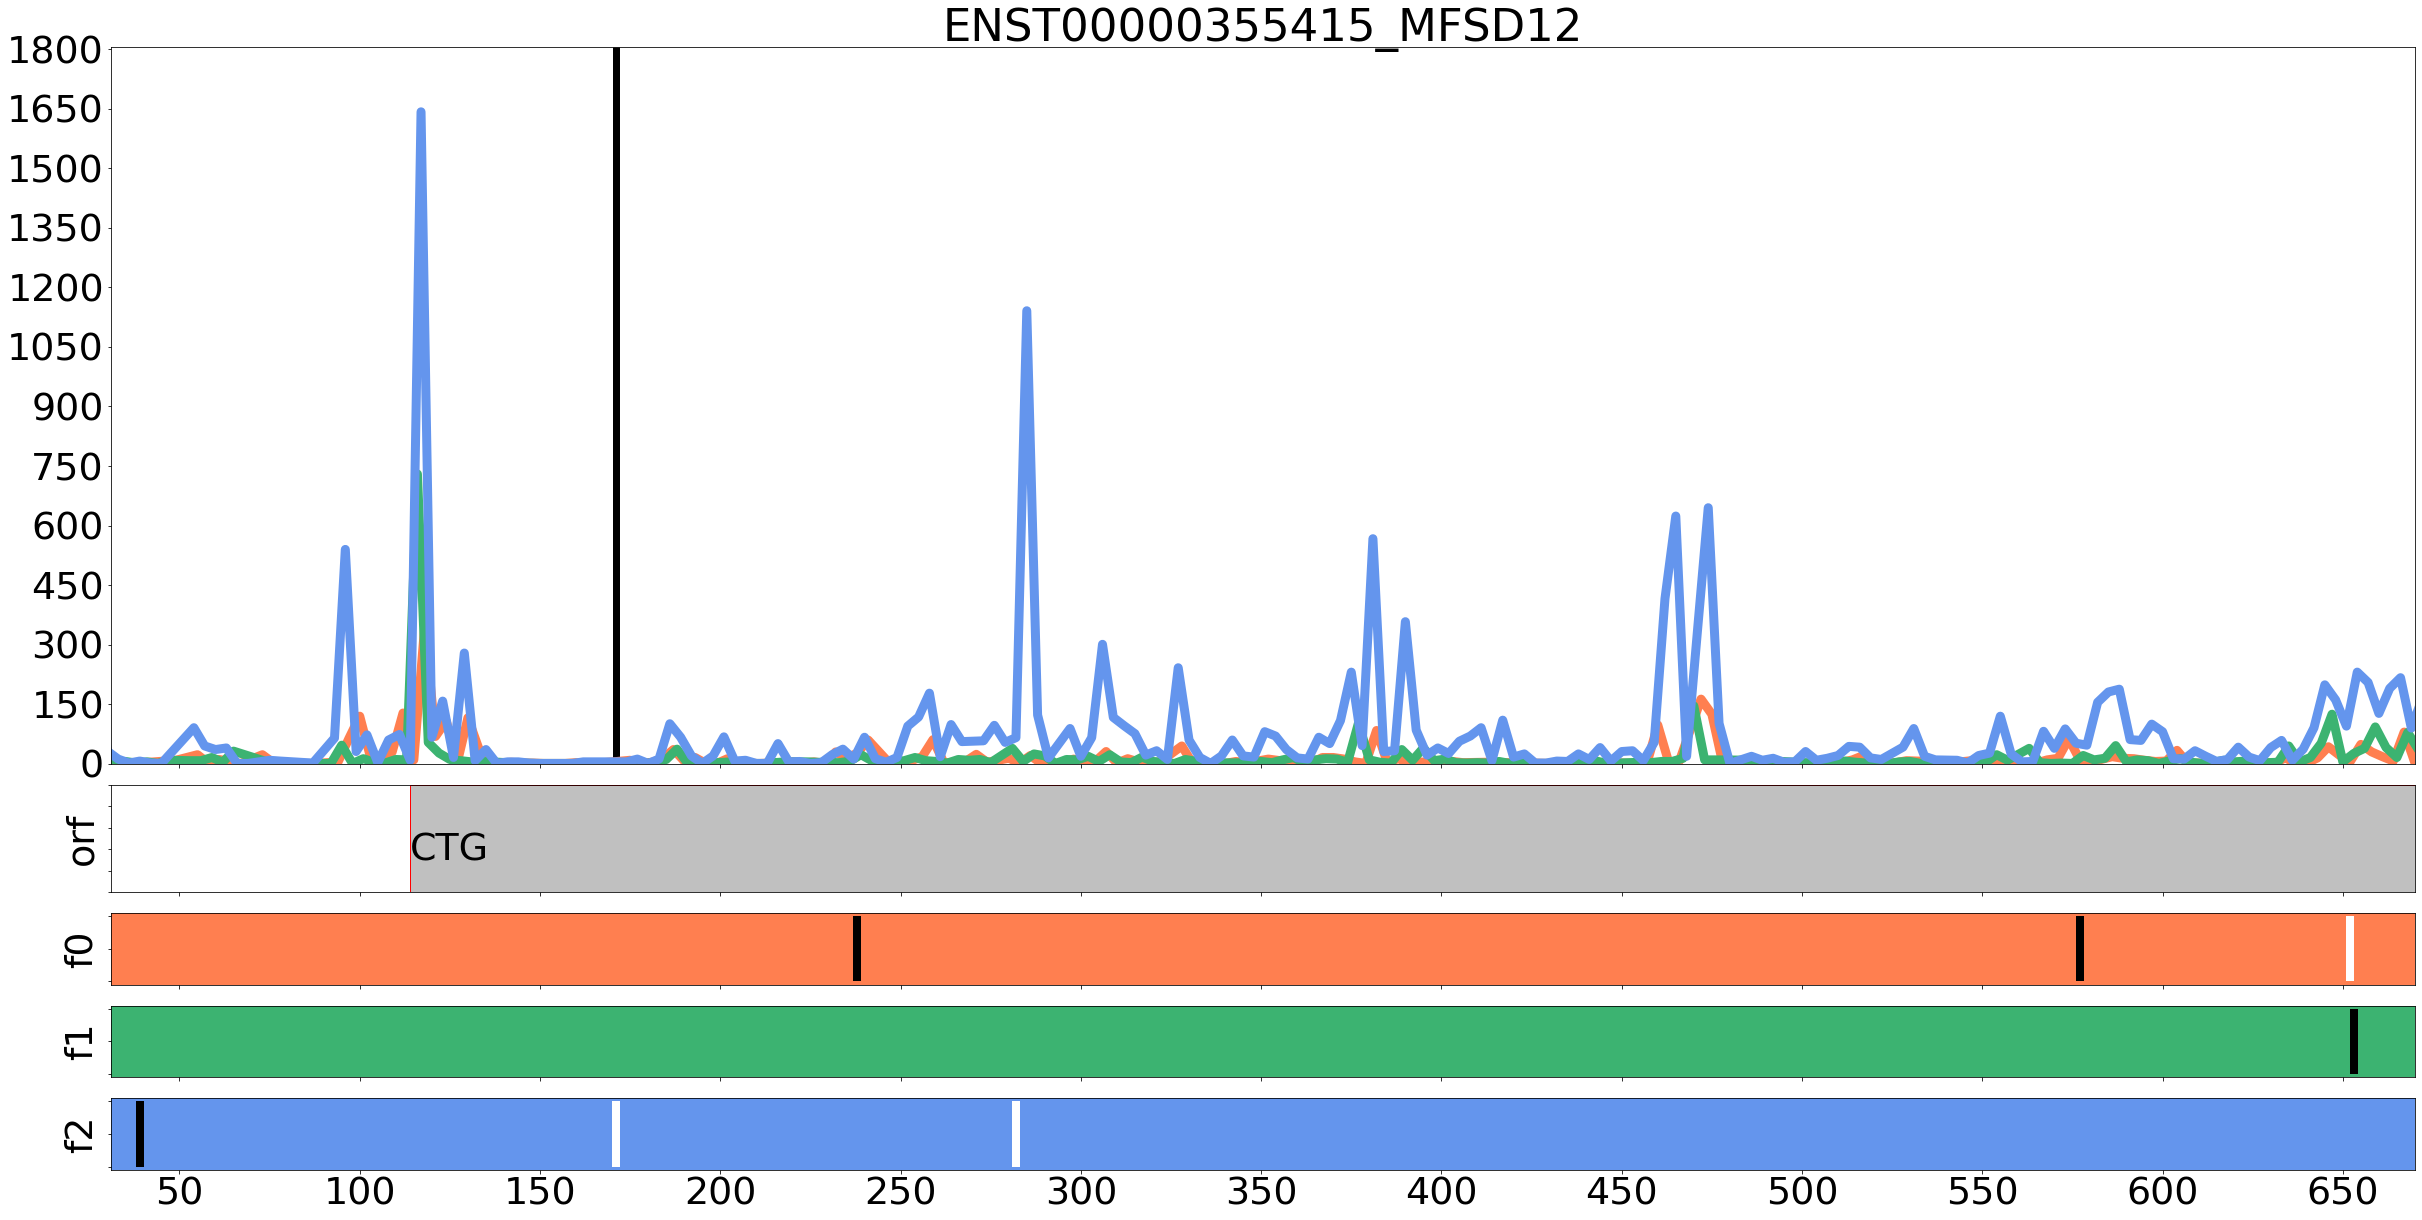

In [20]:
tmp = sole_df_sel.iloc[3]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-10, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =150, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

# MARVELD, ENST00000285605.7

NTE_CDS_ratio=1.36; Z-score= 20.1
---
MARVELD1, ENST00000285605.7
---
106_ATT
947
0


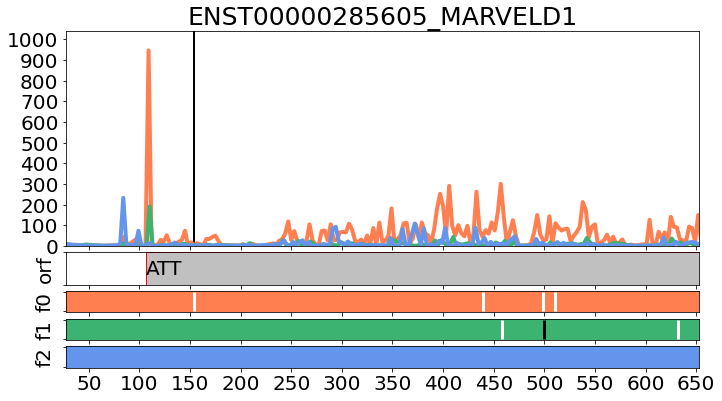

In [21]:
tmp = sole_df_sel.iloc[4]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                             linew=4,
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test.png', font1=20, font2=25)

In [29]:
sole_df_sel.iloc[5]

tr_id                       ENST00000307741.10
gene                                     THOP1
codon_start                                143
codon_type                                 GTG
cds_start                                  203
Z_CDS_wo_init                         0.119801
Z_NTE                                 17.10772
height_peak_value_nonAUG                  1034
height_peak_value_cds                       32
CDS_ratio                             0.470349
CDS_nte_ratio_coverage                1.157575
Name: 334, dtype: object

In [30]:
sole_df_sel

tr_id      gene  codon_start codon_type  cds_start  \
58   ENST00000234115.10   PLEKHB2          415        ATC        463   
66    ENST00000341772.4      DNER          102        CTG        135   
172   ENST00000297578.8  SLC25A32           29        TTG        167   
335   ENST00000355415.6    MFSD12          113        CTG        170   
197   ENST00000285605.7  MARVELD1          105        ATT        153   
334  ENST00000307741.10     THOP1          143        GTG        203   
136   ENST00000229812.7     STK38          220        CTG        286   
178   ENST00000239316.4     INSL4           66        AGG        105   
366   ENST00000215882.9   SLC25A1          106        CTG        157   
34    ENST00000368216.8    RRNAD1          570        CTG        630   
346   ENST00000307522.3     CCDC8          558        ATC        774   
189   ENST00000372642.4     ENDOG           76        TTG        211   
260   ENST00000299565.9    CHRNA5          119        GTG        200   

     Z_CDS_wo_init      Z_NTE  height_peak_value_nonAUG  \
58       -0.348650  11.768322                      1482   
66       -0.256842   5.982218                       315   
172      -0.242497   3.338496                       309   
335      -0.146652  23.645427                      1642   
197      -0.107277  20.104651                       947   
334       0.119801  17.107720                      1034   
136       0.198121  34.664063                      1776   
178       0.521603  63.727754                      1404   
366       0.587173   9.384896                       869   
34        0.694998  29.896283                       335   
346       0.801949  26.933742                       146   
189       0.833169   9.433802                       523   
260       0.844821  19.236913                       808   

     height_peak_value_cds  CDS_ratio  CDS_nte_ratio_coverage  
58                      10   1.227975                1.052199  
66                       2   0.199931                0.920532  
172                     14   0.776933                1.259314  
335                     12   0.515025                1.783026  
197                     14   0.183558                1.357175  
334                     32   0.470349                1.157575  
136                     31   0.162683                1.570308  
178                     19   4.399558                5.079189  
366                     78   0.865603                1.485496  
34                      11   2.058272                2.828274  
346                      6   1.008110                1.831506  
189                     64   1.016179                1.294641  
260                     50   0.801688                1.006696

# THOP1, ENST00000307741.10	

NTE_CDS_ratio=1.16; Z-score= 17.11
---
THOP1, ENST00000307741.10
---
144_GTG
1034
0


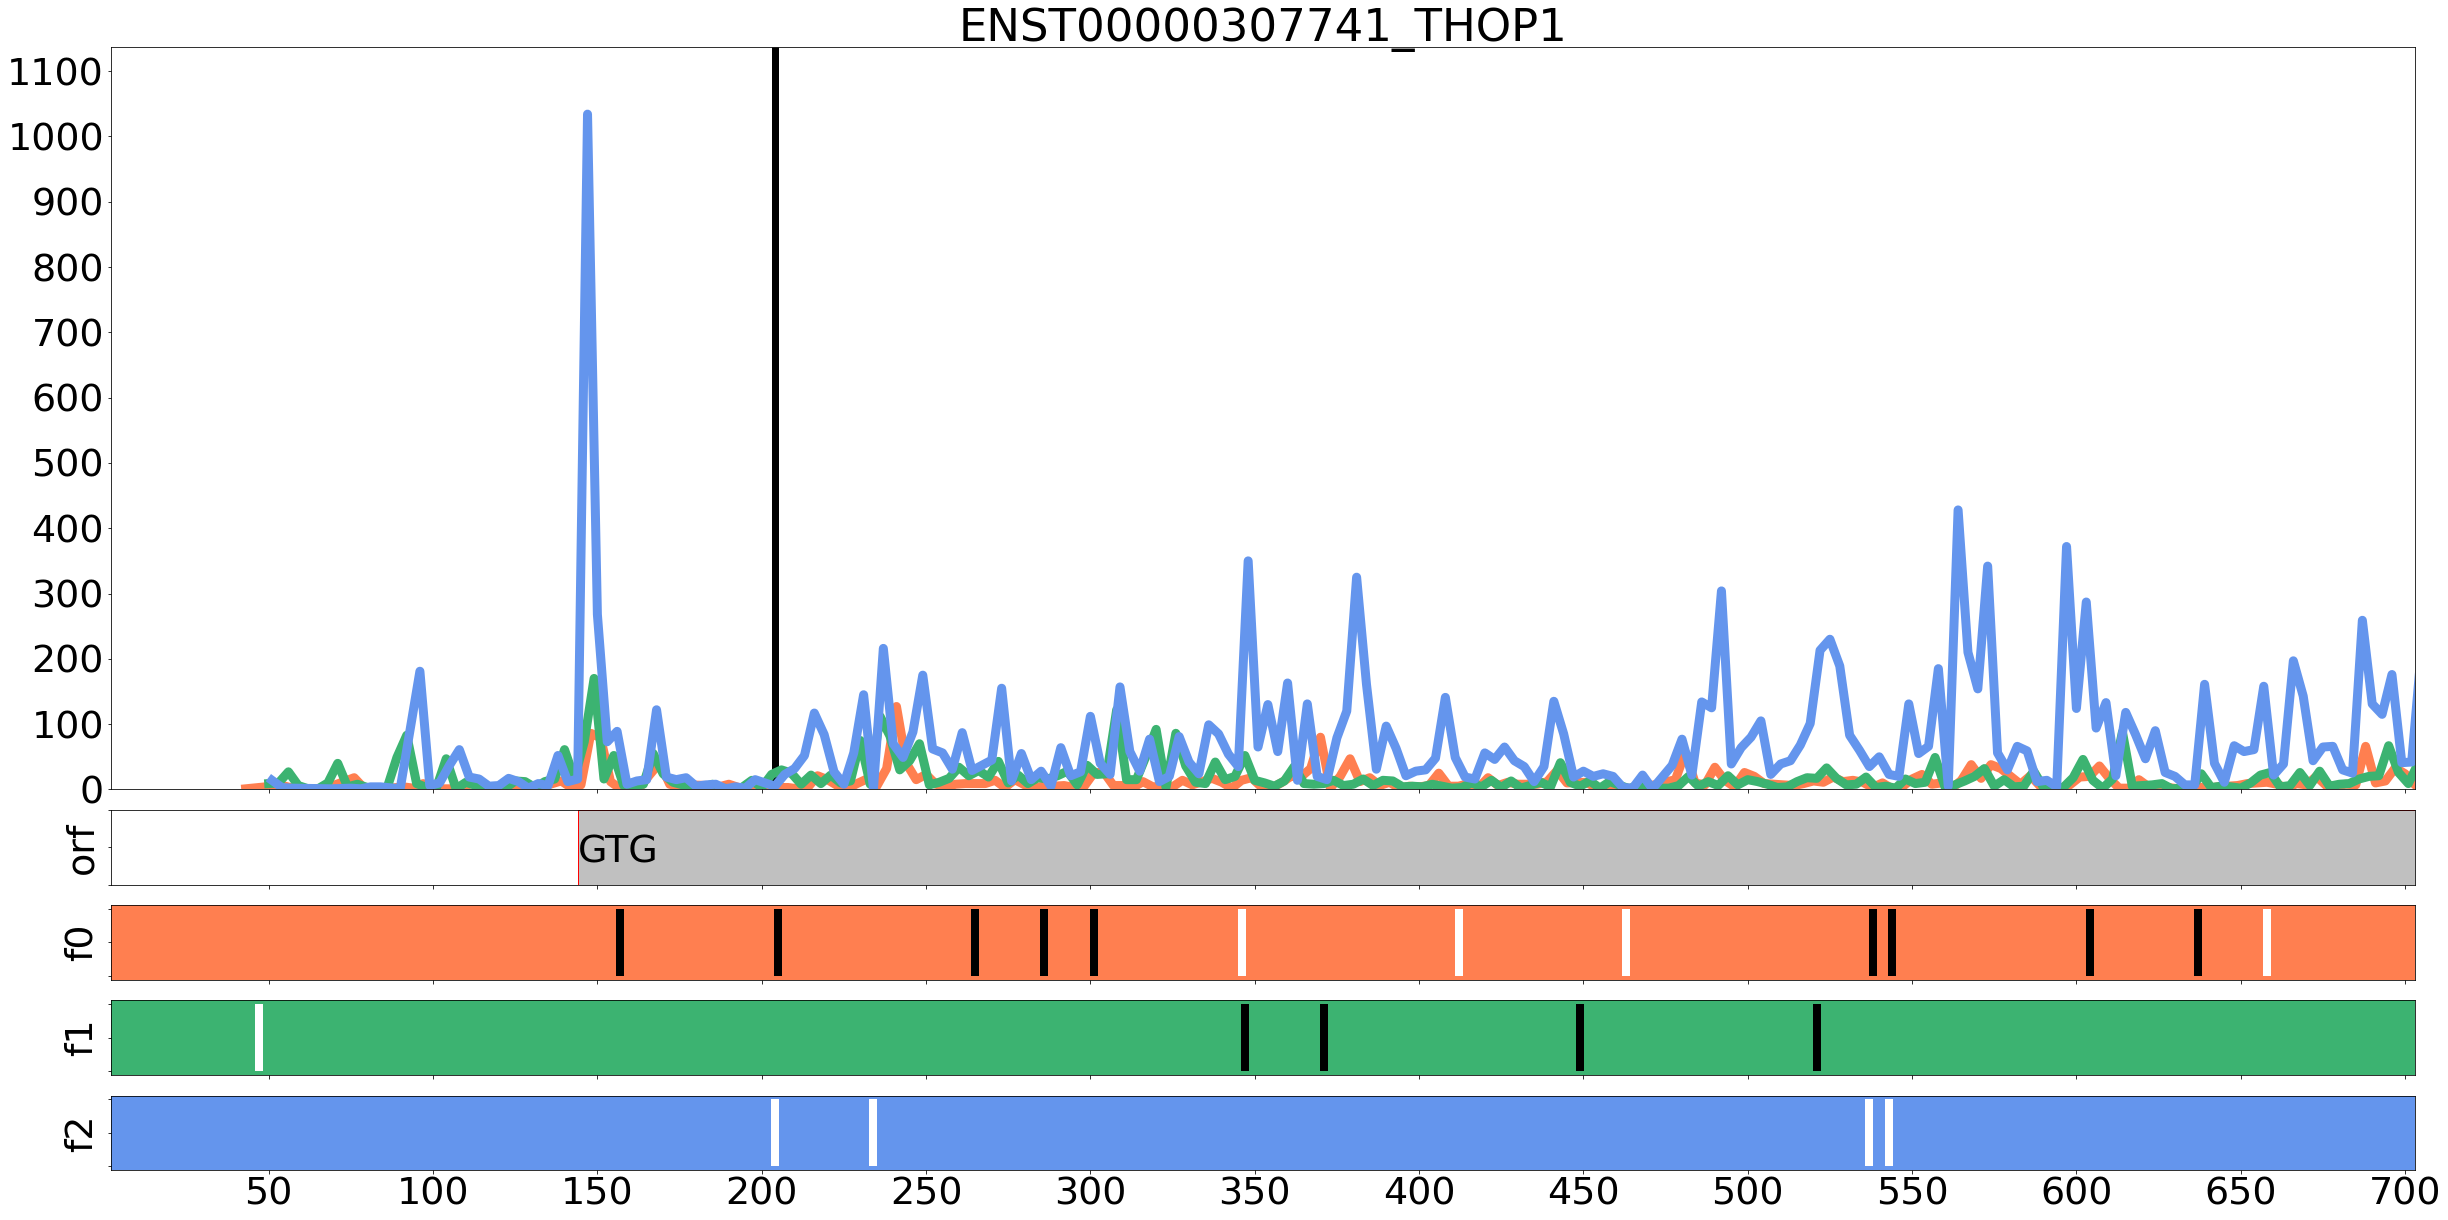

In [31]:
tmp = sole_df_sel.iloc[5]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

In [32]:
f = pd.read_csv('data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id))
f[55:]

Position Sequence  Frame 1  Frame 2  Frame 3  rna_seq
55          55        G        5        0        0      NaN
56          56        A        0       27        0      NaN
57          57        G        0        0        2      NaN
58          58        C        1        0        0      NaN
59          59        G        0        6        0      NaN
...        ...      ...      ...      ...      ...      ...
4799      4799        A        0        0        0      NaN
4800      4800        T        0        0        0      NaN
4801      4801        A        0        0        0      NaN
4802      4802        C        0        0        0      NaN
4803      4803        A        0        0        0      NaN

[4749 rows x 6 columns]

# STK38, ENST00000229812.7

NTE_CDS_ratio=1.57; Z-score= 34.66
---
STK38, ENST00000229812.7
---
221_CTG
1776
0


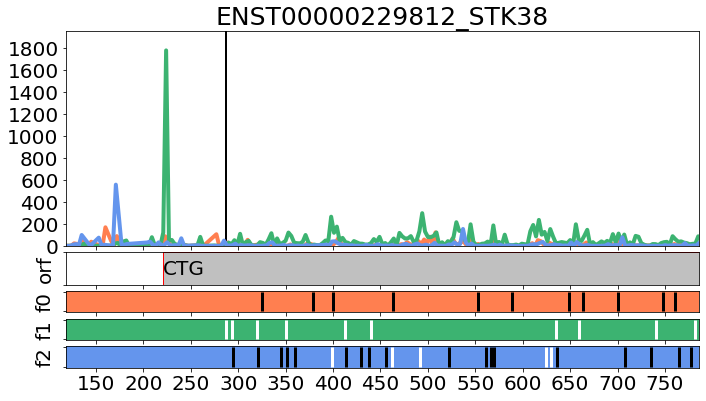

In [22]:
tmp = sole_df_sel.iloc[6]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                             linew=4,
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test.png', font1=20, font2=25)

# INSL4, ENST00000239316.4

NTE_CDS_ratio=5.08; Z-score= 63.73
---
INSL4, ENST00000239316.4
---
67_AGG
1404
0


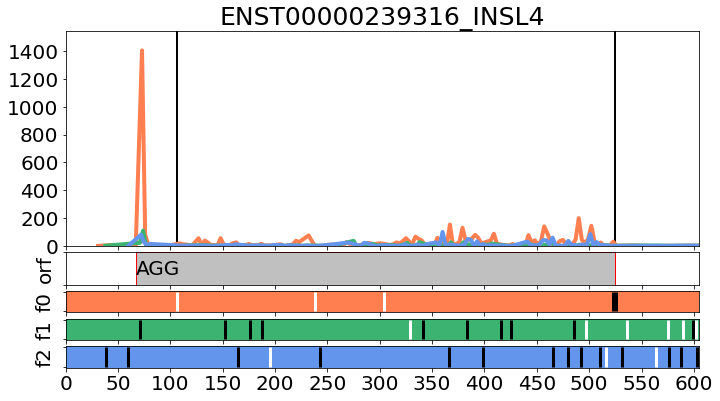

In [26]:
tmp = sole_df_sel.iloc[7]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                             linew=4,
                           figsize=(11, 6),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='test.png', font1=20, font2=25)

NTE_CDS_ratio=5.08; Z-score= 63.73
---
INSL4, ENST00000239316.4
---
67_AGG
1404
0


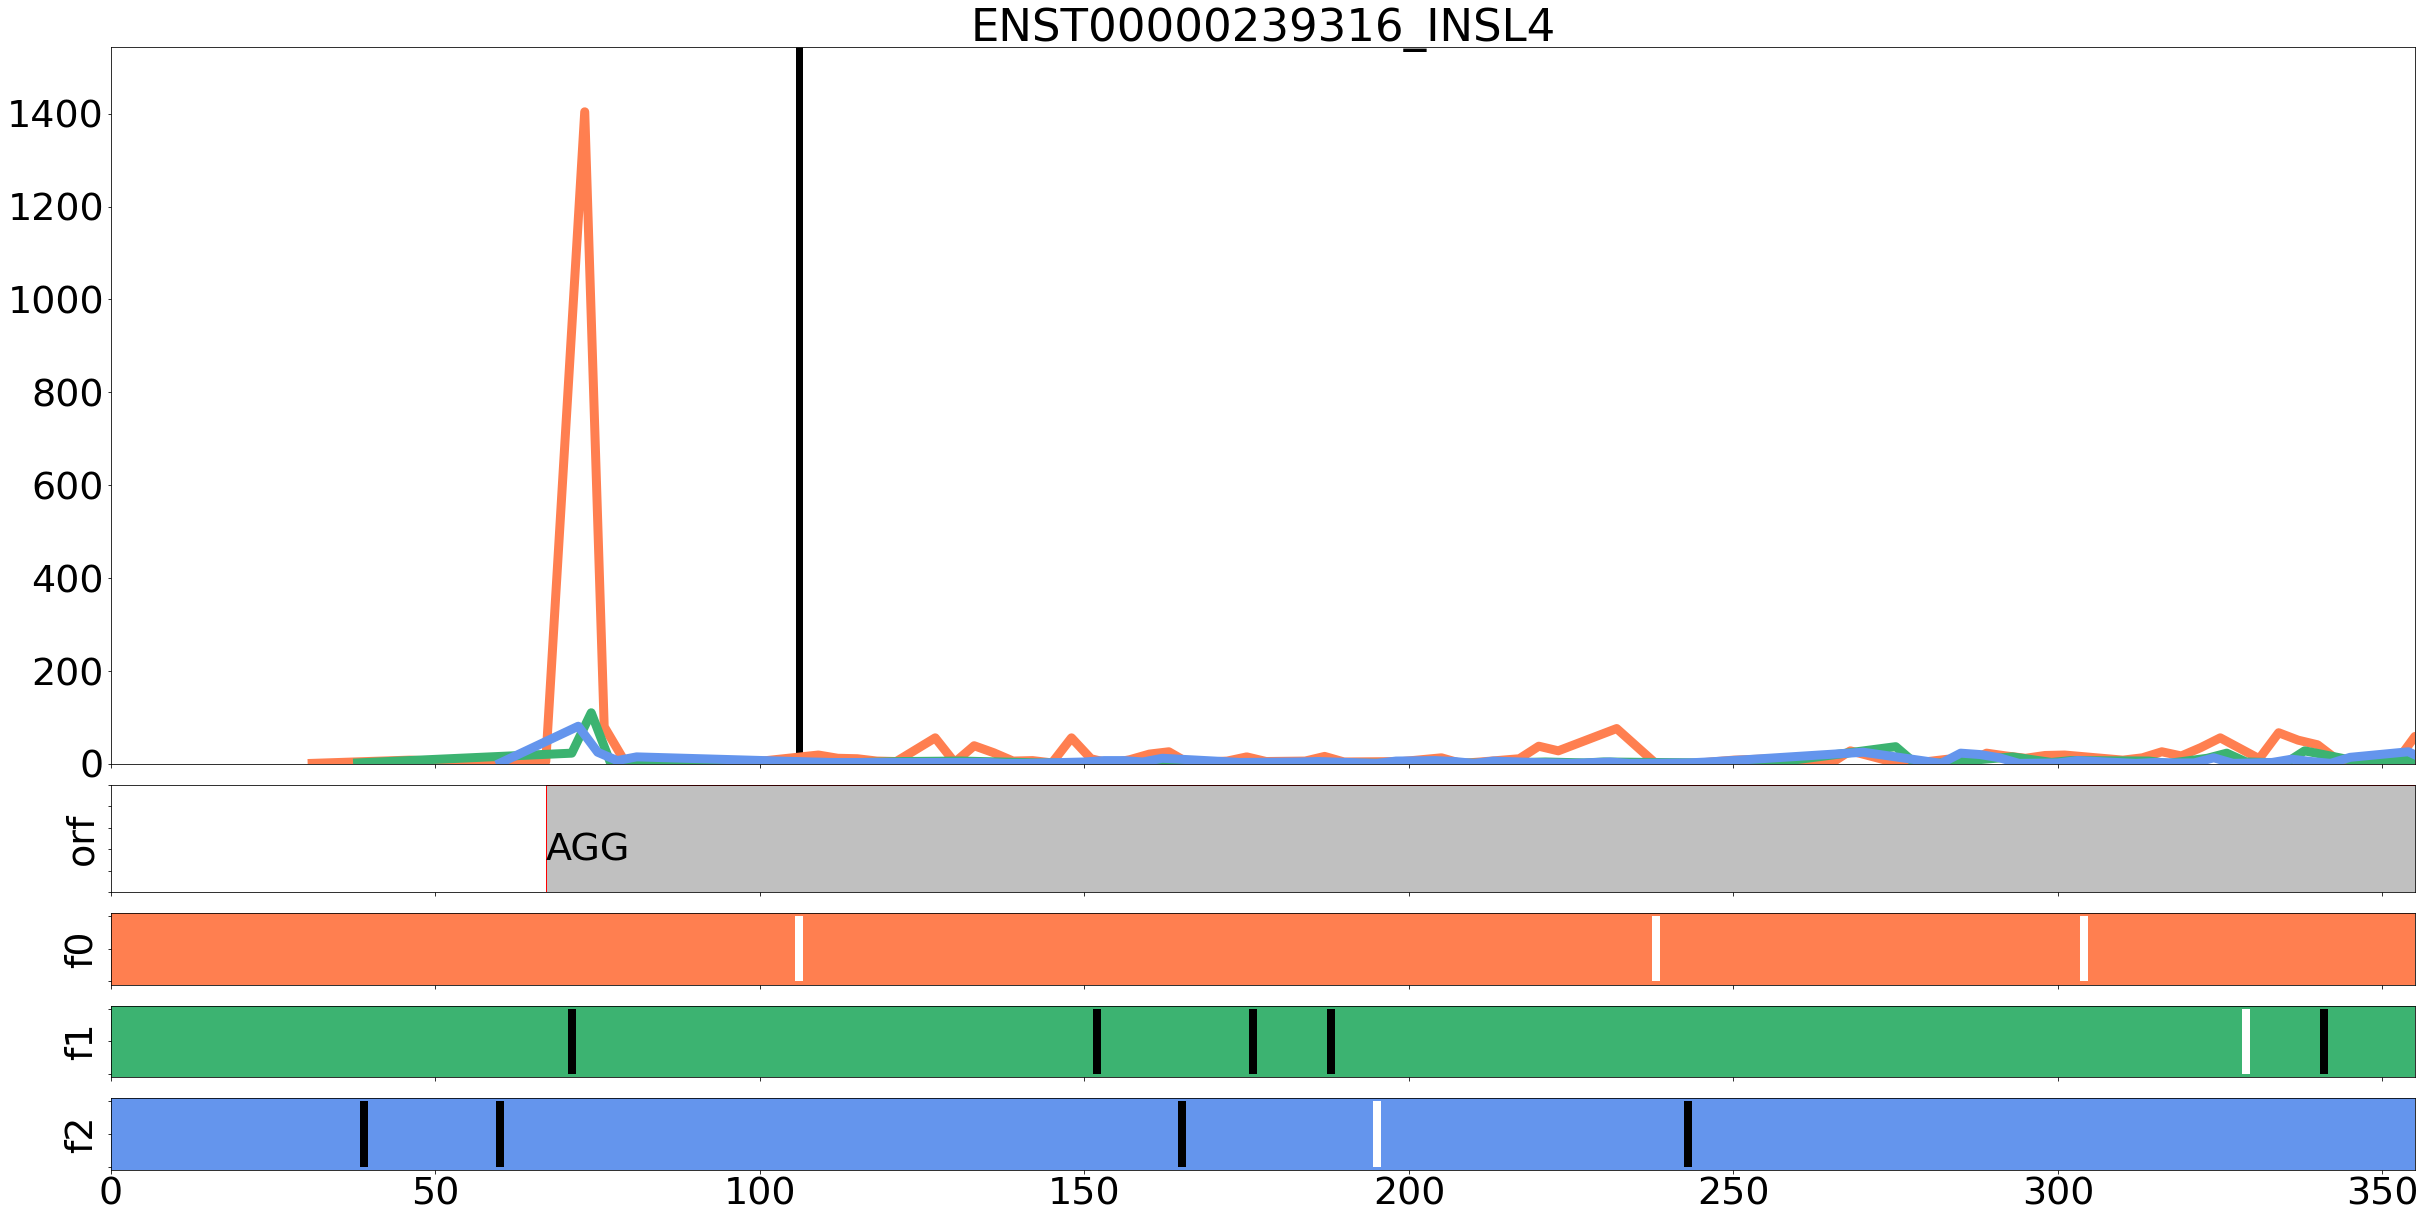

In [25]:
tmp = sole_df_sel.iloc[7]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

# SLC25A1, ENST00000215882.9

NTE_CDS_ratio=1.49; Z-score= 9.38
---
SLC25A1, ENST00000215882.9
---
107_CTG
869
0


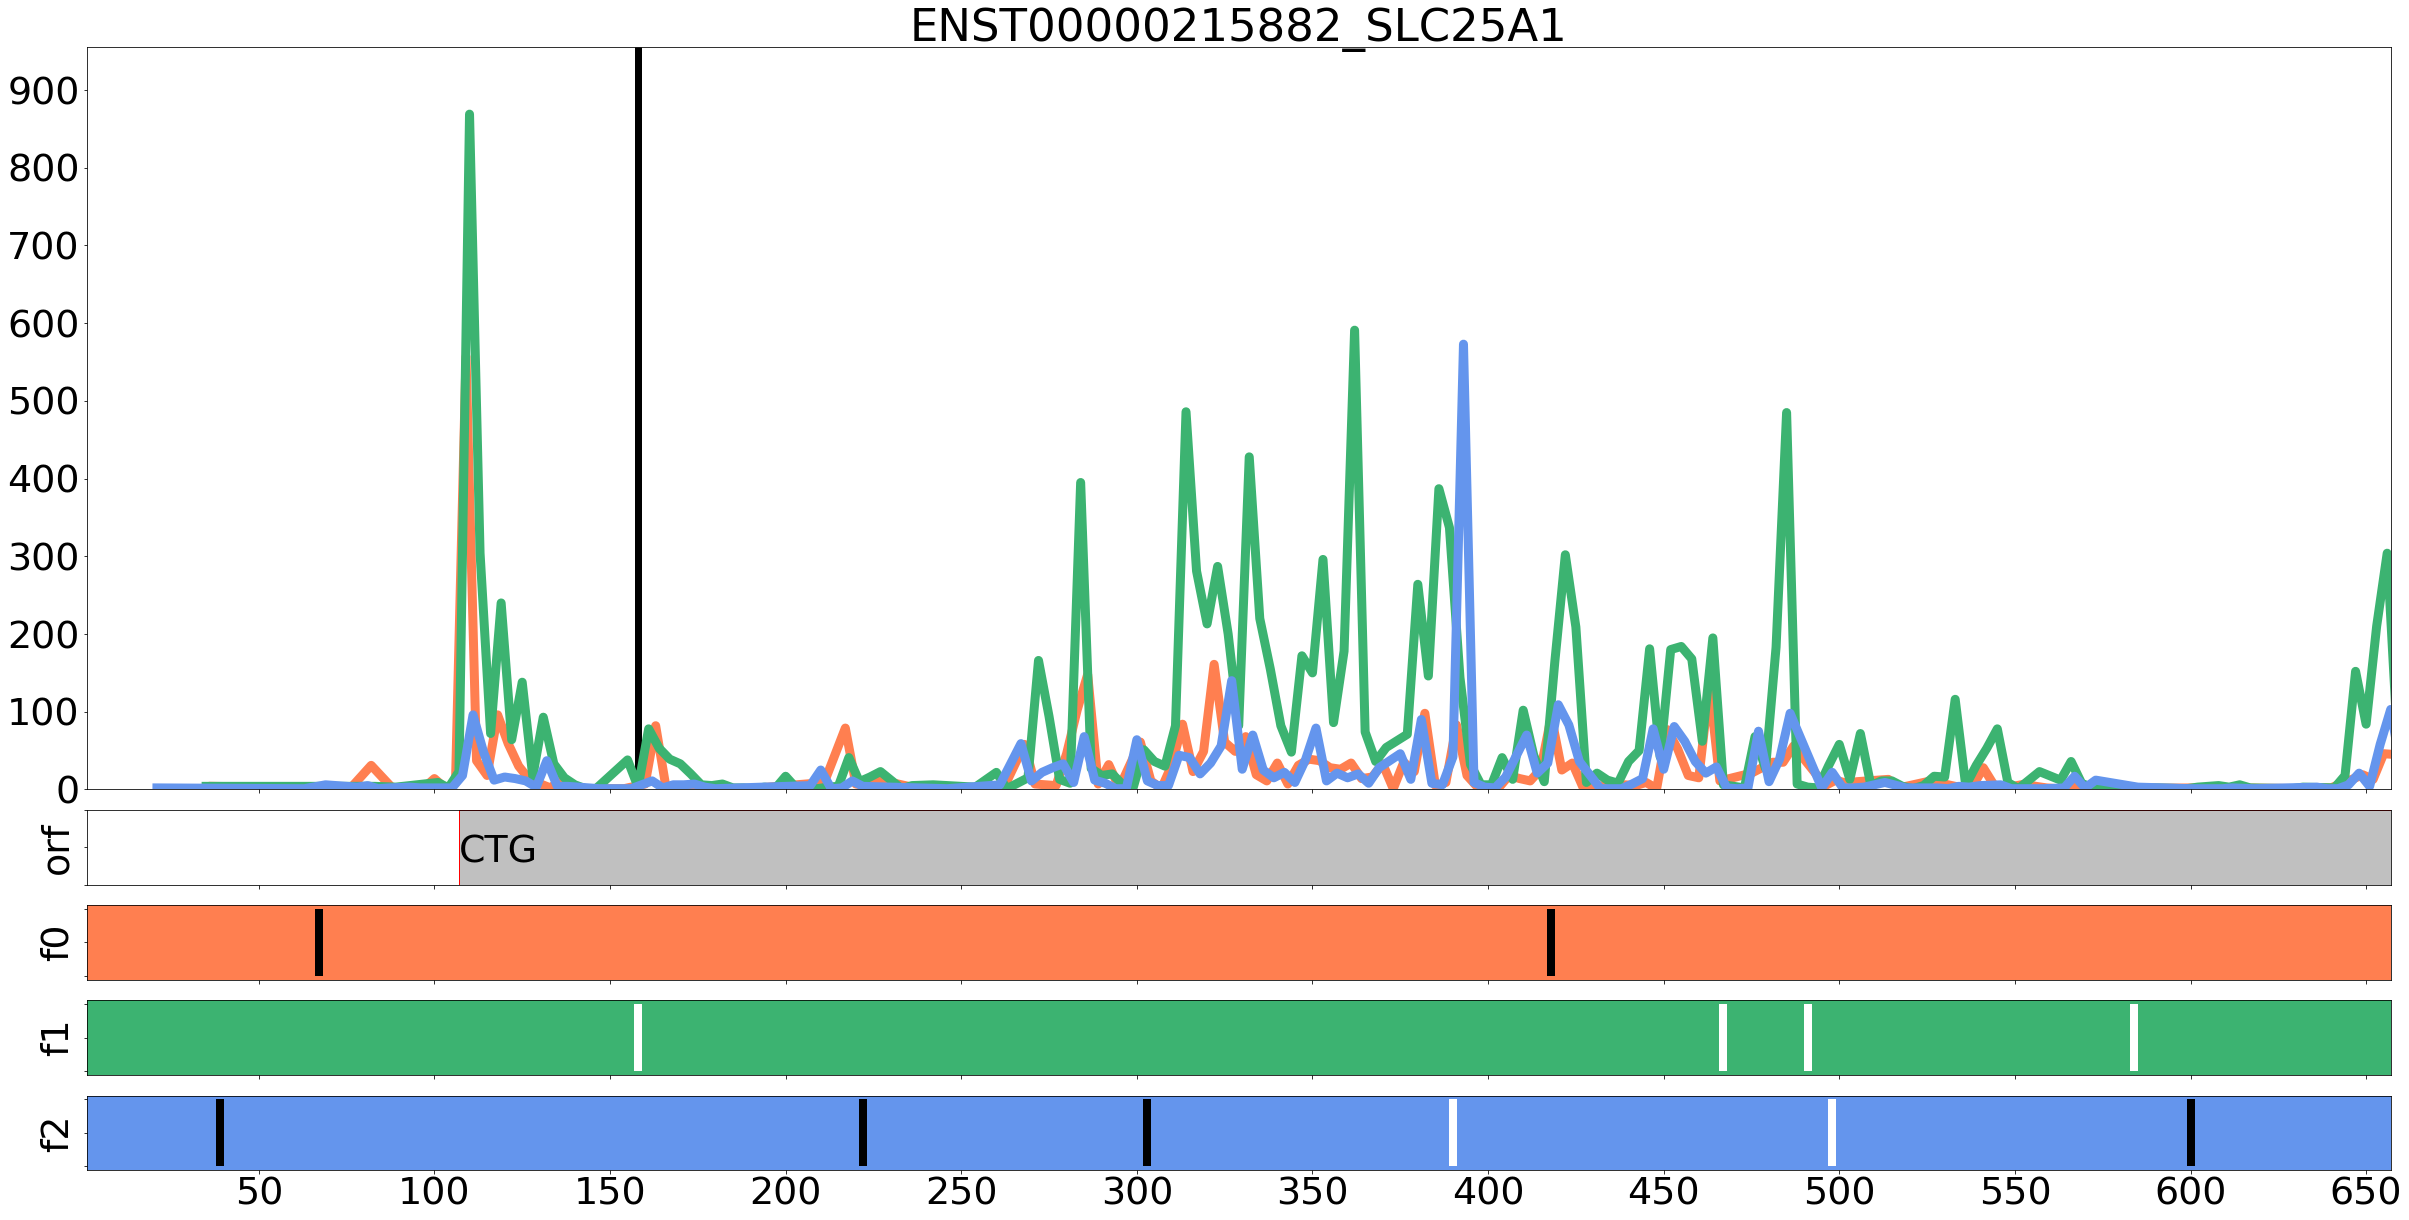

In [35]:
tmp = sole_df_sel.iloc[8]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

# RRNAD1, ENST00000368216.8

NTE_CDS_ratio=2.83; Z-score= 29.9
---
RRNAD1, ENST00000368216.8
---
571_CTG
335
0


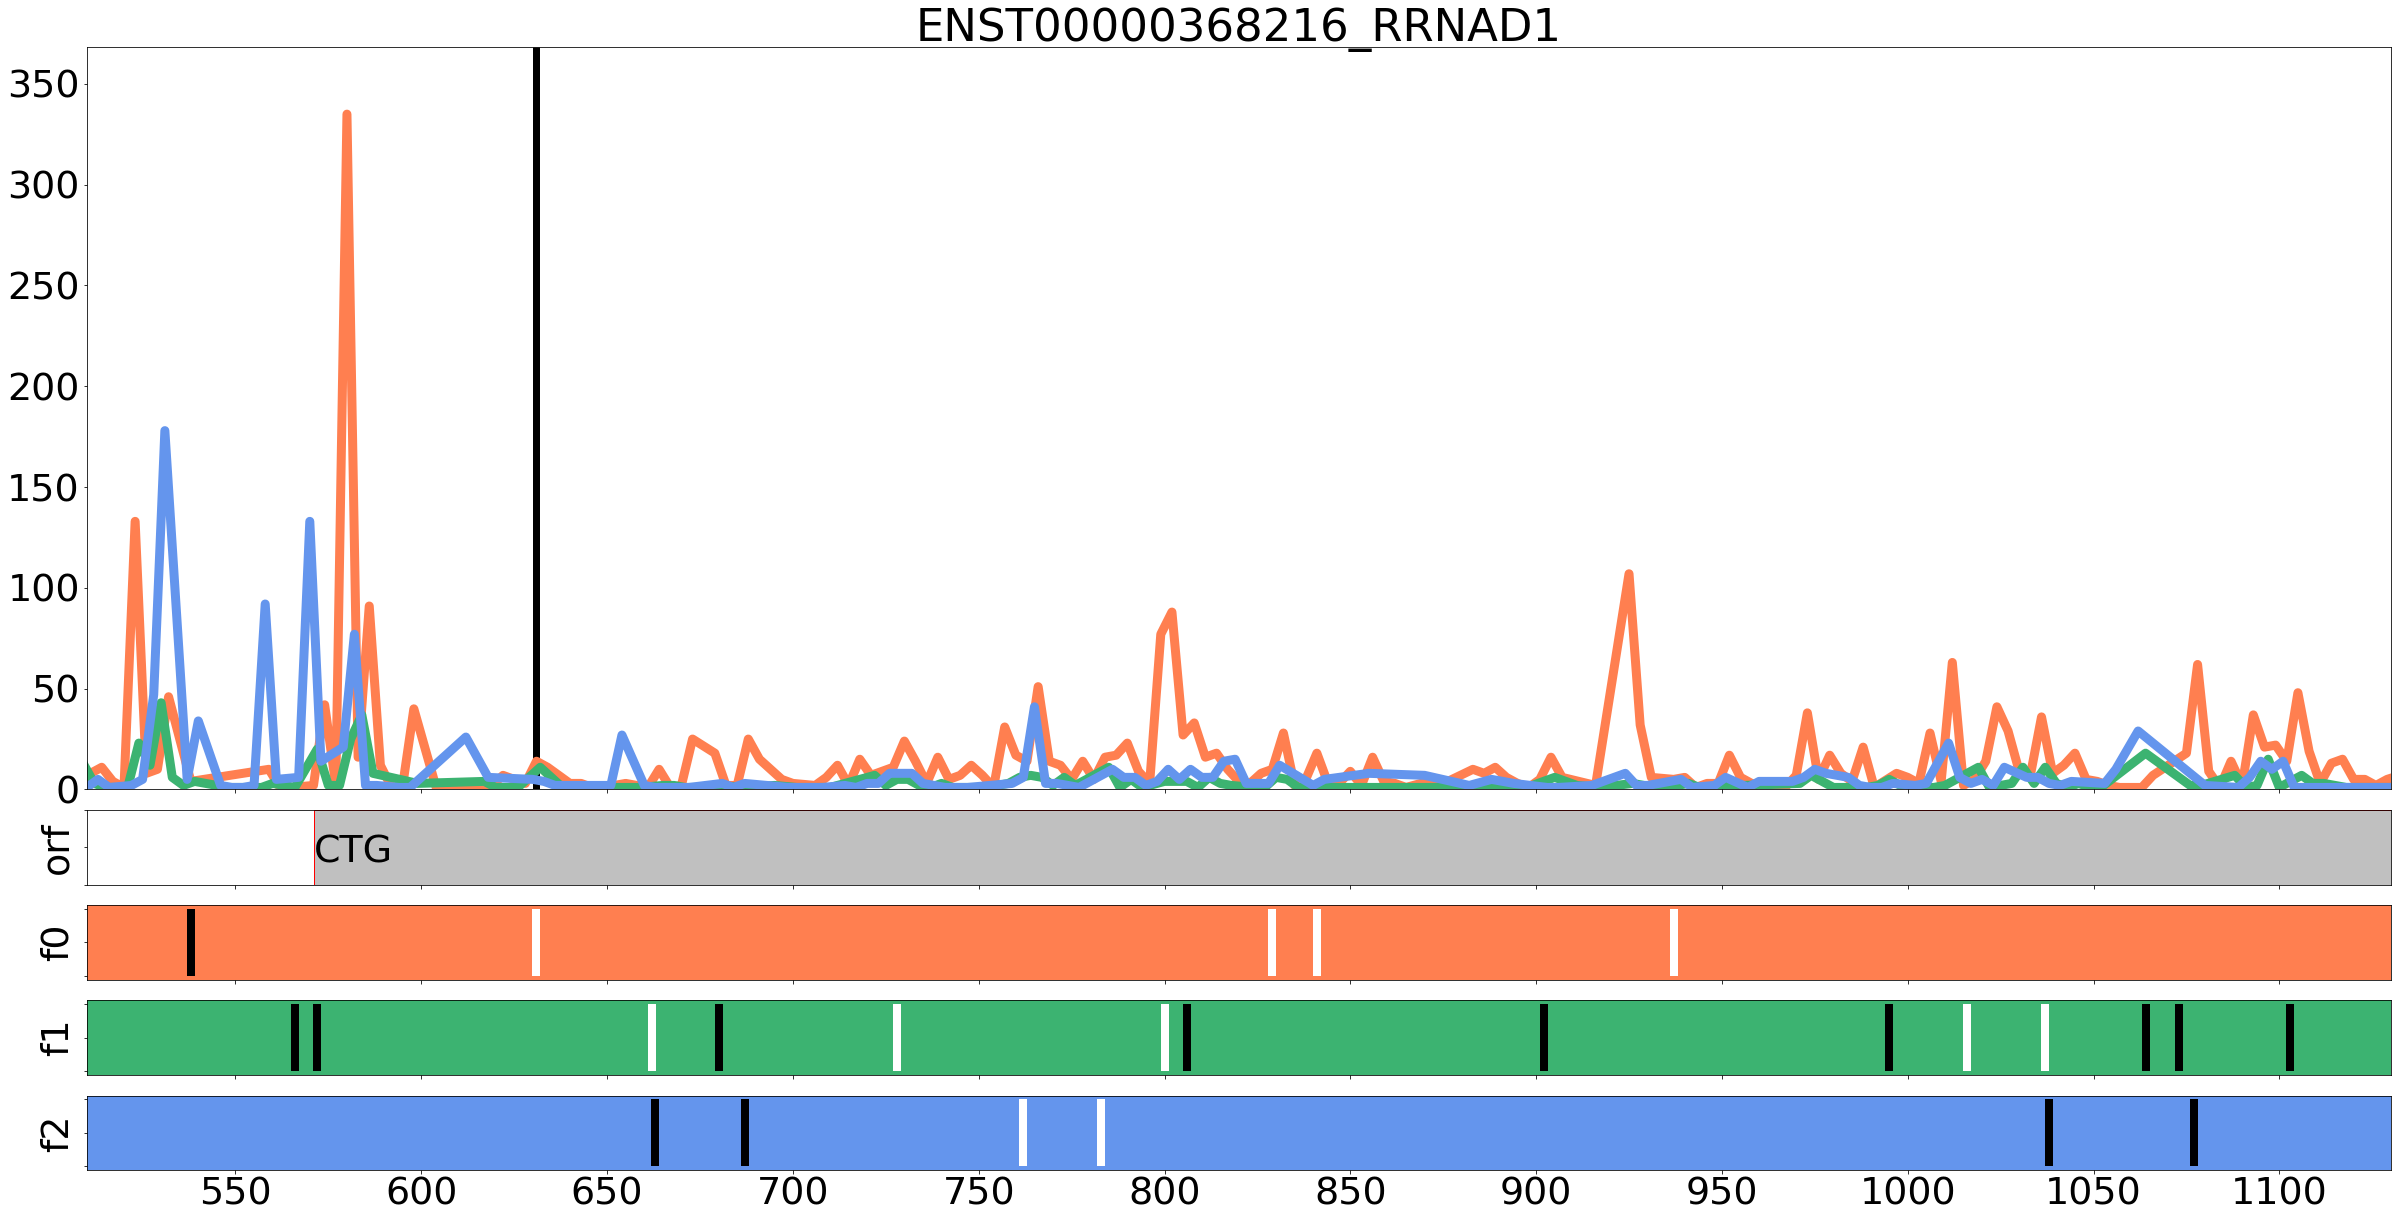

In [36]:
tmp = sole_df_sel.iloc[9]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-30, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

# CCDC8, ENST00000307522.3

NTE_CDS_ratio=1.83; Z-score= 26.93
---
CCDC8, ENST00000307522.3
---
559_ATC
146
0


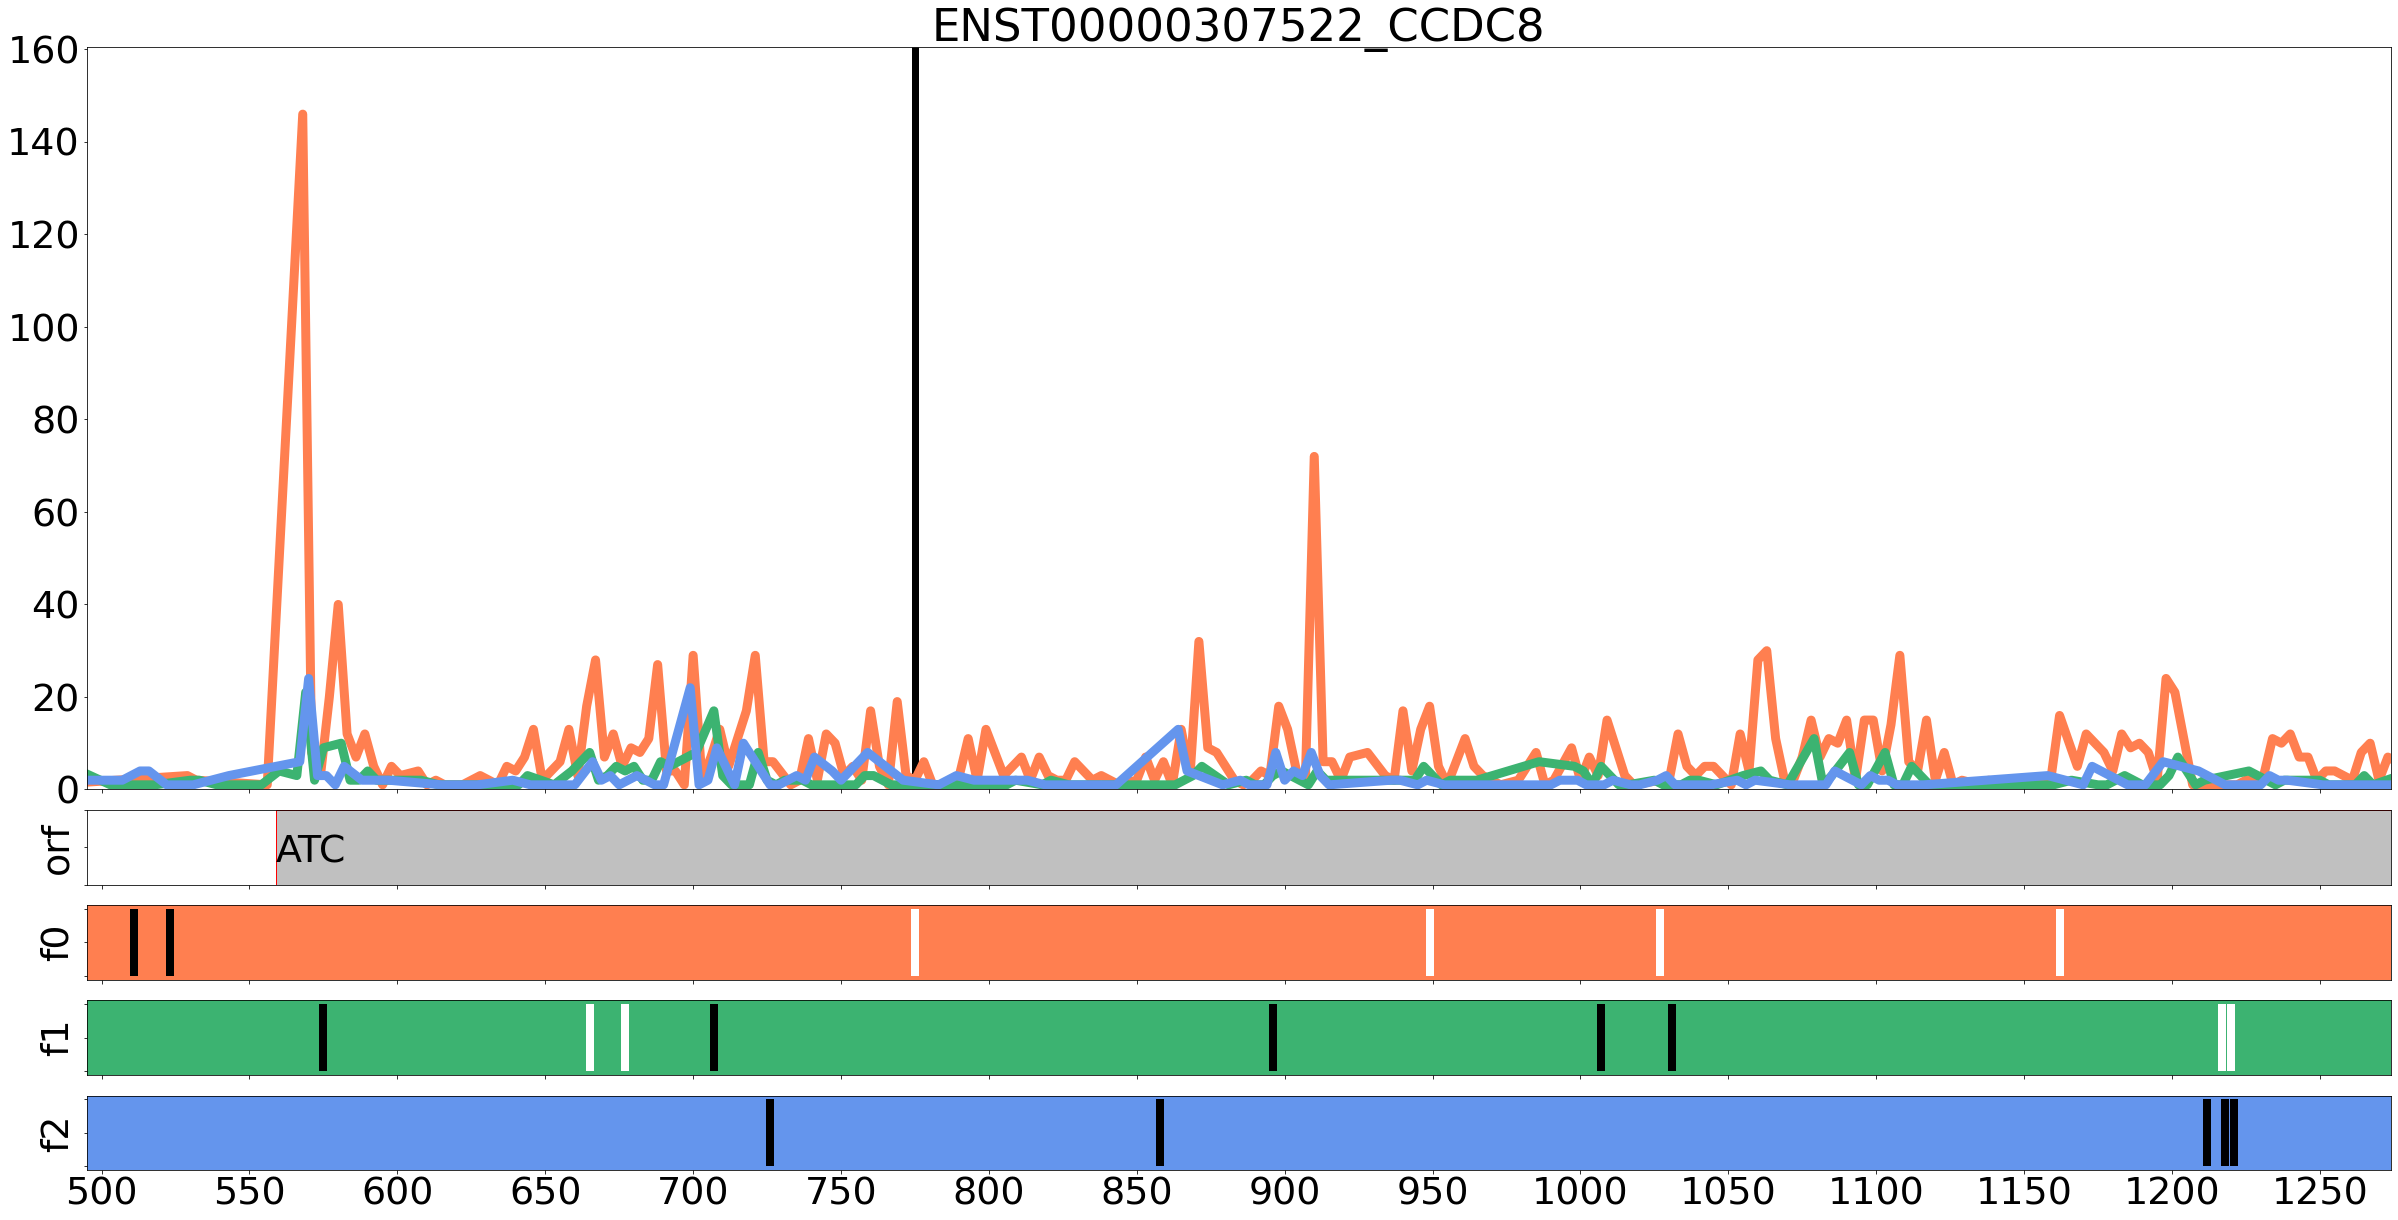

In [37]:
tmp = sole_df_sel.iloc[10]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-30, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

# ENDOG, ENST00000372642.4

NTE_CDS_ratio=1.29; Z-score= 9.43
---
ENDOG, ENST00000372642.4
---
77_TTG
799
0


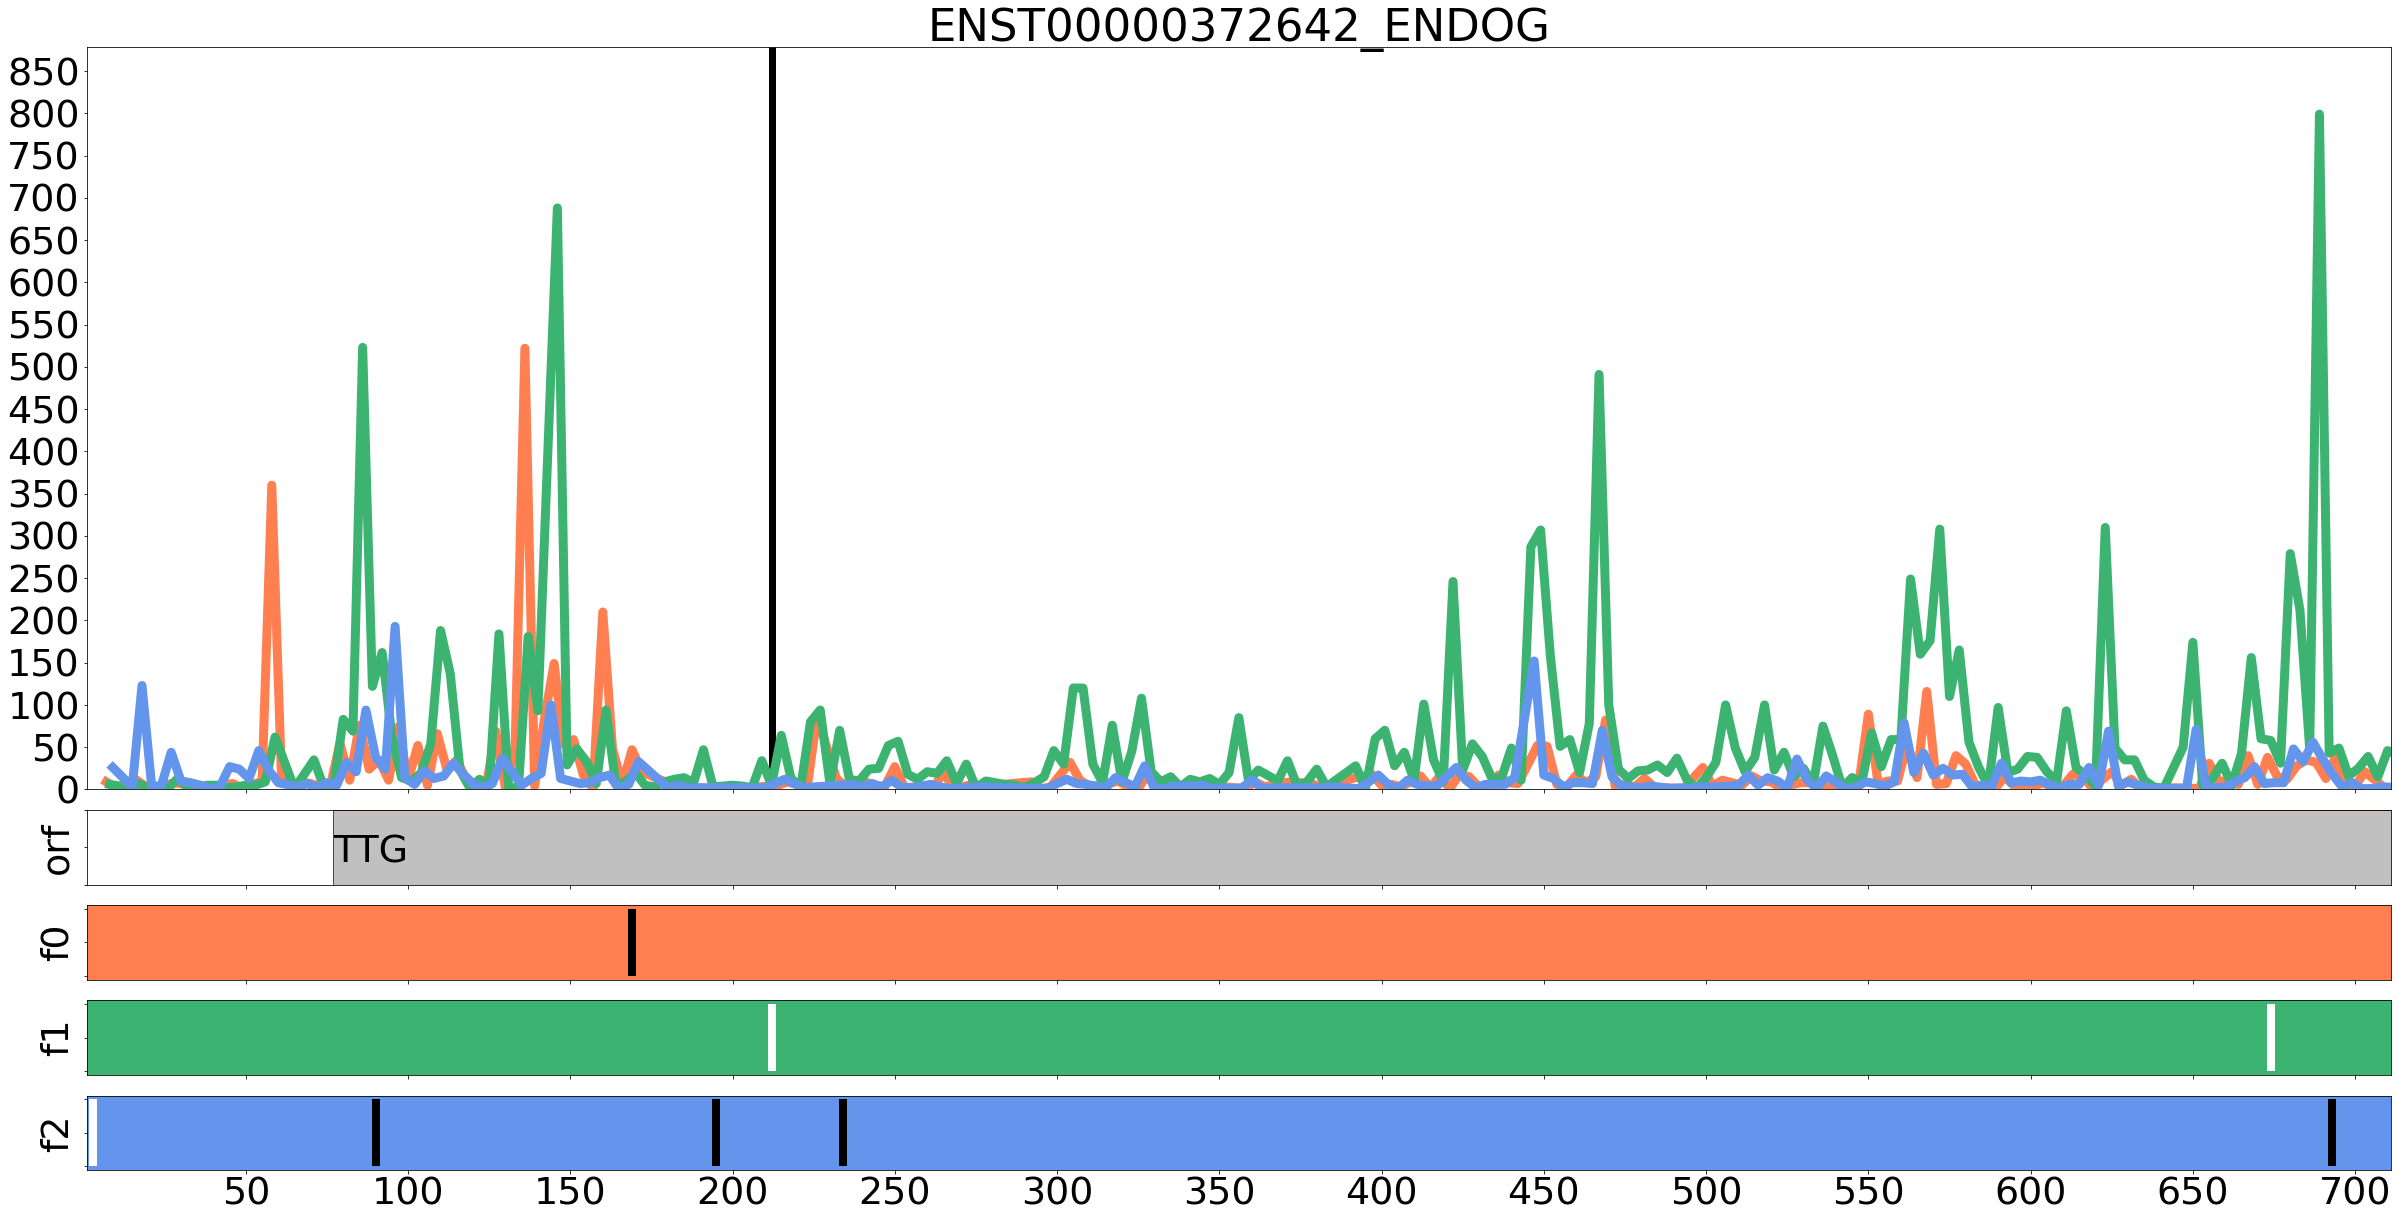

In [38]:
tmp = sole_df_sel.iloc[11]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

# CHRNA5, ENST00000299565.9

NTE_CDS_ratio=1.01; Z-score= 19.24
---
CHRNA5, ENST00000299565.9
---
120_GTG
808
0


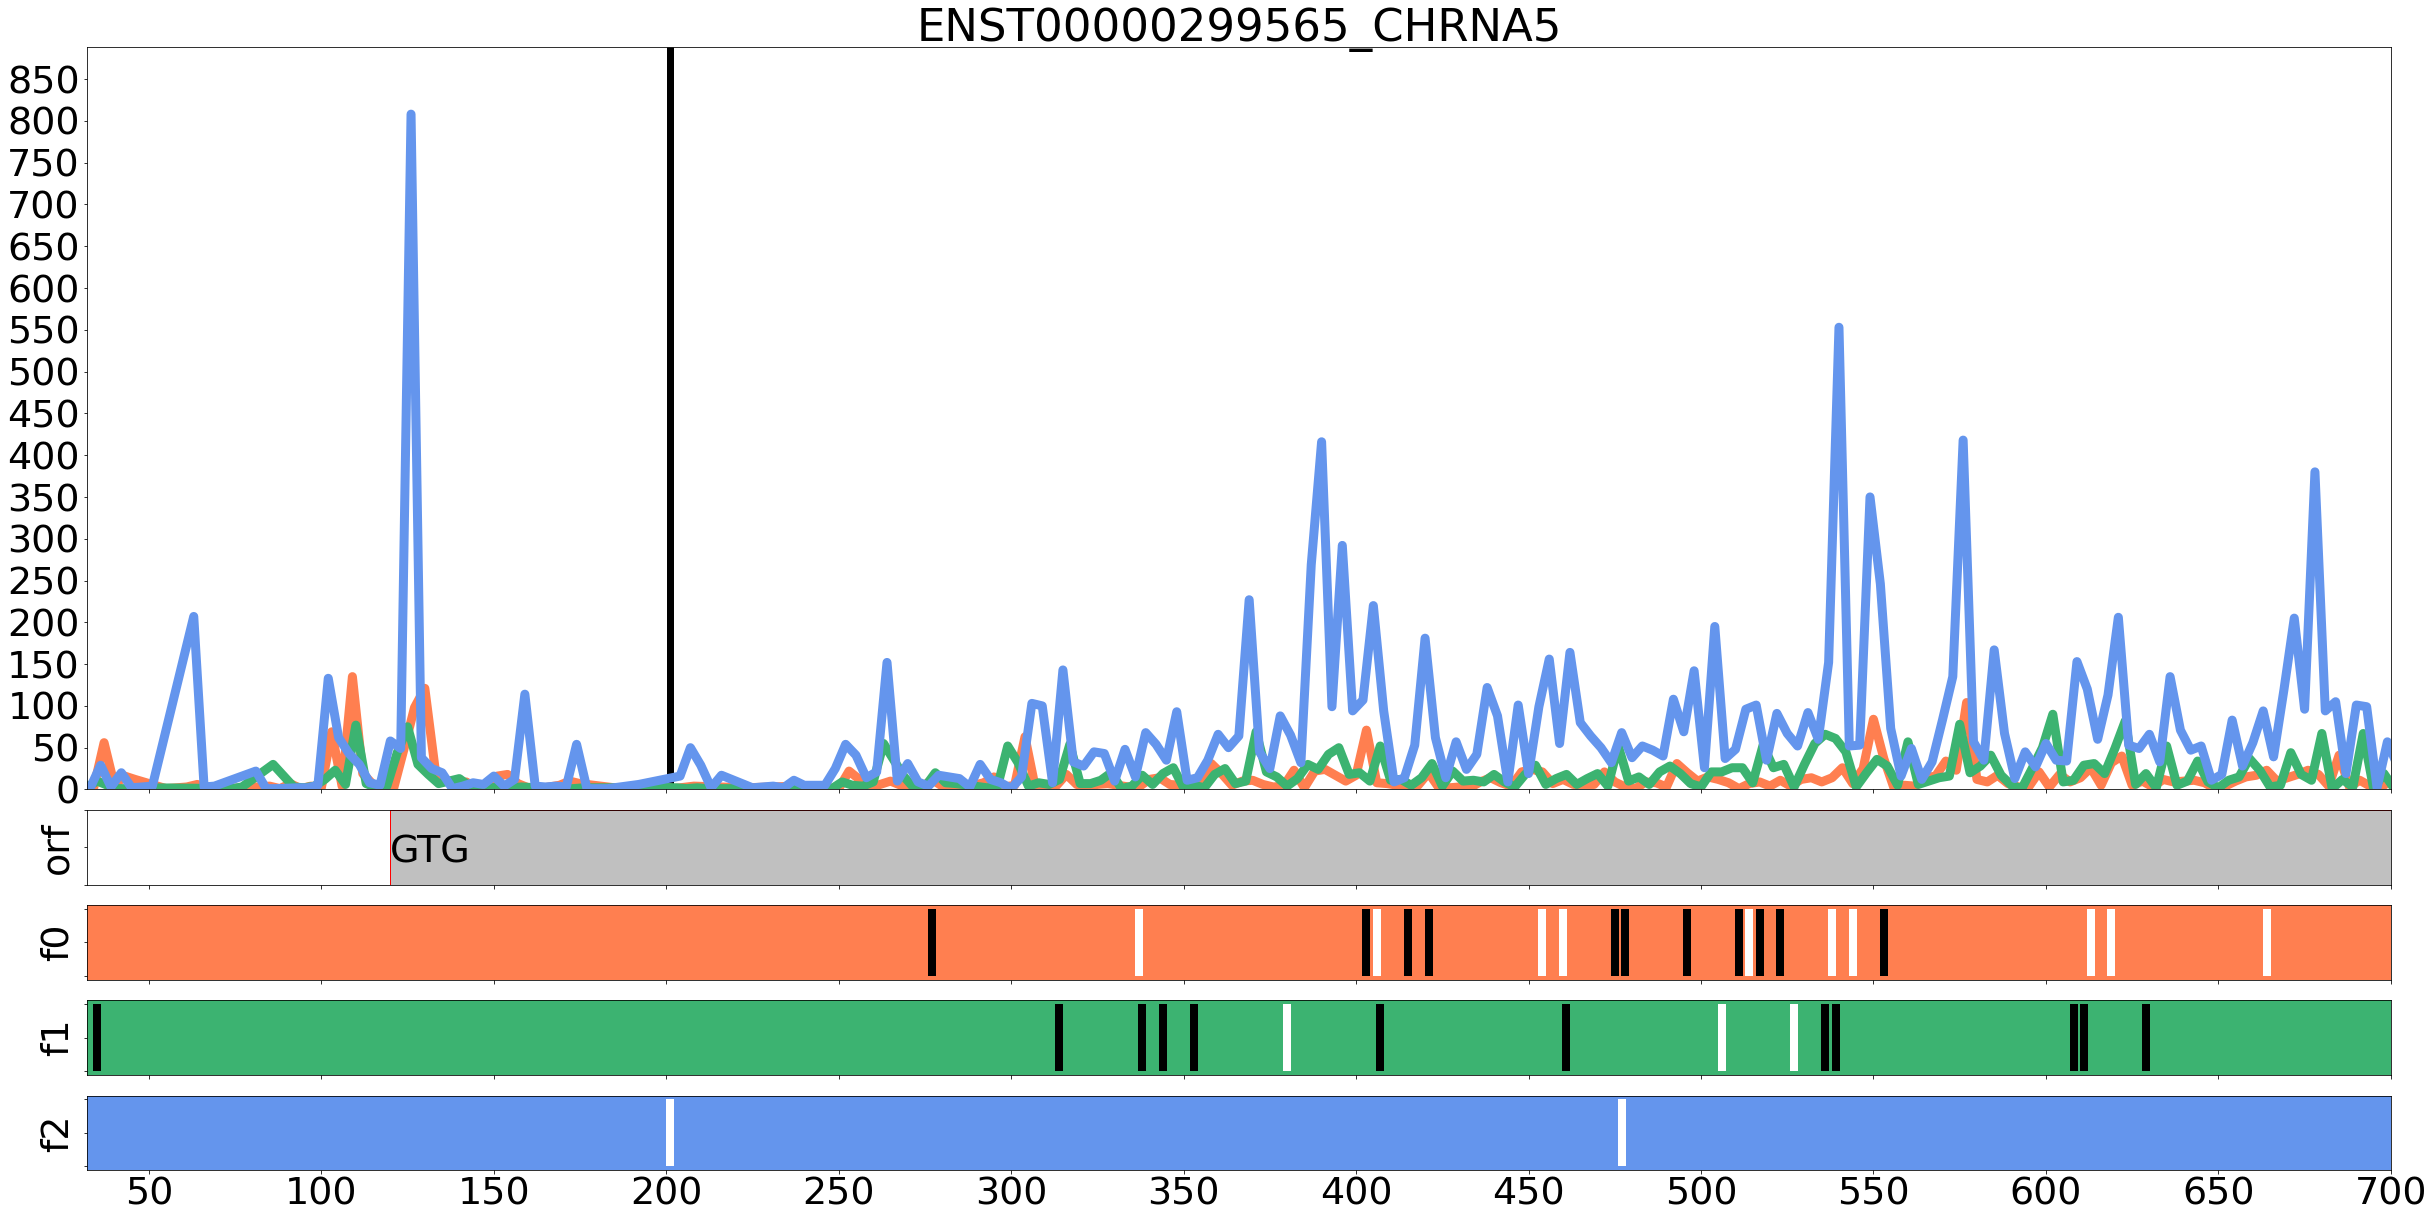

In [39]:
tmp = sole_df_sel.iloc[12]

gene =  tmp.gene
tr_id =  tmp.tr_id.split('.')[0]

print ('NTE_CDS_ratio=' + str(np.round(tmp.CDS_nte_ratio_coverage, 2))+'; ' 
       'Z-score=', np.round(tmp.Z_NTE, 2))

print ('---')

print (gene+', '+tmp.tr_id)

pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
pre_st = pos_pred_start + '_' + pred_start

print ('---')

print (pre_st)

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1-0, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+250*2]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

In [25]:
ribo = pd.read_csv('tmp_res/SET2.txt', sep='\t')
phylo = pd.read_csv('tmp_res/SET1.txt', sep='\t')

set(ribo.gene.tolist()).intersection(set(phylo.gene.tolist()))

{'CCDC8', 'CYTH2', 'FXR2', 'H1FX', 'HNRNPA0', 'MARCKS', 'RPTOR', 'SFPQ'}

In [26]:
set(sole_df_sel.gene.tolist()).intersection(set(ribo.gene.tolist()).intersection(set(phylo.gene.tolist())))

{'CCDC8'}

In [27]:
sole_df_sel.to_csv('Supplementary_tables_and_plots/tables/S5_sole_nonAUG_initiation.txt', sep='\t', index=False)

# Conservation of sole initiators: conserved at least in 1 specie from order

In [28]:
conservation_df = pd.read_csv('tmp_res/conservation_df.txt', sep='\t')
the_furthest_animal_df = pd.read_csv('tmp_res/the_furthest_animal_df.txt', sep='\t')
taxonomy = pd.read_csv('tmp_res/taxonomy_df.txt', sep='\t')[['species', '0']]

taxonomy.columns = ['the_furthest_animal', 'order_']

taxonomy.order_.unique()

array(['Primatomorpha', 'Glires', 'Cetartiodactyla', 'Perissodactyla',
       'Ferae', 'Chiroptera', 'Eulipotyphla', 'Atlantogenata',
       'NonPlacental'], dtype=object)

In [29]:
sole_df_sel_cons = sole_df_sel.merge(the_furthest_animal_df[['tr_id', 'ref_codon', 'the_furthest_animal', 'specie_codon_dict', 'orders']], on='tr_id') #.merge(taxonomy, on='the_furthest_animal')


sole_df_sel_cons.to_csv('Supplementary_tables_and_plots/tables/S5_sole_nonAUG_initiation.txt', sep='\t', index=False)

In [30]:

d = {}

import ast
# 

for el in sole_df_sel_cons.to_numpy():
    orders = el[-1]
    #orders = "Counter({'Primatomorpha': 16, 'Glires': 16, 'Cetartiodactyla': 12, 'Atlantogenata': 6, 'Ferae': 5, 'Chiroptera': 4, 'Perissodactyla': 2, 'Eulipotyphla': 1, 'NonPlacental': 1})"
    parse = orders.replace('Counter', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace("'", '').split(', ')
    for el in parse:
        order_name = el.split(': ')[0]
        if order_name not in d:
            d[order_name] = 1
        else:
            d[order_name] += 1
        

In [31]:
d

{'Primatomorpha': 13,
 'Cetartiodactyla': 6,
 'Glires': 7,
 'Atlantogenata': 5,
 'Ferae': 5,
 'Chiroptera': 5,
 'Perissodactyla': 5,
 'Eulipotyphla': 3,
 'NonPlacental': 2}

7 in Glires, 6 in Cetartiodactyla, 5 in Atlantogenata, Ferae, Chiroptera, Perissodactyla, 3 in Eulipotyphla, 2 in NonPlacental

5 non-AUG starts are conserved in Primatomorpha, 4 in Glires, 2 in NonPlacental, 1 in Cetartiodactyla and Eulipotyphla. 

# The most conserved examples (conserved in all 9 clades)

In [32]:
for el in sole_df_sel_cons.to_numpy():
    orders = el[-1]
    #orders = "Counter({'Primatomorpha': 16, 'Glires': 16, 'Cetartiodactyla': 12, 'Atlantogenata': 6, 'Ferae': 5, 'Chiroptera': 4, 'Perissodactyla': 2, 'Eulipotyphla': 1, 'NonPlacental': 1})"
    parse = orders.replace('Counter', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace("'", '').split(', ')
    for el_ in parse:
        order_name = el_.split(': ')[0]
        if order_name == 'NonPlacental':
            print ('NonPlacental', el[0])
    print (el[0], len(parse))
        

ENST00000234115.10 1
ENST00000341772.4 1
ENST00000297578.8 1
ENST00000355415.6 2
NonPlacental ENST00000285605.7
ENST00000285605.7 9
ENST00000307741.10 1
NonPlacental ENST00000229812.7
ENST00000229812.7 9
ENST00000239316.4 7
ENST00000215882.9 2
ENST00000368216.8 8
ENST00000307522.3 2
ENST00000372642.4 7
ENST00000299565.9 1


ENST00000285605.7, ENST00000229812.7

In [33]:
sole_df_sel_cons[sole_df_sel_cons['tr_id'].isin(['ENST00000285605.7', 'ENST00000229812.7'])]

tr_id      gene  codon_start codon_type  cds_start  \
4  ENST00000285605.7  MARVELD1          105        ATT        153   
6  ENST00000229812.7     STK38          220        CTG        286   

   Z_CDS_wo_init      Z_NTE  height_peak_value_nonAUG  height_peak_value_cds  \
4      -0.107277  20.104651                       947                     14   
6       0.198121  34.664063                      1776                     31   

   CDS_ratio  CDS_nte_ratio_coverage ref_codon the_furthest_animal  \
4   0.183558                1.357175       ATT             Opossum   
6   0.162683                1.570308       CTG             Opossum   

                                   specie_codon_dict  \
4  {'Chimp': 'ATT', 'Bonobo': 'ATT', 'Gorilla': '...   
6  {'Chimp': 'CTG', 'Bonobo': 'CTG', 'Gorilla': '...   

                                              orders  
4  Counter({'Primatomorpha': 16, 'Glires': 16, 'C...  
6  Counter({'Primatomorpha': 25, 'Cetartiodactyla...

In [34]:
li = []

kek = {}

for i, el in enumerate(sole_df_sel.merge(meta[['tr_id', 'N_term_start1', 'global_coo_primary']], on='tr_id', how='inner').to_numpy()):
    tr_id = el[0]
    
    #print (tr_id)
    chrom = el[-1].split(':')[0]
    nte_start = el[-2]
    
    a = el[2] - nte_start + 1
    b = a + 2
    
    # add kozak context
    a1 =  a - 4
    b1 = b + 1
    
    fasta_input = 'data/nte_full_aln/out/%s/fasta3/%s.fasta' % (chrom, tr_id)

    aln_col, ids_li = get_aln(fasta_input)
    new_col_ind = re_index_with_gaps(aln_col)
    sliced_array = slice_aln(aln_col, new_col_ind, a, b)
    
    sliced_array_Kozak = slice_aln(aln_col, new_col_ind, a1, b1)
    
    # check conservation
    # fraction of the exact reference codon 
    # Counter of near-cognate codons 
    ref_codon = ''.join(pd.DataFrame(sliced_array).to_numpy()[0]).replace('-', '')
    
    if tr_id == 'ENST00000341772.4':
        print (pd.DataFrame(sliced_array))
    
    number_of_species  = len(aln_col)
    
    codons = [''.join(list(x)).replace('-', '') for x in pd.DataFrame(sliced_array).to_numpy()[0:]]
    
    ref_codon_count = codons.count(ref_codon)
    
    # count of all non-cognate + AUG
    non_cognates = ['ATG', 'CTG', 'TTG', 'GTG', 'ATC', 'ATT', 'ATA', 'AGG', 'AAG', 'ACG']
    
    non_cognates_codon_count = 0
    for codon in non_cognates:
        non_cognates_codon_count += codons.count(codon)
    
    ref_codon_fraction = ref_codon_count / number_of_species
    near_cognate_codong_fraction = non_cognates_codon_count / number_of_species
    
    counter_codon = Counter(codons)
    
    if i % 10 == 0:
        print (i)
        
    kek[tr_id] = [sliced_array, sliced_array_Kozak, ids_li]
    
    li.append([tr_id, el[2], nte_start, ref_codon, number_of_species, ref_codon_count, ref_codon_fraction, counter_codon,
              non_cognates_codon_count, near_cognate_codong_fraction])

NameError: name 'get_aln' is not defined

# Get alignments for the most conserved starts 

In [35]:
def get_aln(fasta_input):
    aln_col = []
    
    with open(fasta_input, 'r') as input_handle:
        ids_li = []
        for record in SeqIO.parse(input_handle, "fasta"):
            seq = str(record.seq)
            ids = str(record.id)
            aln_col.append([seq[i:i+1] for i in range(0, len(seq), 1)])
            ids_li.append(ids)
    return aln_col, ids_li


def re_index_with_gaps(aln_col):
    new_col_ind = []

    # take ref seq
    counter_pos = 0 # to exclude '-'

    for col in pd.DataFrame(aln_col).to_numpy()[0]:
        if (col == '-') | (col == '.'): # UCC UGA C = TCC TGA C
            new_col_ind.append(counter_pos)
        else: 
            counter_pos += 1
            new_col_ind.append(counter_pos)
    
    return new_col_ind


def slice_aln(aln_col, new_col_ind, a, b):
    fr_stop_motif_array = []
    for row in pd.DataFrame(aln_col).to_numpy():
        tmp = []
        for ind, col in zip(new_col_ind, row):
            if (ind >= a) & (ind <= b):
                tmp.append(col)
            
        fr_stop_motif_array.append(tmp)
    
    return fr_stop_motif_array


In [36]:
li = []

kek = {}

for i, el in enumerate(R_Set[['tr_id', 'gene', 'pos_of_codon']].merge(meta[['tr_id', 'N_term_start1', 'global_coo_primary']], on='tr_id', how='inner').to_numpy()):
    tr_id = el[0]
    
    #print (tr_id)
    chrom = el[-1].split(':')[0]
    nte_start = el[-2]
    pos_of_codon = el[2]
    
    a = pos_of_codon - nte_start + 1
    b = a + 2
    
    #
    
    fasta_input = 'data/nte_full_aln/out/%s/fasta3/%s.fasta' % (chrom, tr_id)

    aln_col, ids_li = get_aln(fasta_input)
    new_col_ind = re_index_with_gaps(aln_col)
    sliced_array = slice_aln(aln_col, new_col_ind, a, b)
    
    a1 = a - 4
    b1 = b + 1
    sliced_array_TIS = slice_aln(aln_col, new_col_ind, a1, b1)
    
    # check conservation
    # fraction of the exact reference codon 
    # Counter of near-cognate codons 
    ref_codon = ''.join(pd.DataFrame(sliced_array).to_numpy()[0]).replace('-', '')
    
    #if tr_id == 'ENST00000341772.4':
        #print (pd.DataFrame(sliced_array))
    
    number_of_species  = len(aln_col)
    
    codons = [''.join(list(x)).replace('-', '') for x in pd.DataFrame(sliced_array).to_numpy()[0:]]
    
    ref_codon_count = codons.count(ref_codon)
    
    # count of all non-cognate + AUG
    non_cognates = ['ATG', 'CTG', 'TTG', 'GTG', 'ATC', 'ATT', 'ATA', 'AGG', 'AAG', 'ACG']
    
    non_cognates_codon_count = 0
    for codon in non_cognates:
        non_cognates_codon_count += codons.count(codon)
    
    ref_codon_fraction = ref_codon_count / number_of_species
    near_cognate_codong_fraction = non_cognates_codon_count / number_of_species
    
    counter_codon = Counter(codons)
    
    if i % 10 == 0:
        print (i)
        
    kek[tr_id] = [sliced_array, aln_col,sliced_array_TIS,ids_li]
    
    dict_animals = dict(zip(ids_li[1:], codons))
    
    li.append([tr_id, el[2], nte_start, ref_codon, number_of_species, ref_codon_count, ref_codon_fraction, counter_codon,
              non_cognates_codon_count, near_cognate_codong_fraction, dict_animals, ids_li])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


In [37]:
conservation_df = pd.DataFrame(li, columns = ['tr_id', 'codon_start', 'nte_start', 'ref_codon', 
                                  'number_of_species', 'ref_codon_count', 
                                  'ref_codon_fraction', 'counter_codon', 
                                 'near_cognate_codong_count', 'near_cognate_codong_fraction',
                                             'dict_animals', 'ids_li'])

conservation_df = conservation_df.merge(metadata_pc_g25[['tr_id', 'gene']], on='tr_id', how='inner')

print (conservation_df.shape)
conservation_df[0:2]

(395, 13)


tr_id  codon_start  nte_start ref_codon  number_of_species  \
0   ENST00000379389.4           97          1       ATC                111   
1  ENST00000349431.10          172         28       ACG                 82   

   ref_codon_count  ref_codon_fraction  \
0               33            0.297297   
1               58            0.707317   

                                       counter_codon  \
0  {'ATC': 33, 'TTC': 2, '': 7, 'GTCTTCGCCCGACCGG...   
1  {'ACG': 58, 'ACA': 1, 'AGG': 2, 'GCA': 1, 'GCG...   

   near_cognate_codong_count  near_cognate_codong_fraction  \
0                         36                      0.324324   
1                         60                      0.731707   

                                        dict_animals  \
0  {'Chimp': 'ATC', 'Bonobo': 'ATC', 'Gorilla': '...   
1  {'Chimp': 'ACG', 'Bonobo': 'ACG', 'Gorilla': '...   

                                              ids_li    gene  
0  [Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...   ISG15  
1  [Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...  UBE2J2

# Prepare .fasta files for plots 

ATT in MARVELD1 (ENST00000285605.7) and CTG in STK38 (ENST00000229812.7)

In [38]:
fasta = open('tmp_res/MARVELD1_ENST00000285605.7_Kozak.fasta', 'w')

for an, el in zip(kek['ENST00000285605.7'][-1], kek['ENST00000285605.7'][-2]):
    
    if ''.join(el) != '---------':
        #print (''.join(el))
        fasta.write('>'+an+'\n')
        fasta.write(''.join(el).replace('T', 'U')+'\n')

fasta.close()

In [39]:
fasta = open('tmp_res/STK38_ENST00000229812.7_Kozak.fasta', 'w')

for an, el in zip(kek['ENST00000229812.7'][-1], kek['ENST00000229812.7'][-2]):
    
    if ''.join(el) != '------------':
        #print (''.join(el))
        fasta.write('>'+an+'\n')
        fasta.write(''.join(el).replace('T', 'U')+'\n')

fasta.close()

### plot fractions as bar plot

In [40]:
conservation_df_melt = pd.melt(conservation_df[['ref_codon_fraction', 'near_cognate_codong_fraction', 'gene']],
                        id_vars=['gene'],
                        value_vars=['ref_codon_fraction', 'near_cognate_codong_fraction'])

conservation_df_melt[0:4]

gene            variable     value
0     ISG15  ref_codon_fraction  0.297297
1    UBE2J2  ref_codon_fraction  0.707317
2  AURKAIP1  ref_codon_fraction  0.053097
3    MAD2L2  ref_codon_fraction  0.585586

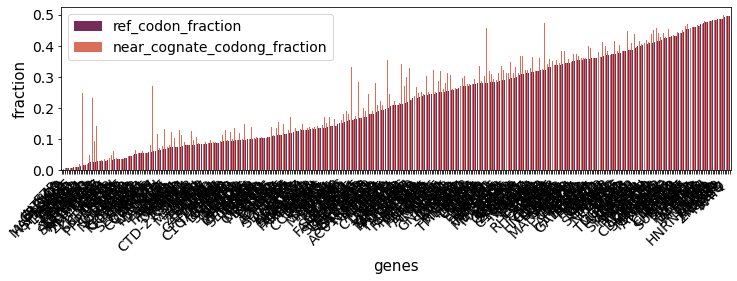

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

# grouped barplot
ax = sns.barplot(x="gene", 
            y="value", 
            hue="variable", 
            data=conservation_df_melt, 
            order=pd.DataFrame(conservation_df_melt.sort_values('value').gene).drop_duplicates().gene,
            palette = 'rocket')
            # order=conservation_df_long.sort_values('fraction').extension);
    
    
ax.set_xticklabels(pd.DataFrame(conservation_df_melt.sort_values('value').gene).drop_duplicates().gene, 
                   rotation = 45, ha="right", fontsize=14)

    
ax.set_yticklabels([np.round(x, 2) for x in np.arange(0, 0.8, 0.1)], fontsize=14)

ax.set_ylabel('fraction', fontsize=15)
ax.set_xlabel('genes', fontsize=15)

plt.legend(fontsize=14, title_fontsize=15)

plt.show()

### plot the most conserved one 

In [42]:
conservation_df.sort_values(by='ref_codon_fraction', ascending=False).head(1)

tr_id  codon_start  nte_start ref_codon  number_of_species  \
309  ENST00000259021.8          202         73       ACG                120   

     ref_codon_count  ref_codon_fraction        counter_codon  \
309              119            0.991667  {'ACG': 119, '': 1}   

     near_cognate_codong_count  near_cognate_codong_fraction  \
309                        119                      0.991667   

                                          dict_animals  \
309  {'Chimp': 'ACG', 'Bonobo': 'ACG', 'Gorilla': '...   

                                                ids_li  gene  
309  [Human, Chimp, Bonobo, Gorilla, Orangutan, Gib...  KAT7

In [43]:
conservation_df.sort_values(by='ref_codon_fraction', ascending=False).head(1).iloc[0].counter_codon

Counter({'ACG': 119, '': 1})

In [44]:
meta[meta['tr_id'] == 'ENST00000285605.7'].iloc[0].gene

'MARVELD1'

In [45]:
R_Set[R_Set['tr_id'] == 'ENST00000285605.7'].N_term_start1.iloc[0]

27

In [46]:
metadata_pc_g25[metadata_pc_g25['tr_id'] == 'ENST00000285605.7'].iloc[0].cds_start_pos+3*50

303

In [47]:
metadata_pc_g25[metadata_pc_g25['tr_id'] == 'ENST00000285605.7'].iloc[0].transcript_seq[27:303]

'GAGGGGAGCAAGGCGAGGAGGCCGCGGCGGGCGCAGCGGGCACCTGGGCCGTGCTGCCCCCGCGAGCAAGGCGCCGCCATTCCGCTGCTCGGGGCGCCGCCGCCGCCGCCACCGCGCCCAGGGGCCATGCTCCCGCCGCCCCCGCGCCAGCCGCCGCCCCAGGCGCGTGCGGCCCGCGGCGCGGTGCGCCTGCAGCGGCCCTTCCTGCGCAGCCCGCTGGGCGTGTTGCGGCTGCTGCAGCTGCTGGCCGGCGCTGCCTTCTGGATCACTATCGCC'

ENST00000285605.7, ATT, ref.codon.frac = 0.68, ref.codon.count = 62, #species = 91, NCcodon_frac = 0.68

In [48]:
def plot_PCSF_score_and_aln_trips2(d,  matrix, figsize=(22, 5), X=45, Y=55, add_point=False):
    
    tr_id = d['tr_id']
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    aln_ax = ax
    
    cmap = colors.ListedColormap(['white', 'limegreen', 'grey', 'purple', 'deepskyblue', 'springgreen', 'red'])
    bounds=[0,  1, 5, 10, 15, 20, 25, 30, 35]
    norm = colors.BoundaryNorm(bounds, cmap.N) 
    aln_ax.imshow(matrix, interpolation='nearest', origin='lower',cmap=cmap, norm=norm, aspect='auto')
    aln_ax.set_xticks(range(0, d['len_codons']))
    aln_ax.set_xlim(0, d['len_codons'])
    aln_ax.set_yticklabels(())
   
    plt.show()
    

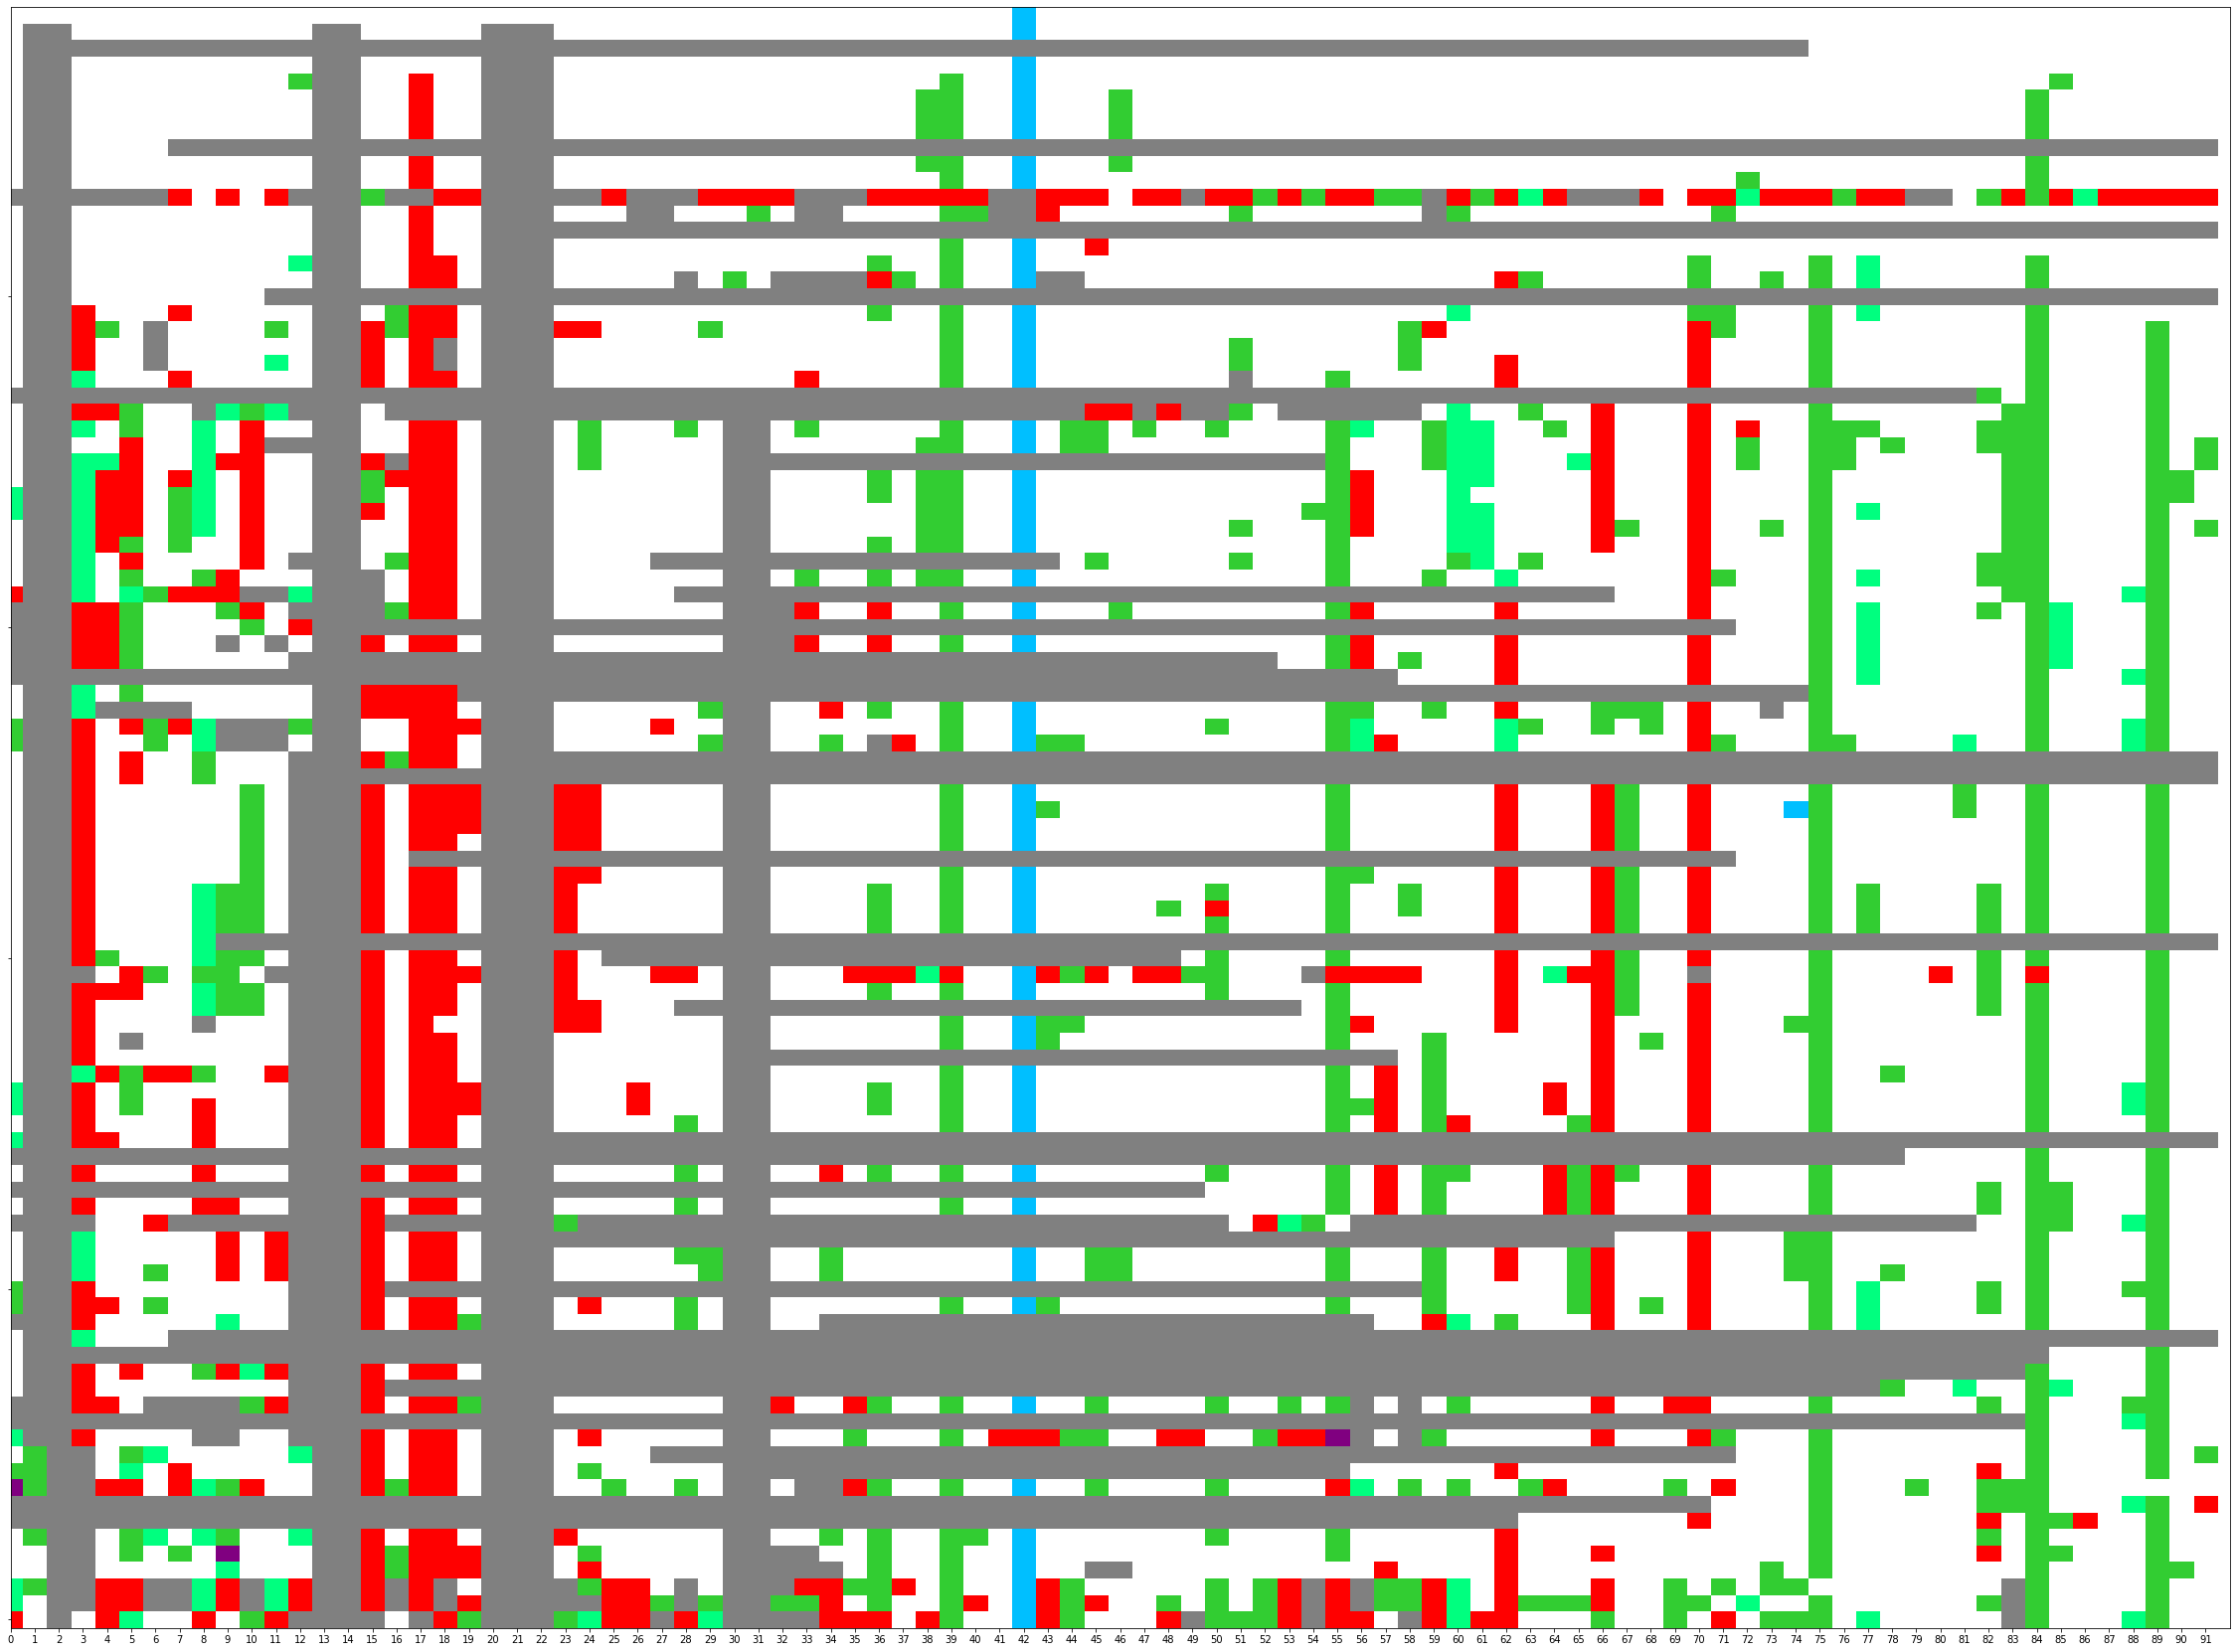

In [49]:
matrix = output_matrix_for_plotting(fasta_input='data/FASTA_aln_NTE_CDS_50codons/MARVELD1_primary_and_50codons_CDS.fasta')

d = prepare_data_for_PCSF_line_plot(tr_id='ENST00000285605.7', 
                                     primary_set=R_Set, 
                                     RES=RES, 
                                     res=res, 
                                     CDS=True)

plot_PCSF_score_and_aln_trips2(d = d, 
                        matrix=matrix,
                figsize=(40, 30), 
                X=45, 
                Y=30, 
                add_point=15) # position of predicted by Trips-viz start in codons 

### trips-viz 

In [65]:
meta[meta['tr_id'] == 'ENST00000285605.7'].iloc[0].gene

'MARVELD1'

947
0


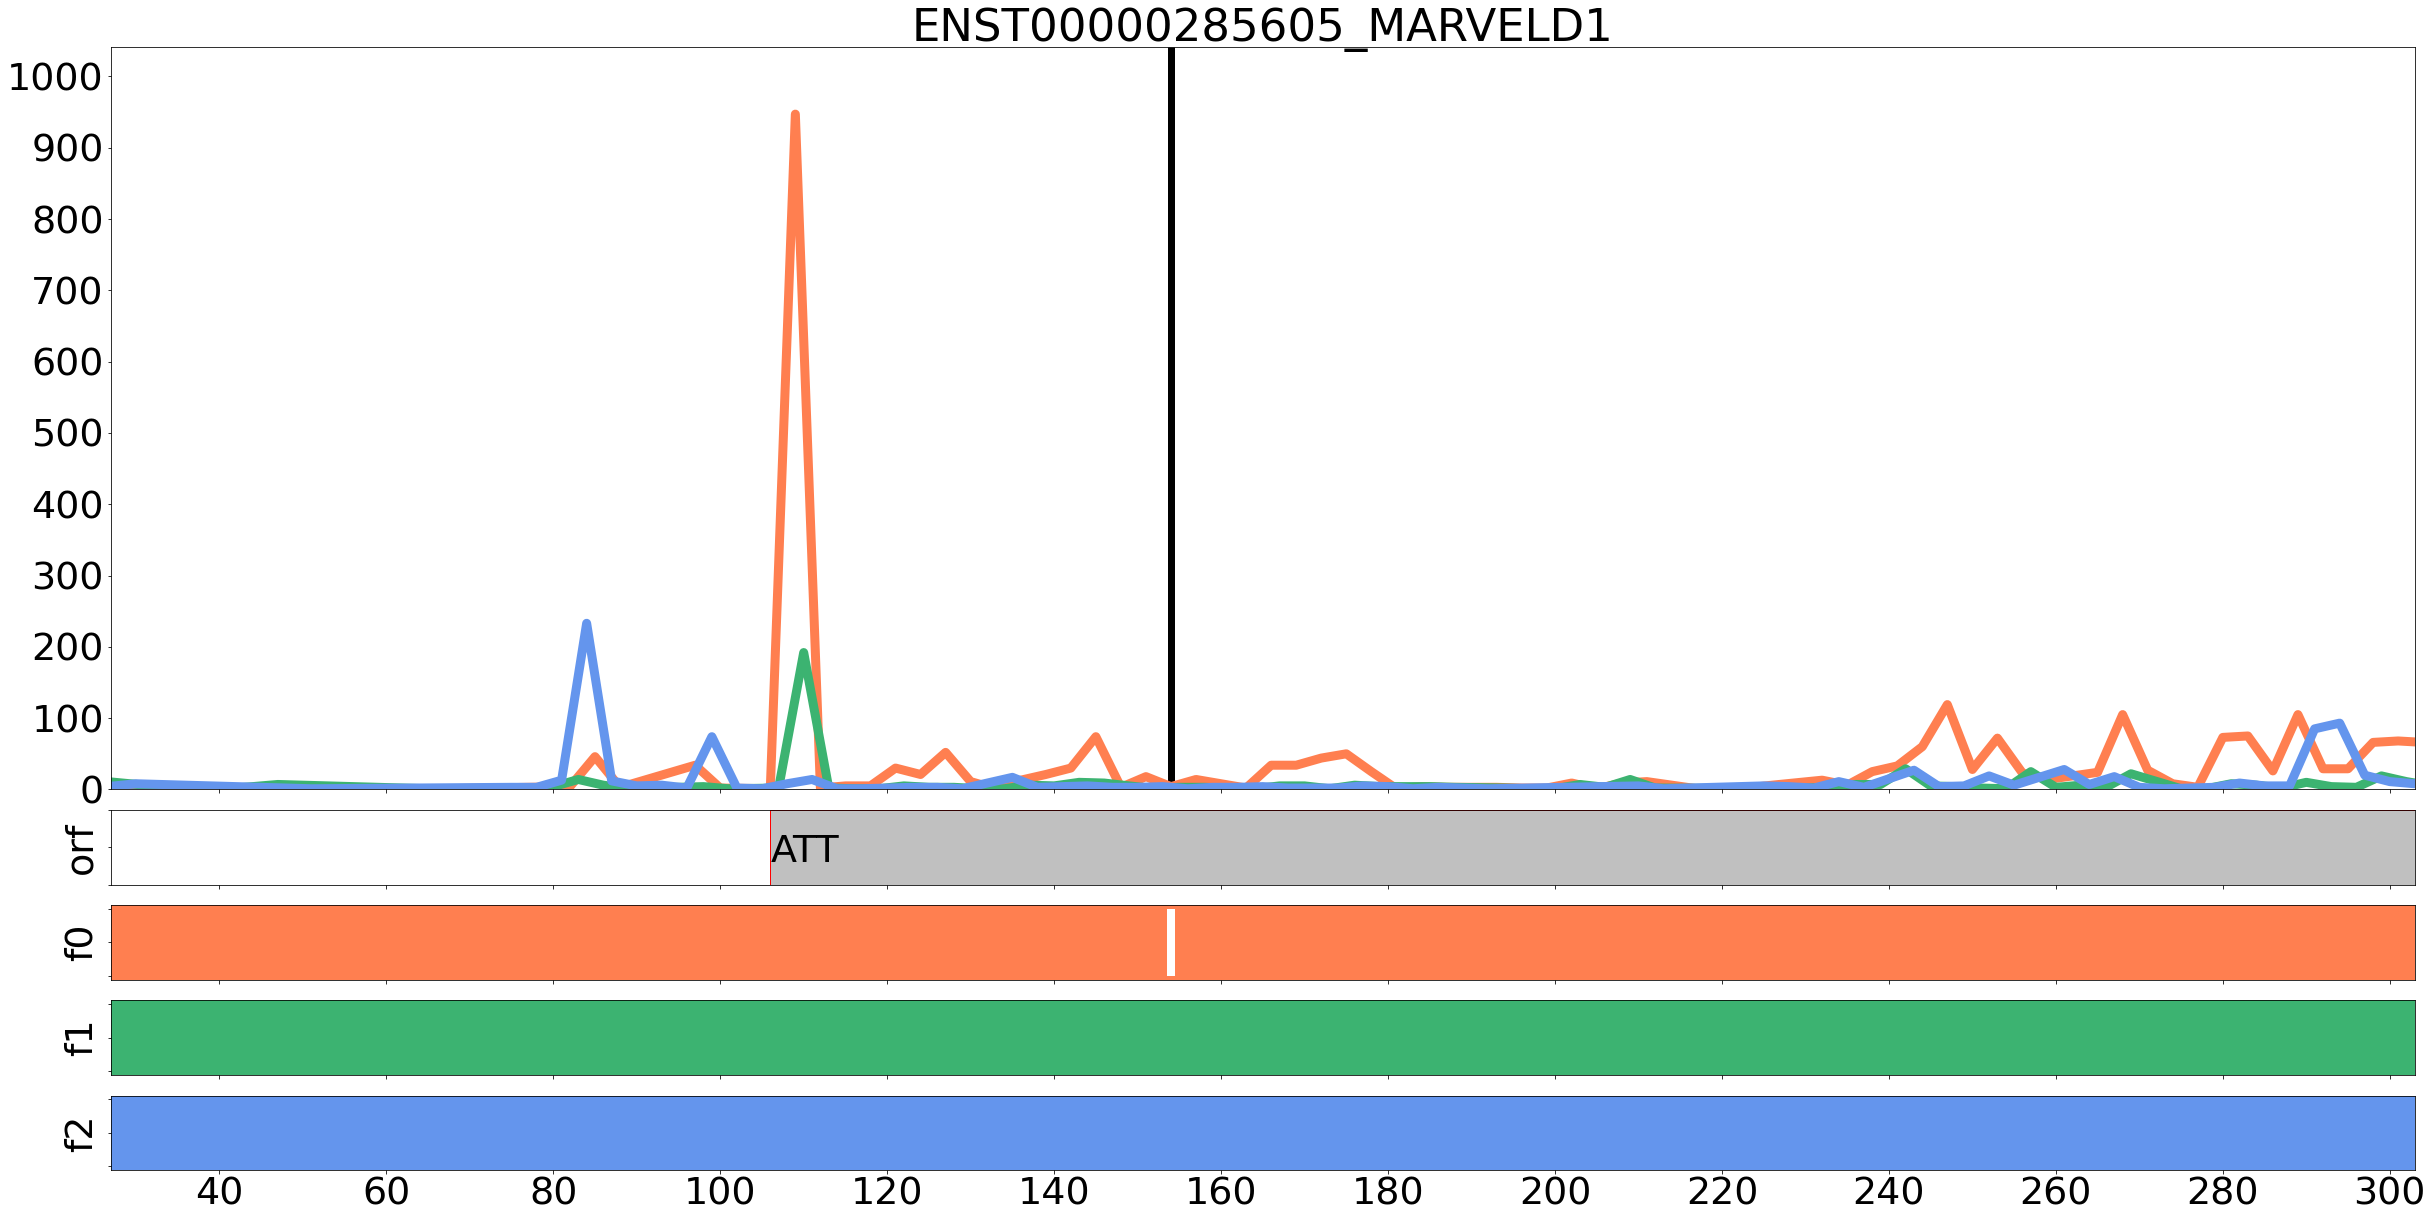

In [66]:
gene = 'MARVELD1'

tr_id = 'ENST00000285605'


pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = pos_pred_start + '_' + pred_start

xlims = [R_Set[R_Set['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 20, 
                             cds = False,
                           figsize=(40, 20),
                           xlims=xlims,
                            zeros=False)

trips_full2(d1)

# Kozak context 

In [50]:
# score all starts: nonAUG and AUG
# nonAUGs scores are normalised already in comparison to the strongest AUG context

li = []

for el in sole_df_sel.to_numpy():
    gene = el[1]
    tr_id = el[0]
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
    
    # nonAUG scores
    codon_start = el[2]
    TIS_nonAUG_seq = tr_seq[codon_start-4:codon_start+4].replace('T', 'U')
    
    #print (TIS_nonAUG_seq)
    
    TIS_nonAUG_score = TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_nonAUG_seq].iloc[0]['TIS Efficiency']
    
    # AUG score 
    cdsAUG_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
    TIS_AUG_seq = tr_seq[cdsAUG_start-6:cdsAUG_start+5].replace('T', 'U')
    
    
    TIS_AUG_score = TIS_AUG_eff[TIS_AUG_eff['sequence'] == TIS_AUG_seq].iloc[0].efficiency
    
    
    li.append([tr_id, gene, TIS_nonAUG_seq, TIS_nonAUG_score, TIS_AUG_seq, TIS_AUG_score])
    
    
TIS_score_df = pd.DataFrame(li, columns = ['tr_id', 'gene', 'TIS_nonAUG_seq', 'TIS_nonAUG_score', 
                            'TIS_AUG_seq', 'TIS_AUG_score'])

TIS_score_df[0:2]

tr_id     gene TIS_nonAUG_seq  TIS_nonAUG_score  TIS_AUG_seq  \
0  ENST00000234115.10  PLEKHB2       AGGAAUCG               0.6  GAAGAGAUGGC   
1   ENST00000341772.4     DNER       CGUCCUGG              37.7  CCGGCCAUGCA   

   TIS_AUG_score  
0            112  
1             91

In [51]:
TIS_score_df_melt = pd.melt(TIS_score_df[['gene', 'TIS_nonAUG_score', 'TIS_AUG_score']],
                        id_vars=['gene'],
                        value_vars=['TIS_nonAUG_score', 'TIS_AUG_score'])

TIS_score_df_melt[0:4]

gene          variable  value
0   PLEKHB2  TIS_nonAUG_score    0.6
1      DNER  TIS_nonAUG_score   37.7
2  SLC25A32  TIS_nonAUG_score    5.1
3    MFSD12  TIS_nonAUG_score   17.4

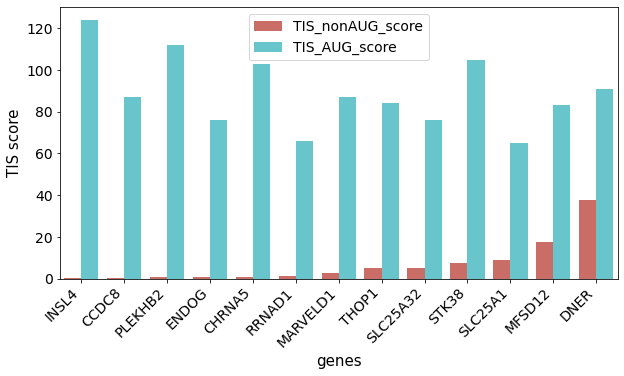

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# grouped barplot
ax = sns.barplot(x="gene", 
            y="value", 
            hue="variable", 
            data=TIS_score_df_melt, 
            order=pd.DataFrame(TIS_score_df_melt.sort_values('value').gene).drop_duplicates().gene,
            palette = "hls")
            # order=conservation_df_long.sort_values('fraction').extension);
    
    
ax.set_xticklabels(pd.DataFrame(TIS_score_df_melt.sort_values('value').gene).drop_duplicates().gene, 
                   rotation = 45, ha="right", fontsize=14)

ax.set_yticks(list(range(0, 130, 20)))    
ax.set_yticklabels(list(range(0, 130, 20)), fontsize=14)

ax.set_ylabel('TIS score', fontsize=15)
ax.set_xlabel('genes', fontsize=15)

plt.legend(fontsize=14, title_fontsize=15)

plt.show()

In [53]:
TIS_AUG_eff.efficiency.min(), TIS_AUG_eff.efficiency.max()

(12, 150)

In [54]:
TIS_efficiency_df['TIS Efficiency'].min(), TIS_efficiency_df['TIS Efficiency'].max()

(0.2, 50.4)

# Compare TIS-scores of sole initiators VS PANTS

### we took quite efficient PANTs = also 14 examples: SFPQ 

In [55]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, name='test.png', linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(5, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1,1]}, sharex=True, sharey=False, )

    main_plot = axes[0]
    #cds = axes[1]
    orfs = axes[1]
    red = axes[2]
    green = axes[3]
    blue = axes[4]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            orfs.add_patch(rect)
        
            orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])
        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    plt.savefig('plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

In [56]:
sole_df[sole_df['gene'] == 'SFPQ']

tr_id  gene codon_type  codon_start  cds_start  cds_stop  \
14  ENST00000357214.5  SFPQ        GTG           36         99      2223   

        cds_frame  height_peak_value_nonAUG  height_peak_value_cds  \
14  Frame Frame 1                     12339                  12120   

    counts_CDS_wo_init  coverage_CDS_wo_init  std_CDS_wo_init  Z_CDS_wo_init  \
14              329010            154.974093       413.553322      28.932245   

        Z_NTE  CDS_ratio  CDS_nte_ratio_coverage  
14  29.461802       0.59                 1.96595

In [57]:
pants_df = sole_df[(sole_df['CDS_nte_ratio_coverage'] >= 0.9) & 
       (sole_df['height_peak_value_nonAUG'] / sole_df['height_peak_value_cds'] < 1.2) & 
       (sole_df['height_peak_value_nonAUG'] / sole_df['height_peak_value_cds'] > 0.9)].sort_values(by='CDS_nte_ratio_coverage', ascending=False)

In [58]:
pants_df_ext = sole_df[(sole_df['CDS_nte_ratio_coverage'] >= 0.9) & 
       (sole_df['height_peak_value_nonAUG'] / sole_df['height_peak_value_cds'] < 1.3) & 
       (sole_df['height_peak_value_nonAUG'] / sole_df['height_peak_value_cds'] > 0.8)].sort_values(by='CDS_nte_ratio_coverage', ascending=False)

In [59]:
pants_df_ext

tr_id      gene codon_type  codon_start  cds_start  \
166   ENST00000221200.8     KCTD9        AGG           95        221   
219   ENST00000309318.7  PPP1R14B        GTG          220        268   
367  ENST00000263202.14     UFD1L        TTG           91        130   
69    ENST00000328834.9    CNOT10        ACG          277        316   
14    ENST00000357214.5      SFPQ        GTG           36         99   
54    ENST00000264255.7    TXNDC9        CTG          184        256   
88    ENST00000429709.6    ACTL6A        CTG          159        213   
1    ENST00000349431.10    UBE2J2        ACG          172        220   
29    ENST00000271715.6      POGZ        AAG          261        315   
353   ENST00000253023.7     UBE2M        CTG          234        579   
21    ENST00000370938.7       CTH        CTG           93        144   
228   ENST00000425380.6     HYLS1        CTG          655        781   
309   ENST00000259021.8      KAT7        ACG          202        280   
195   ENST00000307365.3     DDIT4        CTG          162        201   
177   ENST00000381750.8      RCL1        ATC          148        223   

     cds_stop      cds_frame  height_peak_value_nonAUG  height_peak_value_cds  \
166      1391  Frame Frame 3                       200                    162   
219       712  Frame Frame 2                      1317                   1573   
367      1054  Frame Frame 2                      2292                   2393   
69       2551  Frame Frame 2                       688                    723   
14       2223  Frame Frame 1                     12339                  12120   
54        937  Frame Frame 2                      1052                   1076   
88       1503  Frame Frame 1                      5058                   5446   
1        1000  Frame Frame 2                      1001                    881   
29       4548  Frame Frame 1                       480                    404   
353      1131  Frame Frame 1                       650                    803   
21       1362  Frame Frame 1                       433                    423   
228      1681  Frame Frame 2                       509                    574   
309      2116  Frame Frame 2                       263                    256   
195       900  Frame Frame 1                      3143                   3641   
177      1345  Frame Frame 2                       340                    361   

     counts_CDS_wo_init  coverage_CDS_wo_init  std_CDS_wo_init  Z_CDS_wo_init  \
166                 250              0.213858         3.359363      48.159774   
219                1385              3.126411        29.732097      52.800635   
367               23901             25.894908        94.512748      25.045352   
69                32522             14.557744        33.966260      20.857235   
14               329010            154.974093       413.553322      28.932245   
54                14291             21.016176        82.878515      12.729280   
88                77035             59.763382       124.483444      43.268699   
1                 25762             33.070603        73.522076      11.532990   
29                43267             10.223771        25.141288      15.662532   
353               10499             19.054446       119.391777       6.566160   
21                10407              8.551356        20.565886      20.152239   
228                5785              6.434928        14.196889      39.978130   
309               18973             10.339510        32.149832       7.641113   
195               85304            122.212034       290.469175      12.114153   
177               26400             23.550401        54.540375       6.187152   

         Z_NTE  CDS_ratio  CDS_nte_ratio_coverage  
166  59.471444   9.195071               16.272538  
219  44.190412   4.029104               10.747887  
367  23.976714   0.821499                3.044661  
69   19.826800   1.436887                2.508127  
14   29.461

308
0


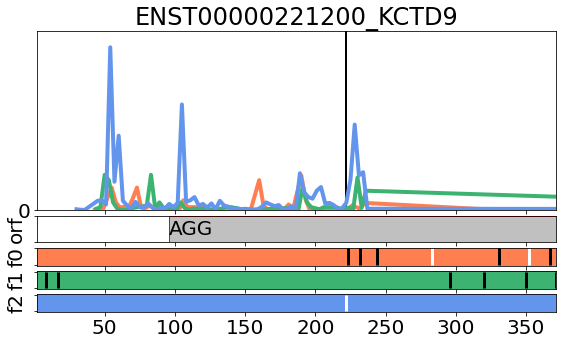

In [60]:
gene = 'KCTD9'

tr_id = 'ENST00000221200'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

2292
0


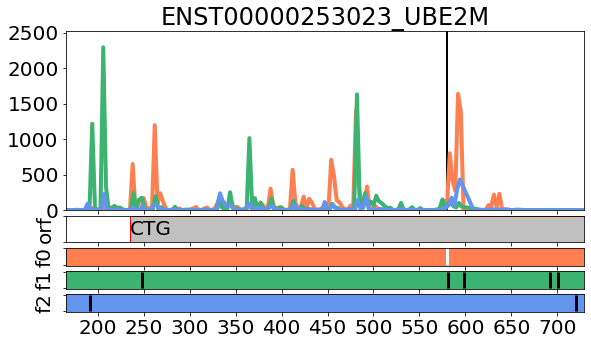

In [61]:
gene = 'UBE2M'

tr_id = 'ENST00000253023'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

3641
0


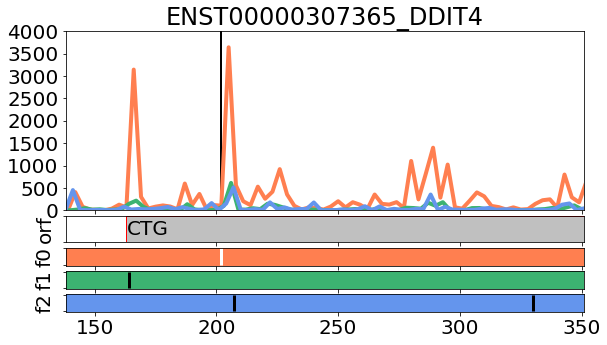

In [62]:
gene = 'DDIT4'

tr_id = 'ENST00000307365'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

574
0


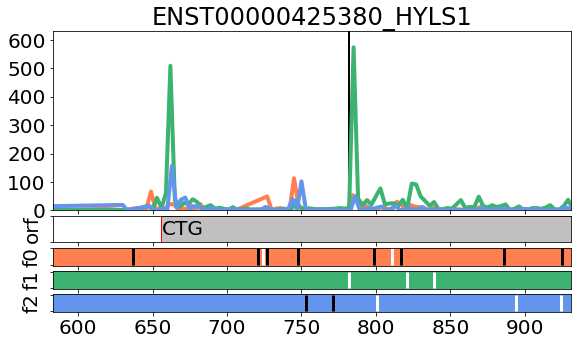

In [63]:
gene = 'HYLS1'

tr_id = 'ENST00000425380'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

1573
0


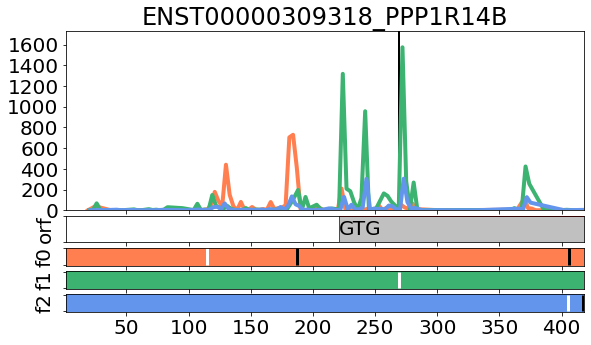

In [64]:
gene = 'PPP1R14B'

tr_id = 'ENST00000309318'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

525
0


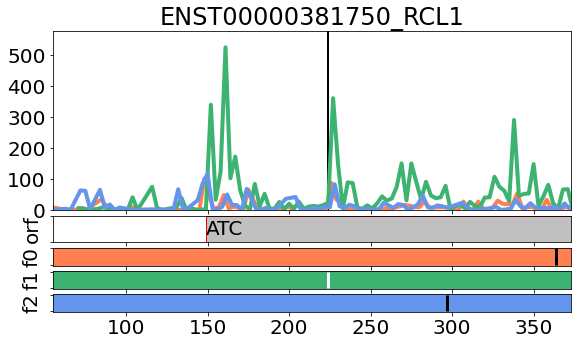

In [65]:
gene = 'RCL1'

tr_id = 'ENST00000381750'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

502
0


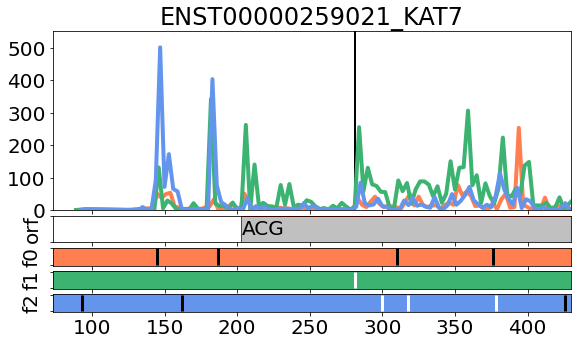

In [66]:
gene = 'KAT7'

tr_id = 'ENST00000259021'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

433
0


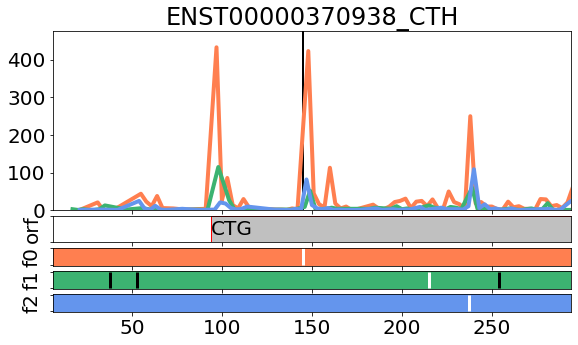

In [67]:
gene = 'CTH'

tr_id = 'ENST00000370938'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+0) + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

480
0


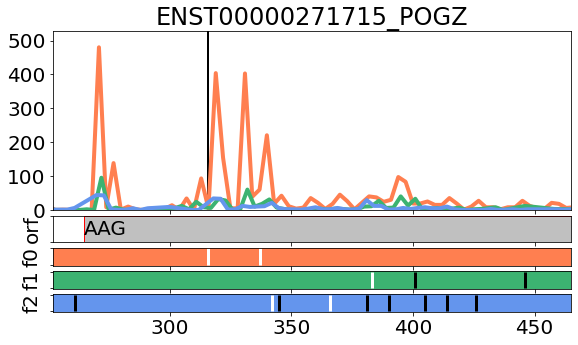

In [68]:
gene = 'POGZ'

tr_id = 'ENST00000271715'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = str(int(pos_pred_start)+3) + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

1001
0


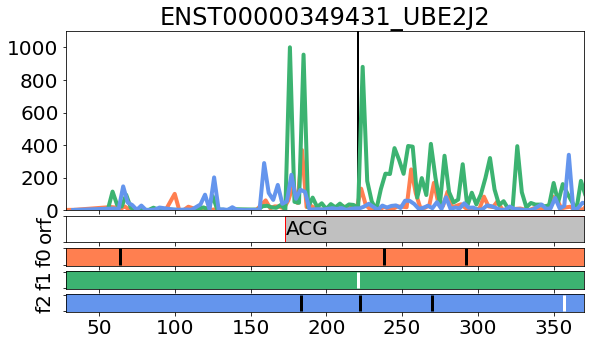

In [69]:
gene = 'UBE2J2'

tr_id = 'ENST00000349431'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 

pre_st = pos_pred_start + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

5446
0


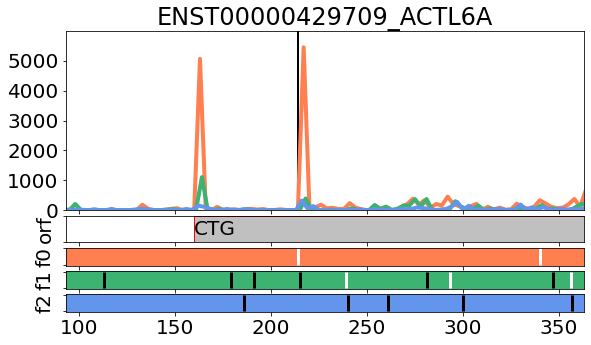

In [70]:
gene = 'ACTL6A'

tr_id = 'ENST00000429709'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 

pre_st = pos_pred_start + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

1076
0


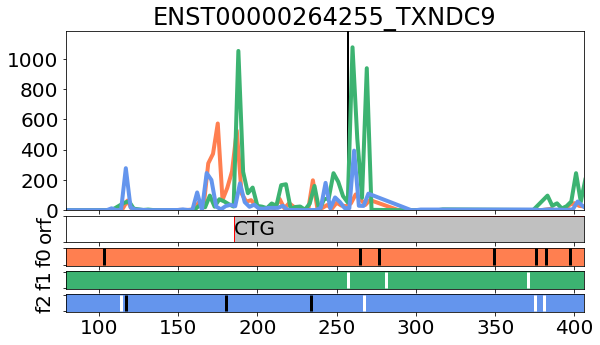

In [71]:
gene = 'TXNDC9'

tr_id = 'ENST00000264255'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 

pre_st = pos_pred_start + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

723
0


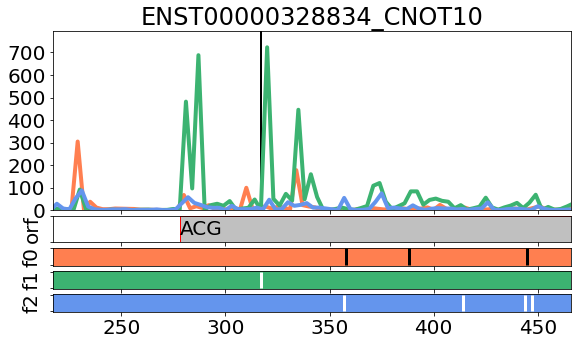

In [72]:
gene = 'CNOT10'

tr_id = 'ENST00000328834'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 

pre_st = pos_pred_start + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

2393
0


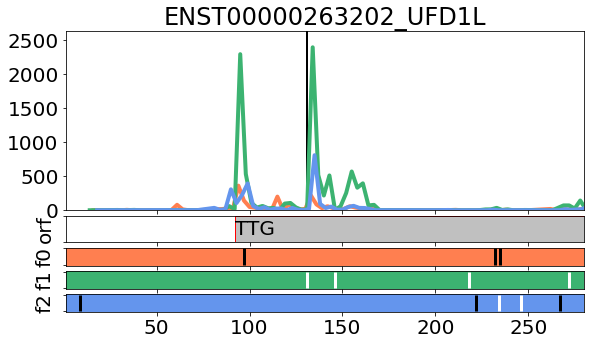

In [90]:
gene = 'UFD1L'

tr_id = 'ENST00000263202'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 

pre_st = pos_pred_start + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

12339
0


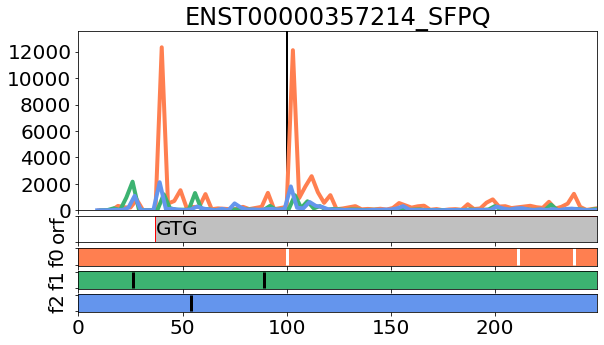

In [91]:
gene = 'SFPQ'

tr_id = 'ENST00000357214'


pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 

pre_st = pos_pred_start + '_' + pred_start

xlims = [meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_RiboSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name='SFPQ', font1=20, font2=24)

# TIS-score for PANTs 

In [92]:
pants_df[0:2]

tr_id    gene codon_type  codon_start  cds_start  cds_stop  \
367  ENST00000263202.14   UFD1L        TTG           91        130      1054   
69    ENST00000328834.9  CNOT10        ACG          277        316      2551   

         cds_frame  height_peak_value_nonAUG  height_peak_value_cds  \
367  Frame Frame 2                      2292                   2393   
69   Frame Frame 2                       688                    723   

     counts_CDS_wo_init  coverage_CDS_wo_init  std_CDS_wo_init  Z_CDS_wo_init  \
367               23901             25.894908        94.512748      25.045352   
69                32522             14.557744        33.966260      20.857235   

         Z_NTE  CDS_ratio  CDS_nte_ratio_coverage  
367  23.976714   0.821499                3.044661  
69   19.826800   1.436887                2.508127

In [93]:
sole_df_sel[0:3]

tr_id      gene  codon_start codon_type  cds_start  \
58   ENST00000234115.10   PLEKHB2          415        ATC        463   
66    ENST00000341772.4      DNER          102        CTG        135   
172   ENST00000297578.8  SLC25A32           29        TTG        167   

     Z_CDS_wo_init      Z_NTE  height_peak_value_nonAUG  \
58       -0.348650  11.768322                      1482   
66       -0.256842   5.982218                       315   
172      -0.242497   3.338496                       309   

     height_peak_value_cds  CDS_ratio  CDS_nte_ratio_coverage  
58                      10   1.227975                1.052199  
66                       2   0.199931                0.920532  
172                     14   0.776933                1.259314

In [76]:
# score all starts: nonAUG and AUG
# nonAUGs scores are normalised already in comparison to the strongest AUG context

li = []

for el in pants_df.to_numpy():
    gene = el[1]
    tr_id = el[0]
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
    
    # nonAUG scores
    codon_start = el[3]
    TIS_nonAUG_seq = tr_seq[codon_start-4:codon_start+4].replace('T', 'U')
    
    #print (TIS_nonAUG_seq)
    
    TIS_nonAUG_score = TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_nonAUG_seq].iloc[0]['TIS Efficiency']
    
    # AUG score 
    cdsAUG_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
    TIS_AUG_seq = tr_seq[cdsAUG_start-6:cdsAUG_start+5].replace('T', 'U')
    
    
    TIS_AUG_score = TIS_AUG_eff[TIS_AUG_eff['sequence'] == TIS_AUG_seq].iloc[0].efficiency
    
    
    li.append([tr_id, gene, TIS_nonAUG_seq, TIS_nonAUG_score, TIS_AUG_seq, TIS_AUG_score])
    
    
TIS_score_df_pants = pd.DataFrame(li, columns = ['tr_id', 'gene', 'TIS_nonAUG_seq', 'TIS_nonAUG_score', 
                            'TIS_AUG_seq', 'TIS_AUG_score'])

TIS_score_df_pants[0:2]

tr_id    gene TIS_nonAUG_seq  TIS_nonAUG_score  TIS_AUG_seq  \
0  ENST00000263202.14   UFD1L       UGCAUUGC               0.3  UCCAUCAUGUU   
1   ENST00000328834.9  CNOT10       GGCCACGC               0.9  GGGAAGAUGGC   

   TIS_AUG_score  
0            129  
1            113

In [77]:
TIS_score_df_melt_pants = pd.melt(TIS_score_df_pants[['gene', 'TIS_nonAUG_score', 'TIS_AUG_score']],
                        id_vars=['gene'],
                        value_vars=['TIS_nonAUG_score', 'TIS_AUG_score'])

TIS_score_df_melt_pants[0:4]

gene          variable  value
0   UFD1L  TIS_nonAUG_score    0.3
1  CNOT10  TIS_nonAUG_score    0.9
2    SFPQ  TIS_nonAUG_score    9.6
3  TXNDC9  TIS_nonAUG_score    1.3

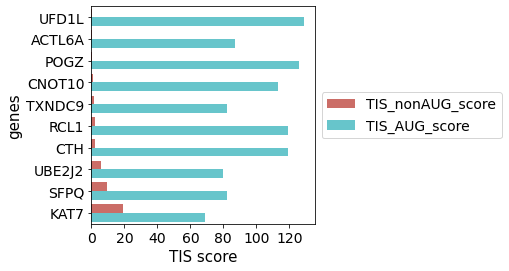

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# grouped barplot
ax = sns.barplot(x="value", 
            y="gene", 
            hue="variable", 
            data=TIS_score_df_melt_pants, 
            order=pd.DataFrame(TIS_score_df_melt_pants.sort_values('value').gene).drop_duplicates().gene,
            palette = "hls")

ax.set_xticks(list(range(0, 130, 20)))    
ax.set_xticklabels(list(range(0, 130, 20)), fontsize=14)

ax.set_yticklabels(pd.DataFrame(TIS_score_df_melt_pants.sort_values('value').gene).drop_duplicates().gene, 
                   rotation = 0, ha="right", fontsize=14)

ax.set_xlabel('TIS score', fontsize=15)
ax.set_ylabel('genes', fontsize=15)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, title_fontsize=15)

plt.show()

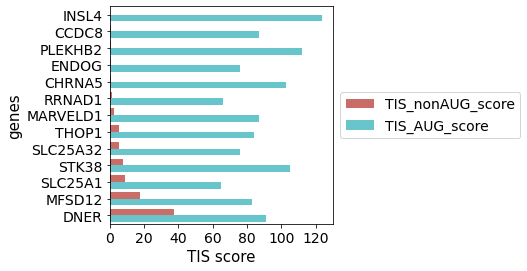

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# grouped barplot
ax = sns.barplot(x="value", 
            y="gene", 
            hue="variable", 
            data=TIS_score_df_melt, 
            order=pd.DataFrame(TIS_score_df_melt.sort_values('value').gene).drop_duplicates().gene,
            palette = "hls")

ax.set_xticks(list(range(0, 130, 20)))    
ax.set_xticklabels(list(range(0, 130, 20)), fontsize=14)

ax.set_yticklabels(pd.DataFrame(TIS_score_df_melt.sort_values('value').gene).drop_duplicates().gene, 
                   rotation = 0, ha="right", fontsize=14)

ax.set_xlabel('TIS score', fontsize=15)
ax.set_ylabel('genes', fontsize=15)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, title_fontsize=15)

plt.show()

----------

# Plot nonAUG / AUG ratios for exclusive and PANTs 

In [80]:
TIS_score_df['ratio'] = TIS_score_df['TIS_AUG_score'] / TIS_score_df['TIS_nonAUG_score']
TIS_score_df['class'] = 'exclusive'
TIS_score_df[0:2]

tr_id     gene TIS_nonAUG_seq  TIS_nonAUG_score  TIS_AUG_seq  \
0  ENST00000234115.10  PLEKHB2       AGGAAUCG               0.6  GAAGAGAUGGC   
1   ENST00000341772.4     DNER       CGUCCUGG              37.7  CCGGCCAUGCA   

   TIS_AUG_score       ratio      class  
0            112  186.666667  exclusive  
1             91    2.413793  exclusive

In [81]:
TIS_score_df_pants['ratio'] = TIS_score_df_pants['TIS_AUG_score'] / TIS_score_df_pants['TIS_nonAUG_score']
TIS_score_df_pants['class'] = 'PANTs'
TIS_score_df_pants[0:2]

tr_id    gene TIS_nonAUG_seq  TIS_nonAUG_score  TIS_AUG_seq  \
0  ENST00000263202.14   UFD1L       UGCAUUGC               0.3  UCCAUCAUGUU   
1   ENST00000328834.9  CNOT10       GGCCACGC               0.9  GGGAAGAUGGC   

   TIS_AUG_score       ratio  class  
0            129  430.000000  PANTs  
1            113  125.555556  PANTs

In [82]:
tmp = pd.concat([TIS_score_df[['gene', 'class', 'ratio']], TIS_score_df_pants[['gene', 'class', 'ratio']]])

colors = []
for gene in pd.DataFrame(tmp.sort_values('ratio').gene).drop_duplicates().gene.tolist():
    type_ = tmp[tmp['gene'] == gene].iloc[0]['class']
    if type_ == 'PANTs':
        colors.append('goldenrod')
    else:
        colors.append('palevioletred')

tmp[0:2]

gene      class       ratio
0  PLEKHB2  exclusive  186.666667
1     DNER  exclusive    2.413793

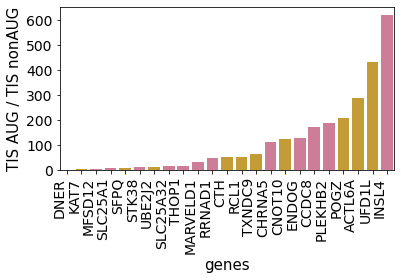

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# grouped barplot
ax = sns.barplot(y="ratio", 
            x="gene", 
            data=tmp, 
            order=pd.DataFrame(tmp.sort_values('ratio').gene).drop_duplicates().gene,
            palette = colors)

for label in ax.get_xticklabels():
    label.set_rotation(90)
    
ax.set_ylabel('TIS AUG / TIS nonAUG', fontsize=15)
ax.set_xlabel('genes', fontsize=15)

ax.set_yticks(list(range(0, 700, 100)))    
ax.set_yticklabels(list(range(0, 700, 100)), fontsize=14)

ax.set_xticklabels(pd.DataFrame(tmp.sort_values('ratio').gene).drop_duplicates().gene, 
                   rotation = 90, ha="right", fontsize=14)


plt.show()

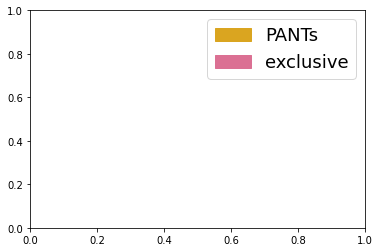

In [174]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

plt.rcParams["legend.fontsize"] = 18


red_patch = mpatches.Patch(color='goldenrod', label='PANTs')
blue_patch = mpatches.Patch(color='palevioletred', label='exclusive')

plt.legend(handles=[red_patch, blue_patch])


# RiboSET & PhyloSET: get theoretical extensions and max TIS score for all TISs within it 

In [126]:
#TIS_score_df

# all in-frame near-cognate codons and TIS for them 

# select max TIS per transcript and plot it 

In [134]:
li = []

j = 0

for row in R_Set[['tr_id', 'gene', 'N_term_start1', 'N_term_end1']].to_numpy():
    tr_id = row[0]
    gene = row[1]
    ntermstart = row[2]
    ntermstop = row[3]
    
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
    cdsAUG_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
   
    # AUG CDS TIS
    
    TIS_AUG_seq = tr_seq[cdsAUG_start-6:cdsAUG_start+5].replace('T', 'U')
    try:
        TIS_AUG_score = TIS_AUG_eff[TIS_AUG_eff['sequence'] == TIS_AUG_seq].iloc[0].efficiency
    except:
        TIS_AUG_score = None
        continue
    
    
    
    # all TIS in theoretical ext 
    li1 = []
    
    nte_seq = tr_seq[ntermstart:ntermstop]
    #print (gene)
    #print (nte_seq)
    
    # in-frame codons 
    # TIS score for only 3 codon and next 
    for x in [(i, nte_seq[i:i+3]) for i in range(0, len(nte_seq), 3)]:
        codon_numb = x[0]
        codon_seq = x[1]
        if codon_numb >= 6: # skip 2 codons
            TIS_seq = nte_seq[codon_numb-4:codon_numb+4].replace('T', 'U')  
            if len(TIS_seq) == 8:
                try:
                    li1.append(TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])
                except:
                    continue
    
    j += 1
    print (j, tr_id, gene, li1)
                    
    # find max 
    
    max_nonAUG_TIS = np.max(np.array(li1))
    
    li.append([tr_id, gene, max_nonAUG_TIS, TIS_AUG_score])

1 ENST00000379389.4 ISG15 [1.2, 0.5, 0.2, 0.2, 0.6, 0.5, 2.2]
2 ENST00000349431.10 UBE2J2 [1.1, 3.7, 1.1, 5.5, 1.5]
3 ENST00000338370.7 AURKAIP1 [2.8, 0.2, 0.6, 0.6, 0.6, 2.3, 0.6, 0.2, 0.2, 1.0, 0.2, 0.2, 0.9, 0.3, 1.1, 1.3, 0.2]
4 ENST00000235310.7 MAD2L2 [0.2, 0.6]
5 ENST00000356634.7 KDM1A [4.6, 0.6, 0.2, 3.3]
6 ENST00000374612.5 HNRNPR [0.3, 3.6, 0.3, 3.2, 0.8]
7 ENST00000617979.4 GALE [5.6, 0.2, 3.8, 1.0, 0.2]
8 ENST00000399728.5 STMN1 [1.5, 0.6, 0.2, 0.2, 0.8, 0.8, 0.4, 1.3]
9 ENST00000321265.9 NUDC [1.1, 2.1, 0.2]
10 ENST00000327300.11 KHDRBS1 [0.2, 0.2, 1.6, 0.8]
11 ENST00000373493.9 RBBP4 [3.7, 0.6, 3.6, 0.2]
12 ENST00000373477.8 YARS [0.2, 4.0, 0.2]
13 ENST00000521580.2 SMIM12 [0.2, 0.2, 4.9, 0.2, 50.4, 2.3]
14 ENST00000611874.4 ZMYM1 [0.8, 0.2, 0.4, 0.6, 0.4, 3.0, 0.6, 0.6, 0.5, 0.8, 18.4]
15 ENST00000357214.5 SFPQ [2.8, 0.2, 0.3, 9.6, 1.8, 0.9]
16 ENST00000321358.11 YBX1 [2.3, 0.7, 0.4, 1.9]
17 ENST00000371655.3 RAB3B [0.9, 0.6]
18 ENST00000313334.12 BTF3L4 [0.6, 0.2, 1.1,

135 ENST00000229794.8 MAPK14 [0.7, 0.3, 1.0, 0.4, 0.6, 0.3, 8.9, 0.2, 0.6, 0.8]
136 ENST00000229812.7 STK38 [0.8, 0.6, 7.7, 7.3]
137 ENST00000355773.5 SLC17A5 [0.6, 0.3, 0.4, 0.3, 2.6, 0.9, 5.7, 1.1]
138 ENST00000369750.3 TPBG [2.0, 0.4, 24.7, 0.2, 2.3, 14.1, 0.6, 1.6, 4.9, 0.2, 0.3, 2.9, 0.3, 0.4, 0.6, 0.6, 0.4, 0.9]
139 ENST00000369622.7 SYNCRIP [0.3, 0.7, 0.3, 0.2, 0.2, 0.2, 0.2, 0.6, 0.2, 0.5, 0.2, 0.3, 0.2, 0.3, 0.2, 0.5, 18.4, 0.2, 1.2, 0.2, 3.4, 0.5]
140 ENST00000612661.1 MARCKS [0.5, 1.3, 0.5, 0.8, 1.1, 0.2]
141 ENST00000367976.3 CTGF [9.1, 2.6, 0.6, 1.6]
142 ENST00000607197.5 HEBP2 [0.6, 0.3, 0.7, 0.4, 0.2, 1.2]
143 ENST00000367495.3 RAB32 [33.0, 22.8]
144 ENST00000367075.3 EZR [0.6, 4.9, 1.9, 1.3, 0.4]
145 ENST00000356956.5 IGF2R [20.0]
146 ENST00000343242.8 MAFK [0.2, 0.2, 0.6, 0.6, 1.8, 0.6, 5.0, 1.3, 0.2]
147 ENST00000406869.5 MAD1L1 [1.4, 2.0, 0.2, 0.2, 1.6, 1.0, 5.1, 0.2, 0.6, 1.5, 1.4, 0.5, 0.2, 0.3, 0.2, 0.4, 1.8, 0.6, 2.2, 7.1, 0.7, 0.2, 1.6, 3.4, 0.8, 1.7, 0.7]
148 E

254 ENST00000216281.12 HSP90AA1 [0.6, 0.3, 1.7, 0.4, 2.8, 0.2, 0.8, 1.8]
255 ENST00000348956.6 CKB [2.0, 1.1, 2.8]
256 ENST00000300289.9 PDIA3 [2.1, 0.6, 0.3]
257 ENST00000267812.3 MFAP1 [0.6, 0.7, 0.3, 1.4]
258 ENST00000261854.9 SPPL2A [1.6, 3.8, 33.0, 0.6, 0.2, 0.3, 4.2, 1.0, 4.2]
259 ENST00000345330.8 NPTN [0.2, 1.1, 11.0, 0.6, 0.4, 0.2]
260 ENST00000299565.9 CHRNA5 [2.0, 0.8, 0.9, 0.6, 0.4]
261 ENST00000332810.3 AEN [0.4, 1.2, 0.6, 4.2, 0.3, 0.3, 1.8, 1.3]
262 ENST00000355112.7 BLM [1.8, 0.3, 2.5, 0.2, 19.2, 0.6, 0.6, 0.2]
263 ENST00000361188.9 PRC1 [0.2, 7.0, 0.8, 0.4, 0.3, 5.0, 0.3, 7.3, 0.2, 1.3, 0.6, 0.2, 6.9, 0.6, 1.7, 0.2, 0.2, 12.7, 18.4, 0.8]
264 ENST00000383018.7 SNRNP25 [0.5, 0.4, 1.7, 20.3, 4.1, 1.1]
265 ENST00000268668.10 NDUFB10 [0.3, 1.7, 0.2]
266 ENST00000568546.5 TBL3 [0.9, 2.3, 2.5]
267 ENST00000330398.8 ATP6V0C [0.3, 0.2, 0.4, 0.5, 10.7, 0.6, 2.6, 1.3, 0.6]
268 ENST00000304735.3 VASN [0.5, 0.2, 3.2, 0.2, 1.3]
269 ENST00000327827.11 C16orf72 [0.2, 0.4, 0.2, 1.3, 1.

384 ENST00000332687.10 RLIM [0.8, 0.4, 2.4, 0.7, 0.7, 0.2]
385 ENST00000539247.5 ARMCX6 [0.6, 8.5, 42.2, 1.4, 0.7, 0.2, 0.6, 0.5]
386 ENST00000372661.3 TCEAL9 [0.5, 24.7, 0.5, 0.3, 2.5, 0.2, 0.2, 0.6, 0.3, 1.3, 0.2, 1.4, 0.3, 0.3, 0.3]
387 ENST00000371335.4 LAMP2 [0.2, 0.5, 0.3, 2.5, 0.8, 0.2, 0.4, 0.2, 0.2, 0.6]
388 ENST00000304661.5 C1GALT1C1 [21.3, 0.2, 14.0, 4.6]
389 ENST00000371122.8 SMARCA1 [0.2, 0.3, 0.2, 0.2]
390 ENST00000330374.6 VMA21 [0.2, 1.4, 0.2]
391 ENST00000370274.7 NSDHL [0.2, 0.2, 3.6, 0.2, 0.2, 1.3, 0.3, 0.5, 0.4, 1.4]
392 ENST00000447750.6 GDI1 [0.6, 2.2, 2.5, 0.8, 0.3, 1.9]
393 ENST00000381401.10_PAR_Y SLC25A6 [1.2]
394 ENST00000381192.8_PAR_Y CD99 [0.3, 2.3]


In [136]:
r_set_max_TIS = pd.DataFrame(li, columns = ['tr_id', 'gene', 'max_nonAUG_TIS', 'TIS_AUG_score'])

# Same with PhyloSET 

In [137]:
li = []

j = 0

for row in P_Set[['tr_id', 'gene', 'N_term_start1', 'N_term_end1']].to_numpy():
    tr_id = row[0]
    gene = row[1]
    ntermstart = row[2]
    ntermstop = row[3]
    
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].transcript_seq
    cdsAUG_start = metadata_pc_g25[metadata_pc_g25['tr_id'] == tr_id].iloc[0].cds_start_pos
   
    # AUG CDS TIS
    
    TIS_AUG_seq = tr_seq[cdsAUG_start-6:cdsAUG_start+5].replace('T', 'U')
    try:
        TIS_AUG_score = TIS_AUG_eff[TIS_AUG_eff['sequence'] == TIS_AUG_seq].iloc[0].efficiency
    except:
        TIS_AUG_score = None
        continue
    
    
    
    # all TIS in theoretical ext 
    li1 = []
    
    nte_seq = tr_seq[ntermstart:ntermstop]
    #print (gene)
    #print (nte_seq)
    
    # in-frame codons 
    # TIS score for only 3 codon and next 
    for x in [(i, nte_seq[i:i+3]) for i in range(0, len(nte_seq), 3)]:
        codon_numb = x[0]
        codon_seq = x[1]
        if codon_numb >= 6: # skip 2 codons
            TIS_seq = nte_seq[codon_numb-4:codon_numb+4].replace('T', 'U')  
            if len(TIS_seq) == 8:
                try:
                    li1.append(TIS_efficiency_df[TIS_efficiency_df['TIS Sequence'] == TIS_seq].iloc[0]['TIS Efficiency'])
                except:
                    continue
    
    j += 1
    print (j, tr_id, gene, li1)
                    
    # find max 
    
    max_nonAUG_TIS = np.max(np.array(li1))
    
    li.append([tr_id, gene, max_nonAUG_TIS, TIS_AUG_score])

1 ENST00000377898.3 HES3 [0.6, 1.9, 0.3]
2 ENST00000400907.6 RERE [0.2, 0.2, 0.2, 1.4]
3 ENST00000455833.6 IFFO2 [0.5, 0.4, 0.6, 2.0, 1.2, 50.4, 42.2, 18.4, 4.2]
4 ENST00000373824.8 TAF12 [0.3, 0.6, 0.6, 0.6, 1.3, 0.3]
5 ENST00000357214.5 SFPQ [2.8, 0.2, 0.3, 9.6, 1.8, 0.9]
6 ENST00000635322.1 OAZ3 [0.2]
7 ENST00000627780.2 OAZ3 [0.2]
8 ENST00000321531.10 OAZ3 [0.2]
9 ENST00000368061.2 VANGL2 [1.3, 1.8, 0.5, 0.2, 0.3, 3.3, 0.6, 3.7, 1.4, 0.6, 1.0, 0.6, 0.3, 0.3, 0.7, 0.3, 1.8, 1.2, 0.6, 0.6, 20.3, 0.6]
10 ENST00000636345.1 NRXN1 [0.2, 0.5, 0.4, 2.0, 0.3, 1.9]
11 ENST00000272520.3 C1QL2 [14.1, 5.0, 4.9, 0.6, 18.4, 0.8, 1.2, 2.9, 0.4]
12 ENST00000392915.6 MAP3K19 [1.0, 0.2, 0.9, 0.3, 0.3, 0.5]
13 ENST00000287766.8 SLC6A1 [2.2, 0.6, 0.3, 1.7, 0.2]
14 ENST00000232974.10 ZBTB47 [1.0, 2.3, 0.3, 9.3, 0.8, 1.9, 1.1]
15 ENST00000462833.5 ADCY5 [0.6, 0.2, 2.5, 0.2, 14.2, 0.4, 1.7, 6.1, 0.8]
16 ENST00000333762.5 H1FX [0.2, 0.2, 1.5, 0.6, 5.9]
17 ENST00000476941.5 TRPC1 [2.2, 50.4, 7.1, 3.5, 0.2, 

In [138]:
p_set_max_TIS = pd.DataFrame(li, columns = ['tr_id', 'gene', 'max_nonAUG_TIS', 'TIS_AUG_score'])

In [143]:
p_set_max_TIS = p_set_max_TIS[['gene', 'max_nonAUG_TIS', 'TIS_AUG_score']].drop_duplicates()
p_set_max_TIS.shape[0], r_set_max_TIS.shape[0]

(60, 394)

# Plot distribution 

### r_set: aug and nonAUG 

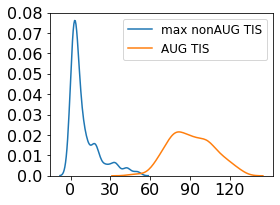

In [185]:
plt.rcParams["legend.fontsize"] = 12

fig, ax = plt.subplots(1, figsize=(4,3))

ax = sns.distplot(r_set_max_TIS[['max_nonAUG_TIS']], hist=False, rug=False, label='max nonAUG TIS')
ax = sns.distplot(r_set_max_TIS[['TIS_AUG_score']], hist=False, rug=False,  label='AUG TIS')

ax.set_xticks(np.arange(0, 150, 30))
ax.set_xticklabels(np.arange(0, 150, 30), fontsize=16)

ax.set_yticks(np.arange(0, 0.09, 0.01))
ax.set_yticklabels(np.arange(0, 0.09, 0.01), fontsize=16)

plt.show()

### p_set: aug and nonAUG 

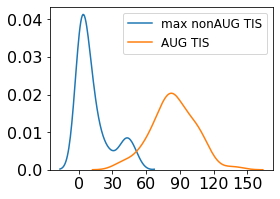

In [188]:
fig, ax = plt.subplots(1, figsize=(4, 3))

ax = sns.distplot(p_set_max_TIS[['max_nonAUG_TIS']], hist=False, rug=False, label='max nonAUG TIS')
ax = sns.distplot(p_set_max_TIS[['TIS_AUG_score']], hist=False, rug=False,  label='AUG TIS')

ax.set_xticks(np.arange(0, 160, 30))
ax.set_xticklabels(np.arange(0, 160, 30), fontsize=16)

ax.set_yticks(np.arange(0, 0.05, 0.01))
ax.set_yticklabels(np.arange(0, 0.05, 0.01), fontsize=16)

plt.show()